Projet : Anticipez les besoins en consommation de bâtiments
Notebook : Exploration des données - feature engineering
Created by: Thomas Durand-Texte, Feb. 2023

# Import des packages et données
## import des packages

In [1]:
import os

import pandas as pd
from pandas import IndexSlice as idx

import pickle

import numpy as np
# import dask as dd
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
import datetime as dt
import scipy.stats as st

import missingno as msno

import pingouin as pg
from sklearn import linear_model
from sklearn import model_selection, metrics, preprocessing


import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54

## Paramètres graphiques et fonctions utiles

In [2]:
import subprocess

white_font = True
def set_theme( white_font=True ):
    """ set_theme( white_font=True ) """
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3,
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'DejaVu Sans' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True,
            'figure.dpi':150, # for better agreemet figsize vs real size
        }

    base_palette = sns.color_palette()
    sns.set_theme( 'notebook' , rc=rc )
    sns.set_palette( base_palette )
    return


def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs )
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


def image_size_from_width_and_shape( width: float, shape: tuple, ymargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return width, width*shape[0]/shape[1]+ymargin

def image_size_from_height_and_shape( height: float, shape: tuple, xmargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return height*shape[1]/shape[0]+xmargin, height


set_theme()
del set_theme

## Chargement des données

Affichage de l'arborescence

In [3]:
def print_listdir( path=None, level=0, exclude=['ressources']) :
    suffix = ''
    if level > 0:
        suffix = ' |-'* level
    vals = os.listdir( path )
    vals.sort()
    if path is None:
        path = ''
    for val in vals:
        if val in exclude: continue
        print( suffix, val)
        if os.path.isdir( path + val):
            print_listdir( path + val + '/', level+1 )

print_listdir( exclude=['.venv', 'ressources'] )

 Exploration_v0.ipynb
 Modelisation_energy.ipynb
 TODO
 data
 |- cleaned
 |- |- 2016_Building_Energy_Benchmarking.pkl
 |- |- 2016_Building_Energy_Benchmarking_annexe.pkl
 |- |- 2016_Building_Energy_Benchmarking_location.pkl
 |- |- 2016_Building_Energy_Benchmarking_usetype.pkl
 |- |- other_data.pkl
 |- source
 |- |- 2016_Building_Energy_Benchmarking.csv
 |- |- 2016_Building_Energy_Benchmarking.pkl
 devel
 |- Exploration_v0 (copy).ipynb
 |- Exploration_v0.ipynb
 |- Modelisation_energy_v0.ipynb
 |- hist_quantile.ipynb
 |- kmeans.ipynb
 |- pipeline.ipynb
 |- regressor.ipynb
 install_packages_venv.sh


1. Chargement des données
2. lower strings
3. compression et sauvegarde des données

In [4]:
path = 'data/source/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

if True:
    df = pd.read_csv( path + filename + '.csv' )
    for key in df.keys():
        if df[key].dtype == 'object':
            df[key] = df[key].str.lower()

    # suppression des colonnes vides (ici seulement comments)
    df.drop( columns=df.keys()[df.isna().sum(0) == len(df)], inplace=True )

    df.to_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression)
else:
    df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression )

del compression

In [5]:
df.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  nonresidential               hotel   
1              2      2016  nonresidential               hotel   
2              3      2016  nonresidential               hotel   
3              5      2016  nonresidential               hotel   
4              8      2016  nonresidential               hotel   

                  PropertyName          Address     City State  ZipCode  \
0         mayflower park hotel    405 olive way  seattle    wa  98101.0   
1              paramount hotel  724 pine street  seattle    wa  98101.0   
2      5673-the westin seattle  1900 5th avenue  seattle    wa  98101.0   
3                    hotel max   620 stewart st  seattle    wa  98101.0   
4  warwick seattle hotel (id8)    401 lenora st  seattle    wa  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     downtown  47.61220   
1                    0659000220                    7     downtown  47.61317   
2                    0659000475                    7     downtown  47.61393   
3                    0659000640                    7     downtown  47.61412   
4                    0659000970                    7     downtown  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          hotel   
1               15064                   88502     hotel, parking, restaurant   
2              196718                  759392                          hotel   
3                   0                   61320                          hotel   
4               62000                  113580  hotel, parking, swimming pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  hotel                    88434.0   
1                  hotel                    83880.0   
2                  hotel                   756493.0   
3                  hotel                    61320.0   
4                  hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               swimming pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

# Nettoyage

## Initial Filtering : contexte = usage non résidentiel

value counts des 'BuildingType'

In [7]:
print(df.shape)
display( df['BuildingType'].value_counts() )

(3376, 45)


nonresidential          1460
multifamily lr (1-4)    1018
multifamily mr (5-9)     580
multifamily hr (10+)     110
sps-district k-12         98
nonresidential cos        85
campus                    24
nonresidential wa          1
Name: BuildingType, dtype: int64

Suppression des Mutlifamily

initial DataFrame shape: (3376, 45)
DataFrame shape: (1668, 45)


nonresidential        1460
sps-district k-12       98
nonresidential cos      85
campus                  24
nonresidential wa        1
Name: BuildingType, dtype: int64

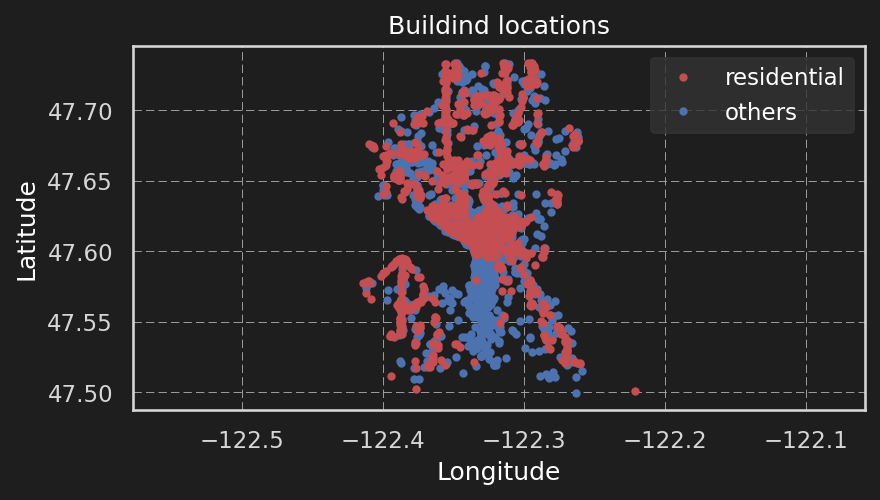

In [8]:
print('initial DataFrame shape:', df.shape )
sr_loc = df['BuildingType'].str.contains('multifamily')

fig, ax = plt.subplots( figsize=(16*cm,8*cm))
ax.plot( df.loc[sr_loc,'Longitude'], df.loc[sr_loc,'Latitude'], 'ro', markersize=3, label='residential', zorder=2 )
ax.plot( df.loc[~sr_loc,'Longitude'], df.loc[~sr_loc,'Latitude'], 'bo', markersize=3, label='others', zorder=1 )
ax.legend()
ax.axis('equal')
ax.set_title('Buildind locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

sr_loc = sr_loc[sr_loc]
df.drop( index=sr_loc.index, inplace=True )
print('DataFrame shape:', df.shape )
display( df['BuildingType'].value_counts() )

Définition d'une fonction pour déterminer les éléments correspondant à du `housing`

In [9]:
def is_housing( sr ):
    sr_loc = (sr.str.contains('hous|multifamily', na=False)) \
        & (~sr.str.contains('warehouse|courthouse', na=True))
    return sr_loc

Vérification et suppression à partir du `PrimaryPropertyType`

In [10]:
var = 'PrimaryPropertyType'
sr_loc = is_housing(df[var])
display( df.loc[sr_loc, var].value_counts() )
df.drop( index=sr_loc[sr_loc].index, inplace=True )
print('DataFrame shape:', df.shape )

low-rise multifamily    3
Name: PrimaryPropertyType, dtype: int64

DataFrame shape: (1665, 45)


1. Vérification et suppression pour le `LargestPropertyUseType`
2. Vérification des LargestPropertyUseType

In [11]:
vars = ['LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType']


sr_loc = is_housing( df[vars[0]] )

# sr_loc = is_housing( df[vars[1]] )
# for var in vars[2:]:
#     sr_loc = sr_loc | is_housing( df[var] )

# display( df['LargestPropertyUseType'].value_counts() )
# display( df['SecondLargestPropertyUseType'].value_counts() )
# display( df['ThirdLargestPropertyUseType'].value_counts() )

print('DataFrame shape:', df.shape )
display( f'housing find in {sr_loc.sum()} elements' )
display( df.loc[sr_loc, vars] )

df.drop( index=sr_loc[sr_loc].index, inplace=True )

print('DataFrame shape:', df.shape )

del vars, var

DataFrame shape: (1665, 45)


'housing find in 9 elements'

LargestPropertyUseType           SecondLargestPropertyUseType  \
164     multifamily housing              supermarket/grocery store   
1159    multifamily housing                                 office   
1839    multifamily housing                                 office   
2314    multifamily housing                                  hotel   
2394    multifamily housing                                parking   
2748    multifamily housing                           retail store   
3003    multifamily housing              supermarket/grocery store   
3041    multifamily housing                                parking   
3087    multifamily housing  other - entertainment/public assembly   

     ThirdLargestPropertyUseType  
164                      parking  
1159                     parking  
1839                retail store  
2314                     parking  
2394                       other  
2748         social/meeting hall  
3003                     parking  
3041                retail store  
3087                         NaN

DataFrame shape: (1656, 45)


## Colonnes Outlier et DefaultData

In [12]:
def value_counts( sr ):
    value_counts = sr.value_counts()
    return pd.DataFrame( {'count': value_counts.values, 
                        '%':value_counts.values*(100/len(sr)) },
                        index=value_counts.index)

print('Outlier:')
display( value_counts( df['Outlier'] ) )
print('DefaultData:')
display( value_counts( df['DefaultData'] ) )

Outlier:


count         %
low outlier      14  0.845411
high outlier      2  0.120773

DefaultData:


count         %
False   1568  94.68599
True      88   5.31401

Mapping des "Outliers"

In [13]:
df['Outlier'] = df['Outlier'].map( {'low outlier':-1, 'high outlier':1}).fillna(0).astype('int')

## Vérifications doublons

In [14]:
print("Number of duplicated: {:}".format( df['OSEBuildingID'].duplicated().sum() ) )

Number of duplicated: 0


## Variables "inutiles"

Vérification des variables inutiles: création d'une liste "à supprimer" (suppression faite à la fin)

In [15]:
vars_to_delete = ['OSEBuildingID', 'PropertyName',
        'TaxParcelIdentificationNumber',
        # 'CouncilDistrictCode',
        'Address', 'ListOfAllPropertyUseTypes']
# df.drop( columns=vars, inplace=True )

In [16]:
vars_to_check = ['DataYear', 'City', 'State']

for var in vars_to_check:
    if not var in df.keys() :
        print( f'{var} not in DataFrame')
        continue
    sr = df[var].value_counts()
    display(sr)
    if len(sr) < 2:
        # df.drop( columns=var, inplace=True )
        vars_to_delete.append( var )
        print( f'{var} added to the drop list')

2016    1656
Name: DataYear, dtype: int64

DataYear added to the drop list


seattle    1656
Name: City, dtype: int64

City added to the drop list


wa    1656
Name: State, dtype: int64

State added to the drop list


## Variable liée à la date
Une variable "AgeOfBuilding(s)" est créée à partir des variables "DataYear" et "YearBuilt".

La variables "DataYear" est remplacée puisque considérée comme inutile (une unique valeur: 2016).

In [17]:
df[['DataYear', 'YearBuilt']].info()
df['DataYear'] = df['DataYear'] - df['YearBuilt']
df.rename( columns={'DataYear':'AgeOfBuilding(s)'}, inplace=True )
vars_to_delete.append( 'YearBuilt' )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656 entries, 0 to 3375
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   DataYear   1656 non-null   int64
 1   YearBuilt  1656 non-null   int64
dtypes: int64(2)
memory usage: 38.8 KB


## Variable de localité

In [18]:
mask = 'Neighborhood'
display( df[mask].value_counts() )

downtown                  357
greater duwamish          346
magnolia / queen anne     150
lake union                146
northeast                 127
east                      118
northwest                  86
ballard                    70
north                      67
central                    55
southeast                  46
delridge                   46
southwest                  41
delridge neighborhoods      1
Name: Neighborhood, dtype: int64

mapping "delridge neighborhoods" $\rightarrow$ "delridge"

In [19]:
df.loc[ df[mask] == 'delridge neighborhoods', mask ] = 'delridge'
display( df[mask].value_counts() )

downtown                 357
greater duwamish         346
magnolia / queen anne    150
lake union               146
northeast                127
east                     118
northwest                 86
ballard                   70
north                     67
central                   55
delridge                  47
southeast                 46
southwest                 41
Name: Neighborhood, dtype: int64

In [20]:
df['ZipCode'].value_counts()

98134.0    182
98104.0    156
98101.0    147
98109.0    140
98108.0    120
98122.0     90
98105.0     85
98121.0     83
98103.0     66
98119.0     62
98125.0     52
98115.0     51
98133.0     51
98107.0     49
98144.0     48
98118.0     46
98106.0     26
98102.0     26
98116.0     24
98126.0     22
98199.0     22
98112.0     21
98117.0     20
98195.0      9
98136.0      6
98155.0      4
98178.0      3
98146.0      3
98124.0      2
98177.0      2
98013.0      2
98168.0      2
98111.0      2
98154.0      2
98181.0      1
98185.0      1
98164.0      1
98006.0      1
98191.0      1
98053.0      1
98033.0      1
98070.0      1
98114.0      1
98165.0      1
98011.0      1
98113.0      1
98020.0      1
98145.0      1
Name: ZipCode, dtype: int64

On note une corrélation partielle entre le ZipCode et le Neighborhood.
Cependant, certains ZipCode ne contiennent qu'une seule valeur.

Neighborhood  downtown  northwest  lake union  magnolia / queen anne  \
ZipCode                                                                
98006              1.0        NaN         NaN                    NaN   
98011              1.0        NaN         NaN                    NaN   
98013              NaN        2.0         NaN                    NaN   
98020              NaN        NaN         1.0                    NaN   
98033              NaN        NaN         NaN                    1.0   
98053              NaN        NaN         NaN                    NaN   
98070              NaN        NaN         1.0                    NaN   
98101            131.0        NaN         NaN                    NaN   
98102              NaN        NaN        18.0                    NaN   
98103              NaN       20.0        44.0                    NaN   
98104            127.0        NaN         2.0                    NaN   
98105              1.0        1.0         3.0                    NaN   
98106              NaN        NaN         NaN                    NaN   
98107              NaN        NaN         1.0                    NaN   
98108              NaN        NaN         NaN                    NaN   
98109              2.0        NaN        76.0                   62.0   
98111              1.0        NaN         NaN                    NaN   
98112              NaN        NaN         NaN                    1.0   
98113              NaN        1.0         NaN                    NaN   
98114              NaN        NaN         NaN                    NaN   
98115              NaN        4.0         NaN                    NaN   
98116              NaN        NaN         NaN                    NaN   
98117              NaN        3.0         NaN                    NaN   
98118              NaN        NaN         NaN                    NaN   
98119              NaN        NaN         NaN                   62.0   
98121             78.0        NaN         NaN                    2.0   
98122              NaN        NaN         NaN                    NaN   
98124              NaN        NaN         NaN                    NaN   
98125              1.0        5.0         NaN                    NaN   
98126              NaN        NaN         NaN                    NaN   
98133              NaN       48.0         NaN                    NaN   
98134              1.0        NaN         NaN                    NaN   
98136              NaN        NaN         NaN                    NaN   
98144              7.0        1.0         NaN                    NaN   
98145              NaN        NaN         NaN                    NaN   
98146              NaN        NaN         NaN                    NaN   
98154              2.0        NaN         NaN                    NaN   
98155              NaN        NaN         NaN                    NaN   
98164              1.0        NaN         NaN                    NaN   
98165              NaN        NaN         NaN                    NaN   
98168              NaN        NaN         NaN                    NaN   
98177              NaN        1.0         NaN                    NaN   
98178              NaN        NaN         NaN                    NaN   
98181              1.0        NaN         NaN                    NaN   
98185              NaN        NaN         NaN                    NaN   
98191              1.0        NaN         NaN                    NaN   
98195              NaN        NaN         NaN                    NaN   
98199              NaN        NaN         NaN                   20.0   
Total            356.0       86.0       146.0                  148.0   

Neighborhood  southwest  northeast  delridge  ballard  greater duwamish  \
ZipCode                                                                   
98006               NaN        NaN       NaN      NaN               NaN   
98011               NaN        NaN       NaN      NaN               NaN   
98013               NaN    

<Axes: xlabel='Neighborhood', ylabel='ZipCode'>

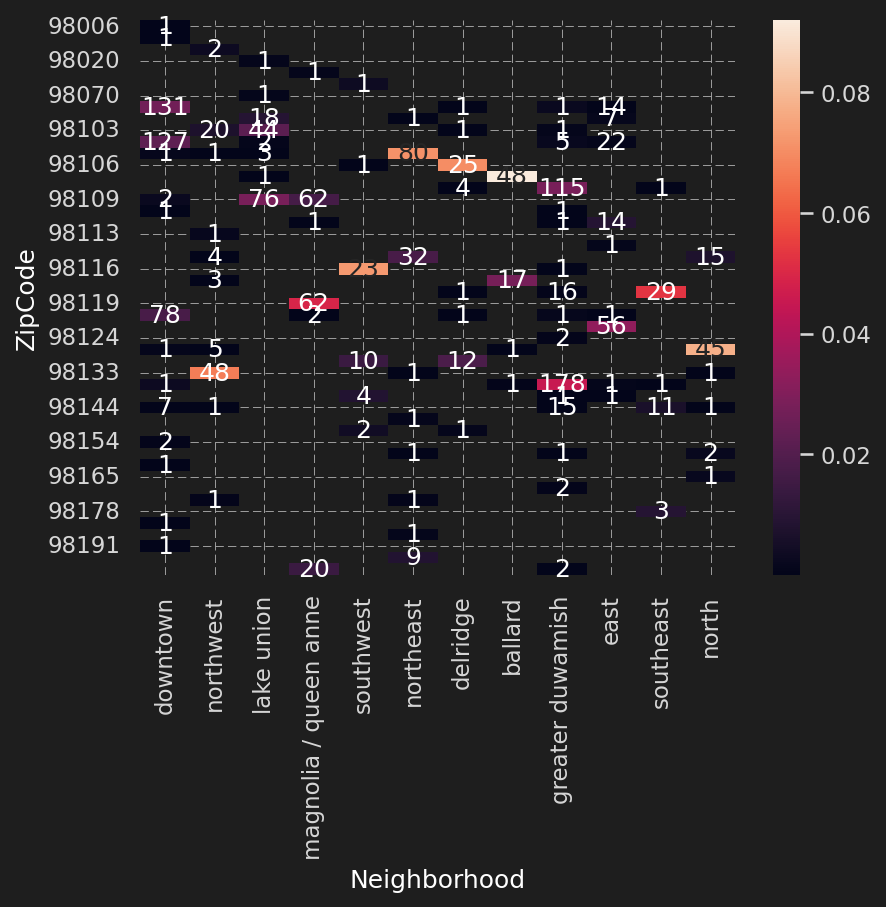

In [21]:
X = "ZipCode"
Y = "Neighborhood"

# display( df[X].value_counts())

tmp = df[[X,Y]].dropna()
tmp[X] = tmp[X].astype(int)
cont = tmp.pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
col_index = cont.fillna(0).values[:-1,:-1].argmax( 1 )
# display( col_index )
col_index = [id for i, id in enumerate(col_index) if not id in col_index[:i]] + [cont.shape[1]-1]
# display( col_index )
cont = cont.iloc[:, col_index]
display(cont)


tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
indep = tx @ ty / len(df)



# c = cont.fillna(0) # On remplace les valeurs nulles par 0
c = cont
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt='.0f')

In [22]:
vars_to_delete += ['ZipCode']

On affiche les zones avec un scatter plot. Le package folium peut être utilsié pour afficher une carte interactive.

In [23]:
import folium
import folium.plugins

fig = folium.Figure(width=400, height=500)
seattle_map = folium.Map( location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=11).add_to(fig)

categories = df['Neighborhood'].value_counts().index
# dict_color = { categ:color for categ,color in zip( categories, sns.color_palette( n_colors=categories.size ) ) }
folim_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
# 'beige', 'white', 'pink',
dict_color = { categ:color for categ,color in zip( categories, folim_colors ) }

for lat, lon, categ in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    # print('color:', dict_color[categ])
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup = ( str(categ)
        #          'var 2 : ' + str(bike) + '<br>'
        #          'var 3: ' + str(traffic) +'%'
                ),
        color=dict_color[categ],
        fill_color=dict_color[categ],
        fill=True,
        fill_opacity=0.9
        ).add_to(seattle_map)
seattle_map

# fig, ax = plt.subplots( figsize=(18*cm,12*cm))
# scttr = sns.scatterplot( data=df, x='Longitude', y='Latitude', hue='Neighborhood', ax=ax )
# ax.axis('equal')
# ax.set_title('Buildind locations')
# ax.set_xlabel('Longutide')
# ax.set_ylabel('Latitude')

# # for legend text
# plt.setp(scttr.get_legend().get_texts(), fontsize='7') 
 
# # for legend title
# plt.setp(scttr.get_legend().get_title(), fontsize='10') 
# plt.show()


## Recherche et gestion des NaN
### Détection des NaN
- Pour les Second & Third LargestPropertyUseType : uniquement 1 ou 2 utilisation du bâtiment $\rightarrow$ à gerer lors du hot encoding
- Pour le YearsENERGYSTARCertified : pas de certification
- Pour le ENERGYSTARscore : essayer de le modéliser ?

In [24]:
sum_isna = df.isna().sum()
print( 'sum isna > 0:' )
display( sum_isna[sum_isna > 0])

sum isna > 0:


ZipCode                              16
NumberofBuildings                     2
ListOfAllPropertyUseTypes             2
LargestPropertyUseType                6
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseType        812
SecondLargestPropertyUseTypeGFA     812
ThirdLargestPropertyUseType        1312
ThirdLargestPropertyUseTypeGFA     1312
YearsENERGYSTARCertified           1558
ENERGYSTARScore                     566
SiteEUI(kBtu/sf)                      3
SiteEUIWN(kBtu/sf)                    3
SourceEUI(kBtu/sf)                    2
SourceEUIWN(kBtu/sf)                  2
SiteEnergyUse(kBtu)                   2
SiteEnergyUseWN(kBtu)                 3
SteamUse(kBtu)                        2
Electricity(kWh)                      2
Electricity(kBtu)                     2
NaturalGas(therms)                    2
NaturalGas(kBtu)                      2
TotalGHGEmissions                     2
GHGEmissionsIntensity                 2
dtype: int64

In [25]:
if False:
    ax = msno.bar( df )
    ax = msno.matrix( df.sort_values( by=['SecondLargestPropertyUseType','ThirdLargestPropertyUseType'] ) )

Il y a clairement des lignes avec un gros manque d'informations -> à enlever
- sur les energy : fillna(0) + sum(1) == 0 -> drop
- LargestPropertyUse : à remplir à partir du PrimaryPropertyType 

In [26]:
energy_keys = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
'SteamUse(kBtu)', 
'Electricity(kWh)', 'Electricity(kBtu)',
'NaturalGas(therms)', 'NaturalGas(kBtu)',
'TotalGHGEmissions', 'GHGEmissionsIntensity']

property_use_keys = [ 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType']

others = ['NumberofBuildings']

keys = property_use_keys + others + energy_keys

sr_loc = df[keys].isna().sum(1) > 0
print('Entries with empty cells:')
display( df.loc[sr_loc, keys])

# DROP DATA WITHOUT ENERGY INFORMATION / CONSUMPTION
indexes = (df[energy_keys].fillna(0.).sum(1) == 0.)
indexes = indexes[indexes].index
print('indexes to drop:', indexes.values)
print('DataFrame shape:', df.shape)
df.drop( index=indexes , inplace=True )

print('Entries with empty cells (after drop):')
sr_loc = df[keys].isna().sum(1) > 0
display( df.loc[sr_loc, keys])
print('DataFrame shape:', df.shape)

Entries with empty cells:


PrimaryPropertyType  \
304                         other   
353         self-storage facility   
563                  large office   
578   small- and mid-sized office   
1147                        hotel   
2414  small- and mid-sized office   
2459                   restaurant   
2670           mixed use property   

                              ListOfAllPropertyUseTypes  \
304                          convention center, parking   
353   fitness center/health club/gym, office, other ...   
563                                office, retail store   
578                                                 NaN   
1147                                              hotel   
2414                                             office   
2459                                         restaurant   
2670                                                NaN   

     LargestPropertyUseType  NumberofBuildings  SiteEUI(kBtu/sf)  \
304       convention center                1.0               NaN   
353                     NaN                2.0         47.799999   
563                  office                1.0         39.500000   
578                     NaN                NaN               NaN   
1147                    NaN                1.0         52.200001   
2414                    NaN                1.0         72.199997   
2459                    NaN                1.0         31.200001   
2670                    NaN                NaN               NaN   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
304             0.000000            0.000000              0.000000   
353            51.000000          103.000000            106.400002   
563                  NaN          128.000000              0.000000   
578                  NaN                 NaN                   NaN   
1147           53.500000          150.399994            154.399994   
2414           74.699997          226.600006            234.600006   
2459           32.500000           62.000000             62.799999   
2670                 NaN                 NaN                   NaN   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
304          0.000000e+00           0.000000e+00             0.0   
353          5.697472e+06           6.076957e+06             0.0   
563          5.177270e+06                    NaN             0.0   
578                   NaN                    NaN             NaN   
1147         2.897080e+06           2.968430e+06             0.0   
2414         3.168131e+06           3.280956e+06             0.0   
2459         8.999242e+05           9.358332e+05             0.0   
2670                  NaN                    NaN             NaN   

      Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
304       0.000000e+00                0.0            0.000000   
353       8.814520e+05          3007514.0        26899.582030   
563       1.427645e+06          4871126.0        14160.409180   
578                NaN                NaN                 NaN   
1147      7.428464e+05          2534592.0         3624.875244   
2414      9.285260e+05          3168131.0            0.000000   
2459      1.180853e+05           402907.0         4970.169922   
2670               NaN                NaN                 NaN   

      NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
304                0.0               0.00                   0.00  
353          2689958.0             163.83                   1.47  
563          1416041.0             109.16                   0.83  
578                NaN                NaN                    NaN  
1147          362488.0              36.92                   0.60  
2414               0.0              22.09                   0.46  
2459          497017.0              29.21                   1.01  
2670               NaN                NaN                    NaN

indexes to drop: [  28  152  304  578  746 1361 2670]
DataFrame shape: (1656, 45)
Entries with empty cells (after drop):


PrimaryPropertyType  \
353         self-storage facility   
563                  large office   
1147                        hotel   
2414  small- and mid-sized office   
2459                   restaurant   

                              ListOfAllPropertyUseTypes  \
353   fitness center/health club/gym, office, other ...   
563                                office, retail store   
1147                                              hotel   
2414                                             office   
2459                                         restaurant   

     LargestPropertyUseType  NumberofBuildings  SiteEUI(kBtu/sf)  \
353                     NaN                2.0         47.799999   
563                  office                1.0         39.500000   
1147                    NaN                1.0         52.200001   
2414                    NaN                1.0         72.199997   
2459                    NaN                1.0         31.200001   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
353            51.000000          103.000000            106.400002   
563                  NaN          128.000000              0.000000   
1147           53.500000          150.399994            154.399994   
2414           74.699997          226.600006            234.600006   
2459           32.500000           62.000000             62.799999   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
353          5.697472e+06           6.076957e+06             0.0   
563          5.177270e+06                    NaN             0.0   
1147         2.897080e+06           2.968430e+06             0.0   
2414         3.168131e+06           3.280956e+06             0.0   
2459         8.999242e+05           9.358332e+05             0.0   

      Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
353       8.814520e+05          3007514.0        26899.582030   
563       1.427645e+06          4871126.0        14160.409180   
1147      7.428464e+05          2534592.0         3624.875244   
2414      9.285260e+05          3168131.0            0.000000   
2459      1.180853e+05           402907.0         4970.169922   

      NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
353          2689958.0             163.83                   1.47  
563          1416041.0             109.16                   0.83  
1147          362488.0              36.92                   0.60  
2414               0.0              22.09                   0.46  
2459          497017.0              29.21                   1.01

DataFrame shape: (1649, 45)


### Remplissage des NaN
On regarde les éléments sans LargestPropertyUseType

In [27]:
vars = ['PrimaryPropertyType', 'ListOfAllPropertyUseTypes',
        'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)',
        'PropertyGFAParking', 'PropertyGFATotal' ]
sr_loc = (df['LargestPropertyUseType'].isna())
display( df.loc[sr_loc,vars])

PrimaryPropertyType  \
353         self-storage facility   
1147                        hotel   
2414  small- and mid-sized office   
2459                   restaurant   

                              ListOfAllPropertyUseTypes  \
353   fitness center/health club/gym, office, other ...   
1147                                              hotel   
2414                                             office   
2459                                         restaurant   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
353                     NaN                        NaN   
1147                    NaN                        NaN   
2414                    NaN                        NaN   
2459                    NaN                        NaN   

      PropertyGFABuilding(s)  PropertyGFAParking  PropertyGFATotal  
353                   111445                   0            111445  
1147                   61721                   0             61721  
2414                   48350                   0             48350  
2459                   28800                   0             28800

In [28]:
display( df.loc[ df['PrimaryPropertyType']=="self-storage facility", 'LargestPropertyUseType'].value_counts() )
display( df.loc[ df['PrimaryPropertyType'].str.contains('office'), 'LargestPropertyUseType'].value_counts() )

self-storage facility    27
Name: LargestPropertyUseType, dtype: int64

office            466
medical office     39
Name: LargestPropertyUseType, dtype: int64

À priori on peut replacer les valeurs manquantes de "LargestPropertyUseType(GFA)" par la "PrimaryPropertyType" / le "PropertyGFABuilding(s)".

Note: si présence de "office" dans le "PrimaryPropertyType", alors la valeur est "office" (pas de distinctions pour les "LargestPropertyUseType")

In [29]:
for index in sr_loc[sr_loc].index:
    Primary = df.at[index, 'PrimaryPropertyType']
    df.at[index, 'LargestPropertyUseTypeGFA'] = df.at[index, 'PropertyGFABuilding(s)']
    if 'office' in Primary:
        df.at[index, 'LargestPropertyUseType'] = 'office'
        continue
    df.at[index, 'LargestPropertyUseType'] = Primary

On vérifie le résultat:

In [30]:
display( df.loc[sr_loc,vars] )

PrimaryPropertyType  \
353         self-storage facility   
1147                        hotel   
2414  small- and mid-sized office   
2459                   restaurant   

                              ListOfAllPropertyUseTypes  \
353   fitness center/health club/gym, office, other ...   
1147                                              hotel   
2414                                             office   
2459                                         restaurant   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
353   self-storage facility                   111445.0   
1147                  hotel                    61721.0   
2414                 office                    48350.0   
2459             restaurant                    28800.0   

      PropertyGFABuilding(s)  PropertyGFAParking  PropertyGFATotal  
353                   111445                   0            111445  
1147                   61721                   0             61721  
2414                   48350                   0             48350  
2459                   28800                   0             28800

In [31]:
sum_isna = df.isna().sum()
print( 'sum isna > 0:' )
display( sum_isna[sum_isna > 0])

sum isna > 0:


ZipCode                              16
SecondLargestPropertyUseType        806
SecondLargestPropertyUseTypeGFA     806
ThirdLargestPropertyUseType        1305
ThirdLargestPropertyUseTypeGFA     1305
YearsENERGYSTARCertified           1551
ENERGYSTARScore                     560
SiteEUIWN(kBtu/sf)                    1
SiteEnergyUseWN(kBtu)                 1
dtype: int64

Remplissage du ZipCode à partir de la longitude et de la latitude: toutes les données étant à Seattle, les variables `Longitude` et `Latitude` peuvent être utilisée comme (`x`,`y`).

Si il y avait plus d'écarts entre les positions, possibilité d'utilisé le package `haversine`.

In [32]:
sr_loc = df['ZipCode'].isna()
for index in sr_loc[sr_loc].index:
    x,y = df.loc[index, ['Longitude', 'Latitude']].values
    for value in df['Longitude']:
        if isinstance( value, str):
            print('value:', value)
    df['Longitude'].values-x
    df['Latitude'].values-y
    argsort = ((df['Longitude'].values-x)**2 + (df['Latitude'].values-y)**2).argsort()
    for i in argsort[1:]: # neglect the first as it corresponds to the current index
        if np.isnan( df['ZipCode'].iloc[i] ) :
            continue
        df.at[index, 'ZipCode'] = df['ZipCode'].iloc[i]
        break 
    # print('\nx,y:', x,y, '\nx2,y2:', df[['Longitude','Latitude']].iloc[i,:].values )

df['ZipCode'] = df['ZipCode'].astype(int)

sum_isna = df.isna().sum()
print( 'After procees sum isna > 0:' )
display( sum_isna[sum_isna > 0])

After procees sum isna > 0:


SecondLargestPropertyUseType        806
SecondLargestPropertyUseTypeGFA     806
ThirdLargestPropertyUseType        1305
ThirdLargestPropertyUseTypeGFA     1305
YearsENERGYSTARCertified           1551
ENERGYSTARScore                     560
SiteEUIWN(kBtu/sf)                    1
SiteEnergyUseWN(kBtu)                 1
dtype: int64

## Recherches à partir des variables "DefaultData" et "ComplianceStatus"

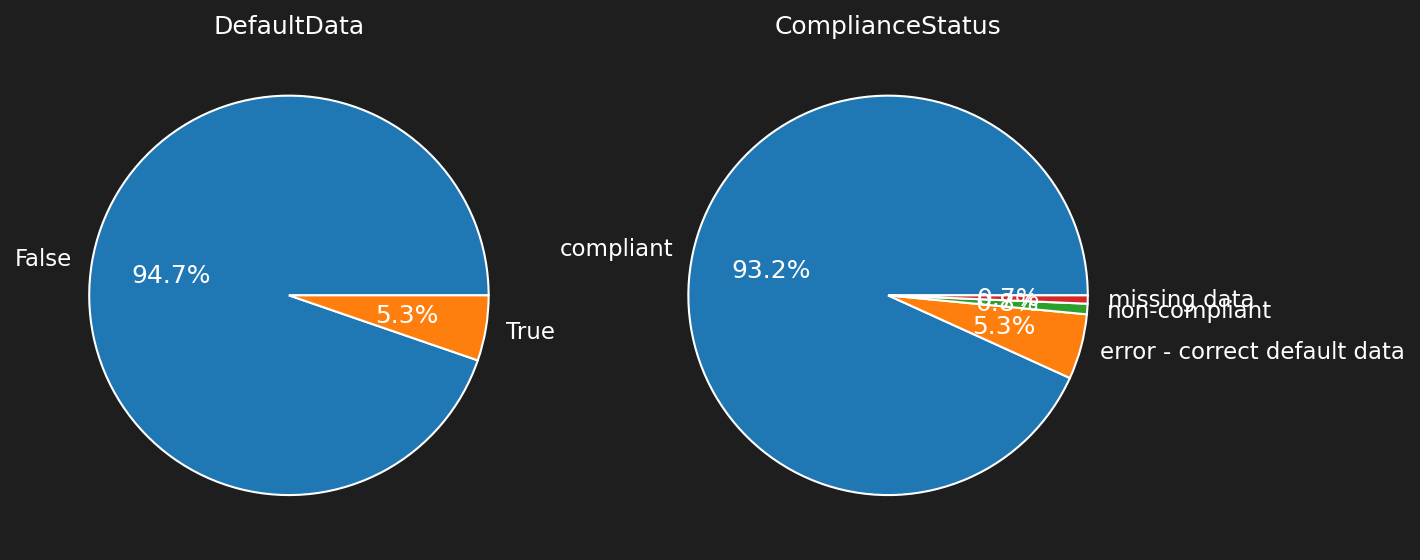

In [33]:
fig, axs = plt.subplots( ncols=2, figsize=(24*cm,12*cm))
for ax, key in zip( axs, ['DefaultData', 'ComplianceStatus']):
    df[key].value_counts(normalize=True).plot( kind='pie', ax=ax, autopct='%.1f%%' )
    ax.set_title( key)
    ax.set_ylabel('')

On peut se poser la question de l'intérêt de supprimer certaines entrées.

Dans l'idée, les données seront mesurées pour les nouveaux bâtiments, donc autant enlever les entrées avec des valeurs imputées.

In [34]:
sr_loc = df['DefaultData'] | ( df['ComplianceStatus'].str.contains( '|'.join( ['missing', 'error'] ) ) )
df.drop( index=sr_loc[sr_loc].index ,inplace=True )

***
# Vérifications des données d'entrée

In [35]:
df.columns

Index(['OSEBuildingID', 'AgeOfBuilding(s)', 'BuildingType',
       'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State',
       'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'ComplianceStatus', 'Outlier', '

## Value_counts des variables

In [36]:
print('DataFrame shape:', df.shape )

DataFrame shape: (1551, 45)


In [37]:
vars = ['BuildingType', 'PrimaryPropertyType',
       'Neighborhood', 'NumberofBuildings',
       'NumberofFloors', 'LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType',
       ]
for var in vars:
    print( f'{var} value_counts:')
    display( df[var].value_counts() )

BuildingType value_counts:


nonresidential        1435
nonresidential cos      82
campus                  23
sps-district k-12       10
nonresidential wa        1
Name: BuildingType, dtype: int64

PrimaryPropertyType value_counts:


small- and mid-sized office    289
other                          248
warehouse                      185
large office                   172
mixed use property             104
retail store                    86
hotel                           76
worship facility                71
distribution center             53
k-12 school                     51
supermarket / grocery store     40
medical office                  39
self-storage facility           28
university                      24
residence hall                  21
senior care community           20
refrigerated warehouse          12
restaurant                      12
hospital                        10
laboratory                      10
Name: PrimaryPropertyType, dtype: int64

Neighborhood value_counts:


downtown                 352
greater duwamish         331
magnolia / queen anne    144
lake union               141
northeast                118
east                     114
northwest                 78
ballard                   63
north                     59
central                   47
delridge                  41
southwest                 32
southeast                 31
Name: Neighborhood, dtype: int64

NumberofBuildings value_counts:


1.0      1447
0.0        52
2.0        14
3.0        12
5.0         7
4.0         4
6.0         4
14.0        2
8.0         2
27.0        1
11.0        1
9.0         1
7.0         1
23.0        1
10.0        1
111.0       1
Name: NumberofBuildings, dtype: int64

NumberofFloors value_counts:


1     425
2     355
3     242
4     138
5     101
6      81
7      34
8      22
10     18
11     18
0      16
14      9
12      9
9       8
13      7
15      6
42      5
19      5
17      4
29      3
22      3
21      3
23      3
16      3
18      3
20      3
24      3
25      3
33      3
34      2
36      2
41      2
56      1
28      1
76      1
27      1
46      1
30      1
47      1
55      1
63      1
37      1
49      1
99      1
Name: NumberofFloors, dtype: int64

LargestPropertyUseType value_counts:


office                                                  492
non-refrigerated warehouse                              197
other                                                    98
retail store                                             94
hotel                                                    77
worship facility                                         71
distribution center                                      54
k-12 school                                              51
supermarket/grocery store                                41
medical office                                           41
other - recreation                                       31
parking                                                  30
self-storage facility                                    28
college/university                                       24
residence hall/dormitory                                 22
other - entertainment/public assembly                    21
senior care community                   

SecondLargestPropertyUseType value_counts:


parking                                                 332
office                                                  165
retail store                                             82
other                                                    44
restaurant                                               29
non-refrigerated warehouse                               28
fitness center/health club/gym                           16
data center                                              13
multifamily housing                                      12
other - services                                         11
laboratory                                                8
medical office                                            8
supermarket/grocery store                                 7
distribution center                                       7
bank branch                                               7
other - entertainment/public assembly                     6
k-12 school                             

ThirdLargestPropertyUseType value_counts:


office                                                  49
retail store                                            45
parking                                                 41
other                                                   38
restaurant                                              31
data center                                             14
non-refrigerated warehouse                              14
multifamily housing                                     12
swimming pool                                           10
medical office                                           9
food service                                             8
pre-school/daycare                                       8
social/meeting hall                                      7
bank branch                                              5
other - restaurant/bar                                   5
financial office                                         4
fitness center/health club/gym                          

Il semble incohérent d'avoir 0 bâtiments. Idem pour "number of floors" qui, en anglais, prend en compte le rez-de-chaussé.

In [38]:
for X in ['NumberofBuildings', 'NumberofFloors']:
    df.loc[ df[X]==0, X ] = 1
df['NumberofBuildings'] = df['NumberofBuildings'].astype(int)

## Diverses vérifications

### Number of floors
On regarde les number of floors pour voir si il y a des valeurs aberrantes

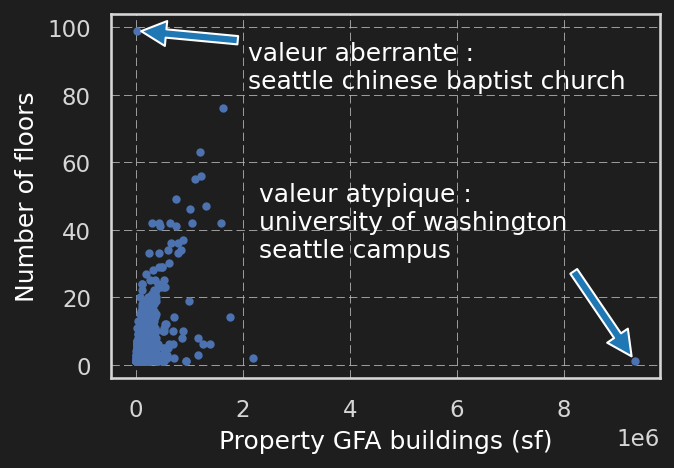

In [39]:
X, Y = 'PropertyGFABuilding(s)', 'NumberofFloors'

fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( df[X], df[Y], 'bo', markersize=3 )

ax.set_ylabel( 'Number of floors' )
ax.set_xlabel( 'Property GFA buildings (sf)' )

index_100 = df[Y] > 90
index_100 = index_100[index_100].index.values[0]

_ = ax.annotate( 'valeur aberrante :\n{:}'.format( 
                df.at[index_100, 'PropertyName'] ),
                xy=[0, 99], xytext=[2.1e6, 82],# ha='left', va='center',
                arrowprops=dict(shrink=0.05) )

index_high_GFA = df[X] > 8e6
index_high_GFA = index_high_GFA[index_high_GFA].index.values[0]

_ = ax.annotate( 'valeur atypique :\n{:}'.format( 
                df.at[index_high_GFA, 'PropertyName'].replace(' - ', '\n') ),
                xy=[df.at[index_high_GFA , X], 1], xytext=[2.3e6, 32],# ha='left', va='center',
                arrowprops=dict(shrink=0.05) )

On assigne la valeur la plus utilisée pour NumberofFloors: 1, sachant que la surface est relativement faible.

In [40]:
df.at[index_100, Y] = 1

### Number of Buildings

Certains `NumberofBuildings` sont particulièrement élevés, mais à priori OK.

In [41]:
mask = 'NumberofBuildings'
df.loc[ df[mask] > 5, :].sort_values( by=mask )

OSEBuildingID  AgeOfBuilding(s)        BuildingType  \
124             198                63      nonresidential   
167             268                26      nonresidential   
364             516                52      nonresidential   
2901          27389                60      nonresidential   
618             828                22      nonresidential   
1672          23071                50      nonresidential   
3168          49705                87  nonresidential cos   
170             276                16      nonresidential   
1993          24086                25              campus   
128             211                46              campus   
162             261                36              campus   
2325          25251                71              campus   
1862          23622                61              campus   
105             172                46              campus   
3274          49967               116              campus   

              PrimaryPropertyType  \
124                      hospital   
167                      hospital   
364                         other   
2901  small- and mid-sized office   
618                      hospital   
1672                     hospital   
3168                        other   
170                      hospital   
1993                        other   
128                    university   
162                  large office   
2325                   university   
1862                        other   
105                    university   
3274                   university   

                                           PropertyName  \
124             seattle children's hospital main campus   
167                                 swedish cherry hill   
364                              aurora shopping center   
2901                                  leschi lakecenter   
618                                  swedish first hill   
1672                          main hospital - all wings   
3168                                           magnuson   
170                           harborview medical center   
1993  (id#24086)campus1:kc metro transit atlantic ce...   
128                                    nscc main campus   
162                                          south park   
2325                            5th avenue master meter   
1862                          ft c15 fishermen's center   
105                                    sscc main campus   
3274          university of washington - seattle campus   

                              Address     City State  ZipCode  \
124            4800 sand point way ne  seattle    wa    98105   
167                      500 17th ave  seattle    wa    98122   
364         13201 aurora avenue north  seattle    wa    98133   
2901                     120 lakeside  seattle    wa    98122   
618                      747 broadway  seattle    wa    98122   
1672  facilities management ms: b-120  seattle    wa    98133   
3168           7400 sand point way ne  seattle    wa    98115   
170                      325 9th ave.  seattle    wa    98104   
1993               1333 airport way s  seattle    wa    98134   
128                9600 college way n  seattle    wa    98103   
162                    1420 s trenton  seattle    wa    98108   
2325                  3307 3rd ave. w  seattle    wa    98119   
1862       1900 west nickerson street  seattle    wa    98119   
105                  6000 16th ave sw  seattle    wa    98106   
3274        ne 45th st & brooklyn ave  seattle    wa    98105   

     TaxParcelIdentificationNumber  CouncilDistrictCode  \
124                     2982800005                    4   
167                     7942600331                    3   
364                     1926049215                    5   
2901                    4114601145                    3   
618                     1978201096                    3   
1672                    3026049130                    5   
3168                    0225049062   

### PorpertyGFA
Présence d'outliers ?

`university of washington - seattle campus` et `entire campus` correspondent à des valeurs `atypique` mais non aberrantes

In [42]:
mask = 'PropertyGFATotal'
describe = df[mask].describe()
print(mask)
display(describe)

print('Q3 + 1.5*IQ = {:.3e}'.format( describe['75%'] 
            + 1.5*(describe['75%']-describe['25%']) ) )

df_sorted = df.sort_values( by=mask, ascending=False ).iloc[:5,:]
display( df_sorted )

PropertyGFATotal


count    1.551000e+03
mean     1.205977e+05
std      3.050729e+05
min      1.128500e+04
25%      2.880400e+04
50%      4.813900e+04
75%      1.077510e+05
max      9.320156e+06
Name: PropertyGFATotal, dtype: float64

Q3 + 1.5*IQ = 2.262e+05


OSEBuildingID  AgeOfBuilding(s)    BuildingType PrimaryPropertyType  \
3274          49967               116          campus          university   
1494          22062                77          campus          university   
559             775                31  nonresidential        large office   
618             828                22  nonresidential            hospital   
292             422                27  nonresidential        large office   

                                   PropertyName                    Address  \
3274  university of washington - seattle campus  ne 45th st & brooklyn ave   
1494                              entire campus            901 12th avenue   
559                      columbia center - 2015             701 5th avenue   
618                          swedish first hill               747 broadway   
292                            two union square              601 union st.   

         City State  ZipCode TaxParcelIdentificationNumber  \
3274  seattle    wa    98105                    1625049001   
1494  seattle    wa    98122                    2254500880   
559   seattle    wa    98104                    0942000640   
618   seattle    wa    98122                    1978201096   
292   seattle    wa    98101                    1976700125   

      CouncilDistrictCode Neighborhood   Latitude   Longitude  YearBuilt  \
3274                    4    northeast  47.656440 -122.310410       1900   
1494                    3         east  47.610650 -122.317110       1939   
559                     7     downtown  47.604540 -122.330720       1985   
618                     3         east  47.608951 -122.322402       1994   
292                     7     downtown  47.610430 -122.332060       1989   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3274                111               1           9320156                   0   
1494                  1               2           2200000                   0   
559                   1              76           1952220              319400   
618                   7              14           1765970                   0   
292                   1              56           1605578              389860   

      PropertyGFABuilding(s)                       ListOfAllPropertyUseTypes  \
3274                 9320156                              college/university   
1494                 2200000                     college/university, parking   
559                  1632820                                 office, parking   
618                  1765970  hospital (general medical & surgical), parking   
292                  1215718                          office, other, parking   

                     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
3274                     college/university                  9320156.0   
1494                     college/university                  1719643.0   
559                                  office                  1680937.0   
618   hospital (general medical & surgical)                  1639334.0   
292                                  office                  1314475.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
3274                          NaN                              NaN   
1494                      parking                         318960.0   
559                       parking                         319368.0   
618                       parking                         441551.0   
292                       parking                         389860.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
3274                         NaN                             NaN   
1494                         NaN                             NaN   
559                          NaN                             NaN   
618                          NaN                             NaN   
292                        other                         30744.0   

 

Les 2 universités sont des valeurs atypiques.

In [43]:
if False:
    print('DataFrame shape:', df.shape)
    display( df_sorted.iloc[:2,:] )
    df.drop( index=df_sorted.index[:2], inplace=True )
    print('DataFrame shape:', df.shape)

### GFA parking
Beaucoup de bâtiments semblent ne pas avoir de parkings

In [44]:
mask = 'PropertyGFAParking'
describe = df[mask].describe()
print('Q3 + 1.5*IQ = {:.3e}'.format( describe['75%'] 
            + 1.5*(describe['75%']-describe['25%']) ) )
display(describe.T)
df.sort_values( by=mask, ascending=False ).iloc[:5,:]

Q3 + 1.5*IQ = 0.000e+00


count      1551.000000
mean      13744.232753
std       43619.470741
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      512608.000000
Name: PropertyGFAParking, dtype: float64

OSEBuildingID  AgeOfBuilding(s)    BuildingType PrimaryPropertyType  \
273            402                27  nonresidential        large office   
307            438                24  nonresidential      medical office   
292            422                27  nonresidential        large office   
229            353                47  nonresidential        large office   
163            263                 8  nonresidential               other   

           PropertyName                Address     City State  ZipCode  \
273      us bank centre        1420 5th avenue  seattle    wa    98101   
307  1101 madison tower           1101 madison  seattle    wa    98104   
292    two union square          601 union st.  seattle    wa    98101   
229        safeco plaza     1001 fourth avenue  seattle    wa    98154   
163          building 1  316 ne thornton place  seattle    wa    98125   

    TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
273                    1975700080                    7     downtown  47.61054   
307                    1978200625                    3         east  47.60921   
292                    1976700125                    7     downtown  47.61043   
229                    0942000300                    7     downtown  47.60615   
163                    8632880000                    5        north  47.70281   

     Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
273 -122.33466       1989                  1              46   
307 -122.32425       1992                  1              14   
292 -122.33206       1989                  1              56   
229 -122.33388       1969                  1              49   
163 -122.32532       2008                  1               6   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
273           1536606              512608                 1023998   
307            690158              407795                  282363   
292           1605578              389860                 1215718   
229           1123435              368980                  754455   
163            419848              335109                   84739   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
273  financial office, office, other, parking, rest...                 office   
307                            medical office, parking         medical office   
292                             office, other, parking                 office   
229  financial office, food sales, office, other, p...                 office   
163  fast food restaurant, medical office, movie th...                parking   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
273                  1002403.0                      parking   
307                   270384.0                      parking   
292                  1314475.0                      parking   
229                   808980.0                      parking   
163                   335109.0                movie theater   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
273                         377046.0                       other   
307                         270383.0                         NaN   
292                         389860.0                       other   
229                         232248.0                       other   
163                          65000.0              medical office   

     ThirdLargestPropertyUseTypeGFA              YearsENERGYSTARCertified  \
273                         53116.0  201720162014201320122011201020092007   
307                             NaN                      2012201020072006   
292                         30744.0                              20092005   
229                         30329.0                  20162015201420122008   
163                         13567.0                                   NaN   

     ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
273             

## Categories "LargestPropertyUseType"

Liste des catégories

In [45]:
df['LargestPropertyUseType'].value_counts().add(
    df['SecondLargestPropertyUseType'].value_counts(), fill_value=0 ).add(
    df['ThirdLargestPropertyUseType'].value_counts(), fill_value=0 ).astype(int).sort_values()

wholesale club/supercenter                                1
police station                                            1
residential care facility                                 1
fire station                                              1
fast food restaurant                                      1
enclosed mall                                             1
food sales                                                2
other - technology/science                                2
courthouse                                                2
lifestyle center                                          2
vocational school                                         2
convenience store without gas station                     3
other - utility                                           3
prison/incarceration                                      3
bar/nightclub                                             3
library                                                   4
movie theater                           

Affichage de quelques catégories

In [46]:
df.loc[ df['LargestPropertyUseType'].str.contains('other - entertainment/public assembly', na=False), 'PropertyName']

7              paramount theatre
47                 mann building
97                 benaroya hall
155                  centurylink
158                 safeco field
185                  act theatre
197             seattle aquarium
373           seattle art museum
625                   emp museum
922         neptune theatre bldg
1257           town hall seattle
1293            showbox building
1634    seattle asian art museum
2139                        sodo
2183      (id24701) showbox sodo
2381               art marble 21
2512     swedish cultural center
2521        mlk community center
2568        (id26126) the summit
2607                4130 1st ave
2904      the greenlind building
Name: PropertyName, dtype: object

In [47]:
masks = ['LargestPropertyUseType','SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
for mask in masks:
    display( df.loc[df[mask].str.contains('recreation', na=False), mask].value_counts() )

other - recreation    31
Name: LargestPropertyUseType, dtype: int64

other - recreation    4
Name: SecondLargestPropertyUseType, dtype: int64

other - recreation    2
Name: ThirdLargestPropertyUseType, dtype: int64

Mapping pour réduire le nombre de catégories

In [48]:
categories_keys = [ ('store', ['wholesale', 'mall', 'store', 'dealership', 'distribution center'] ),
                    ('utility', ['fire', 'utility', 'police', 'courthouse', 'prison', 'bank']),
                    ('restaurant', ['food', 'restaurant']),
                    ('residential - hotel', ['residential', 'housing', 'hotel', 'dormitory']),
                    ('education', ['school', 'education', 'university']),
                    ('medical', ['care', 'hospital']),
                    ('office', ['financial office']),
                    ('entertainment - public assembly', ['theater','nightclub',
                                'recreation', 'swimming', 'performing arts',
                                'library','museum','meeting hall']),
                    ('lifestyle center', ['lifestyle', 'fitness']),
                    ('science', ['technology', 'laboratory']),
                    ('services', ['services']),
                    ('industrial', ['industrial', 'refrigerated']),
             ]
for (category,keys) in categories_keys :
    joint_keys = '|'.join(keys)
    for mask in masks:
        sr_loc = df[mask].str.contains( joint_keys , na=False )
        df.loc[ sr_loc, mask ] = category


value_counts = df['LargestPropertyUseType'].value_counts().add(
    df['SecondLargestPropertyUseType'].value_counts(), fill_value=0 ).add(
    df['ThirdLargestPropertyUseType'].value_counts(), fill_value=0 ).astype(int).sort_values()

print( f'{len(value_counts)} categories')
display( value_counts )

19 categories


science                                   25
utility                                   26
lifestyle center                          27
data center                               30
other - entertainment/public assembly     31
self-storage facility                     33
services                                  37
medical                                   40
medical office                            58
worship facility                          75
entertainment - public assembly           90
restaurant                                95
education                                107
residential - hotel                      134
other                                    180
industrial                               266
store                                    357
parking                                  403
office                                   715
dtype: int64

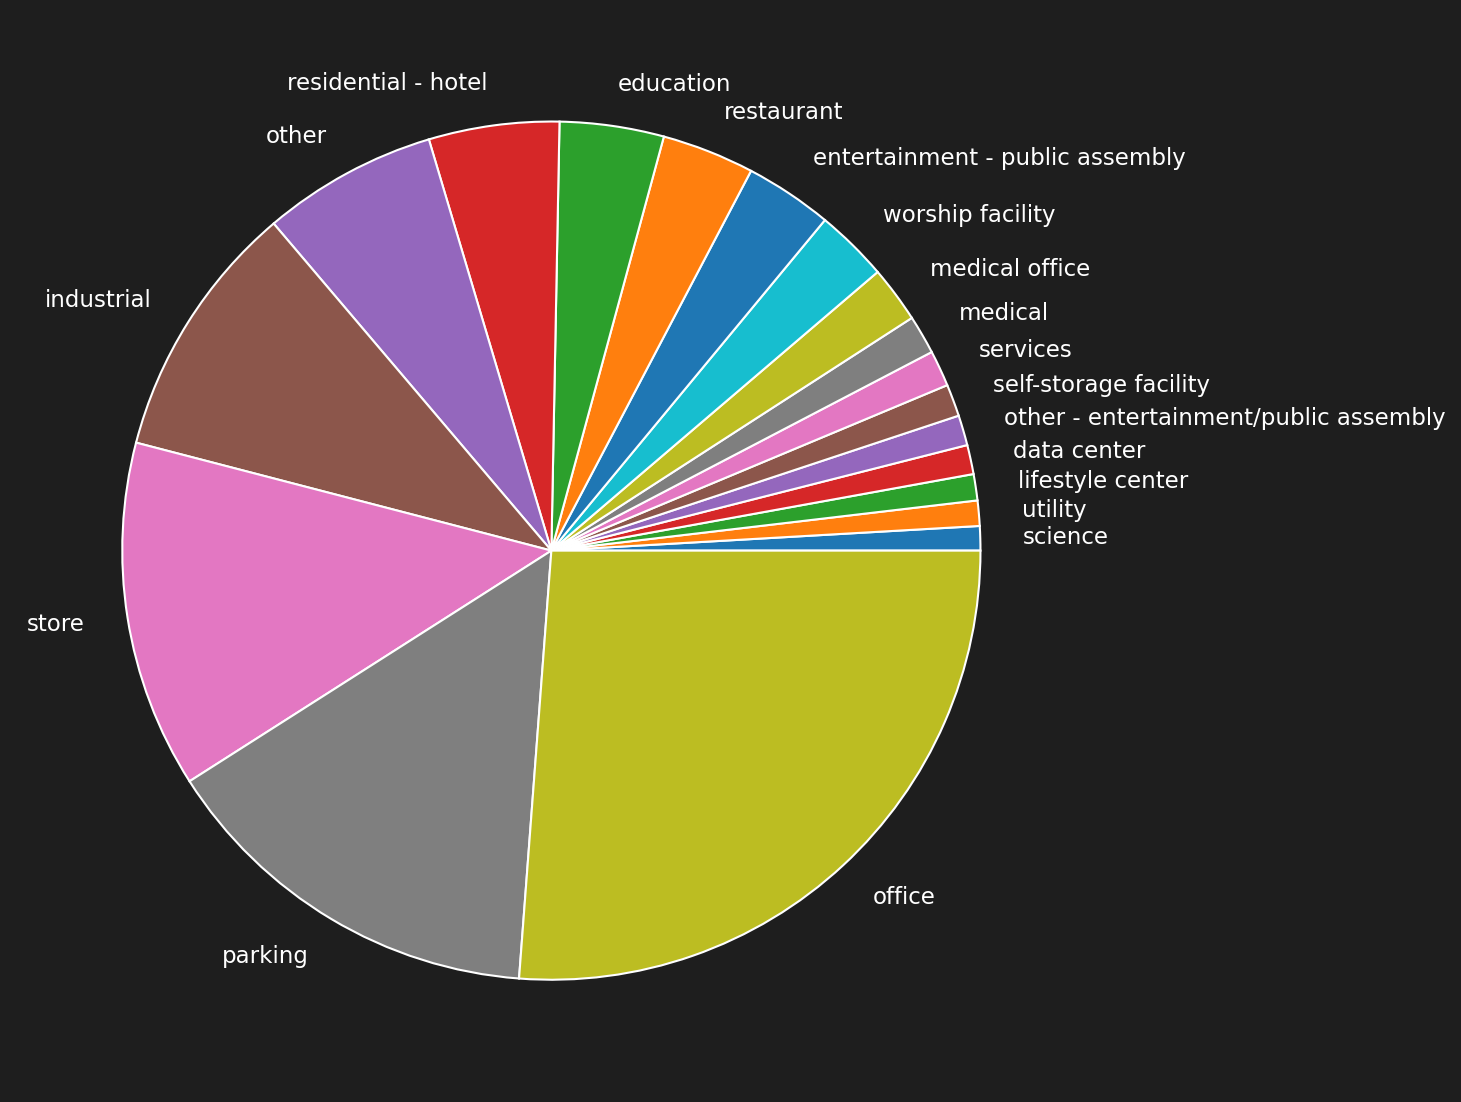

In [49]:
fig, ax = plt.subplots( figsize=(25*cm,25*cm) )
value_counts.plot( kind='pie', ax=ax )
fig.tight_layout()

## Year-built -> categories ?
à priori pas de relation directe évidente -> on peut séparer en plusieurs groupes

min: 1900 max: 2015
[1900 1920 1940 1960 1980 2000]


YearBuilt  YearBuiltCateg
2215       1900               1
904        1965               5
439        1956               4
873        1927               2
492        1985               6
3173       2012               7
3176       2012               7
383        2002               7
2406       1900               1
770        1928               2

YearBuilt  YearBuiltCateg
0        1927               2
1        1996               6
2        1969               5
3        1926               2
4        1980               6
5        1999               6
6        1926               2
7        1926               2
8        1904               1
10       1969               5

breaks begin at: [1932 1942]
breaks end at: [1935 1944]


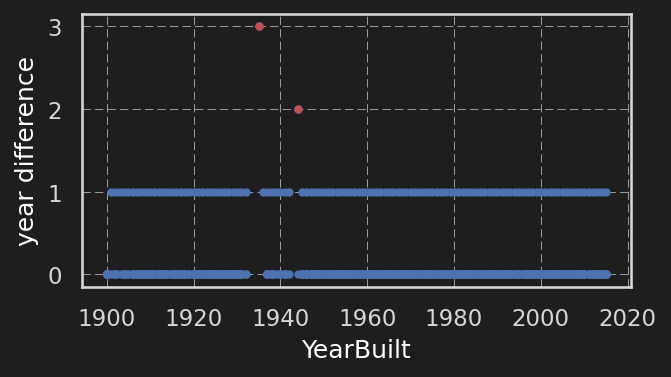

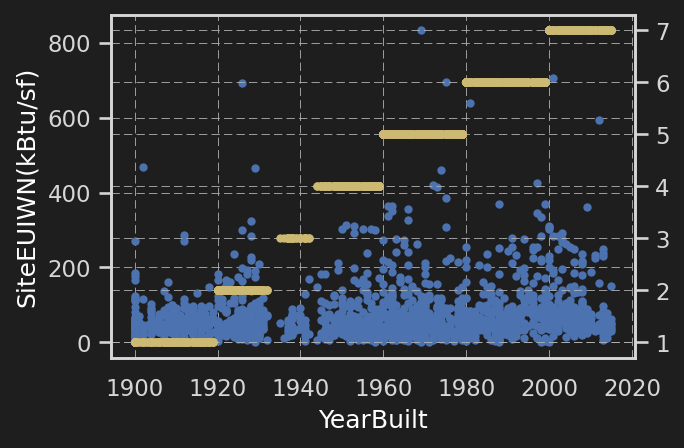

In [50]:
X, Y = 'YearBuilt', 'SiteEUIWN(kBtu/sf)'

print('min:', df[X].min(), 'max:', df[X].max() )
print( np.arange( 1900, 2020, 20 ) )

bins_yearbuilt = [1900, 1920, 1934, 1943, 1960, 1980, 2000, 2020]
df['YearBuiltCateg'] = np.digitize( df[X], bins_yearbuilt )
display( df[[X, 'YearBuiltCateg']].sample(10) )
display( df[[X, 'YearBuiltCateg']].head(10) )

x = df[X].values.copy()
x.sort()
diff_x = x[1:]-x[:-1]
b_break = diff_x > 1
print( 'breaks begin at:', x[:-1][ b_break ])
print( 'breaks end at:', x[1:][ b_break ])

fig, ax = plt.subplots( figsize=(12*cm,6*cm) )
ax.plot( x[1:], diff_x, 'bo', markersize=3 )
ax.plot( x[1:][ b_break ], diff_x[ b_break ], 'ro', markersize=3 )
ax.set_xlabel(X)
ax.set_ylabel( 'year difference' )

fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( df[X], df[Y], 'bo', markersize=3 )
ax_twinx = ax.twinx()
ax_twinx.plot( df[X], df['YearBuiltCateg'], 'yo', markersize=3 )


ax.set_xlabel( X )
ax.set_ylabel( Y )
fig.tight_layout()

***
# 4. Target

## 4.1 Vérifications et gestion des données

SiteEnergyUse(WN) 

estmated coefficient: 0.511


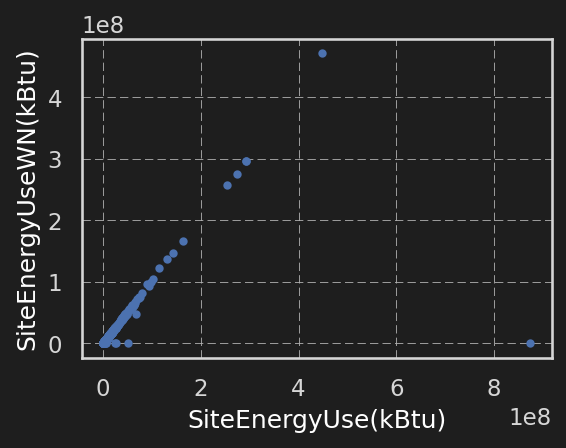

In [51]:
X, Y = 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)'
X, Y = 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)'

x,y = df[[X,Y]].dropna().values.T
lr = linear_model.LinearRegression()
lr.fit( x.reshape(-1,1), y )
print( f'estmated coefficient: {lr.coef_[0]:.3f}' )

fig, ax = plt.subplots( figsize=(10*cm,8*cm))
ax.plot( x, y, 'bo', markersize=3, zorder=2 )
ax.plot( [0,800], [0,800], 'r', zorder=1 )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

Certaines valeurs sont à 0. -> on prend la valeur non WN puisque les valeurs sont proches (pour ce dataset)

In [52]:
sr_loc = (df[Y] == 0.) | (df[Y].isna())
print('nombre de 0 | NaN:', sr_loc.sum())
display( df.loc[sr_loc,:] )
df.loc[sr_loc, Y] = df.loc[sr_loc, X]

nombre de 0 | NaN: 10


OSEBuildingID  AgeOfBuilding(s)    BuildingType  \
220             343                58  nonresidential   
247             372                28  nonresidential   
284             414                87  nonresidential   
350             493                45  nonresidential   
563             757                37  nonresidential   
882           20130               106  nonresidential   
953           20324                16  nonresidential   
3274          49967               116          campus   
3275          49968                47  nonresidential   
3277          49972                18  nonresidential   

              PrimaryPropertyType  \
220                  large office   
247                  large office   
284                  large office   
350   small- and mid-sized office   
563                  large office   
882              worship facility   
953              worship facility   
3274                   university   
3275                   university   
3277                   university   

                                     PropertyName                    Address  \
220                               norton building     801 2nd ave suite 1300   
247                        metropolitan park east          1730 minor avenue   
284               onni 1411 fourth development lp               1411 4th ave   
350                               200 first ave w              200 1st ave w   
563       market place i & ii-2003 western avenue        2003 western avenue   
882            green lake united methodist church            6415 1st ave ne   
953                                temple beth am           2632 ne 80th st.   
3274    university of washington - seattle campus  ne 45th st & brooklyn ave   
3275                                    aerospace      3795 e stevens way ne   
3277  computer science and electrical engineering      3785 e stevens way ne   

         City State  ZipCode TaxParcelIdentificationNumber  \
220   seattle    wa    98104                    0939000355   
247   seattle    wa    98101                    0660002410   
284   seattle    wa    98101                    1975700345   
350   seattle    wa    98119                    1989201020   
563   seattle    wa    98121                    1977200280   
882   seattle    wa    98115                    1257200735   
953   seattle    wa    98115                    1513800009   
3274  seattle    wa    98105                    1625049001   
3275  seattle    wa    98195                    1625049001   
3277  seattle    wa    98195                    1625049001   

      CouncilDistrictCode           Neighborhood  Latitude  Longitude  \
220                     7               downtown  47.60370 -122.33447   
247                     7               downtown  47.61695 -122.32965   
284                     7               downtown  47.60923 -122.33625   
350                     7  magnolia / queen anne  47.62014 -122.35768   
563                     7               downtown  47.61051 -122.34439   
882                     6              northwest  47.67572 -122.32850   
953                     4              northeast  47.68752 -122.29852   
3274                    4              northeast  47.65644 -122.31041   
3275                    4              northeast  47.65395 -122.30584   
3277                    4              northeast  47.65356 -122.30613   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
220        1958                  1              17            378525   
247        1988                  1              20            497513   
284        1929                  1              15            151039   
350        1971                  1               5             88000   
563        1979                  1               7            131143   
882        1910                  1               2             23931   
953        2000                  1               2             31386   
3274       1900           

estmated coefficient: 1.012


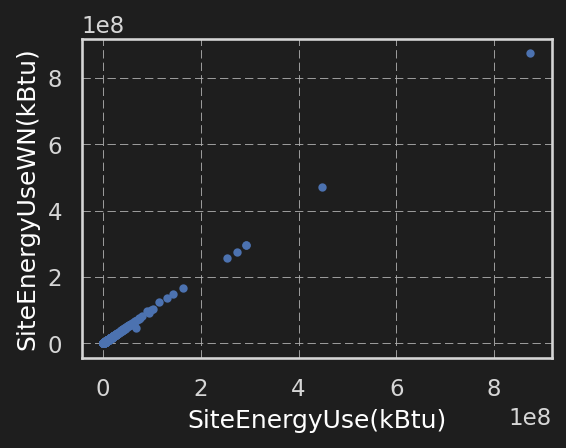

In [53]:
x,y = df[[X,Y]].values.T

x,y = df[[X,Y]].values.T
lr = linear_model.LinearRegression()
lr.fit( x.reshape(-1,1), y )
print( f'estmated coefficient: {lr.coef_[0]:.3f}' )

fig, ax = plt.subplots( figsize=(10*cm,8*cm))
ax.plot( x, y, 'bo', markersize=3, zorder=2 )
ax.plot( [0,800], [0,800], 'r', zorder=1 )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

- `SiteEUI(kBtu/sf)` est basée sur les factures
- `SourceEUI(kbtu/sf)` : "the annual energy used to operate the property, including losses from generation, transmission, & distribution."

estmated coefficient: 2.377


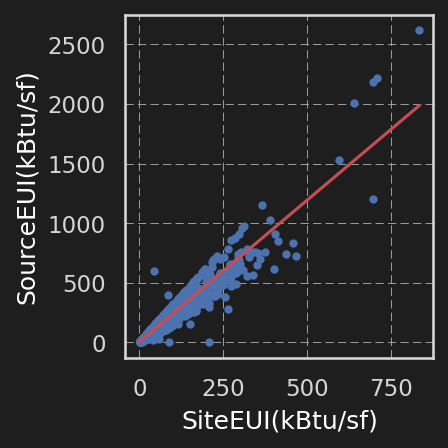

In [54]:
X, Y = 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)'

lr = linear_model.LinearRegression()
lr.fit( df[X].values.reshape(-1,1), df[Y] )
print( f'estmated coefficient: {lr.coef_[0]:.3f}' )

fig, ax = plt.subplots( figsize=(8*cm,8*cm))
ax.plot( df[X], df[Y], 'bo', markersize=3 )

x = np.array([0, df[X].max()]).reshape(2,1)
ax.plot( x, lr.predict(x), 'r' )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

Vérification de conversion kWh -> Btu : OK

estmated coefficient: 3.412, theoretical: 3.412142


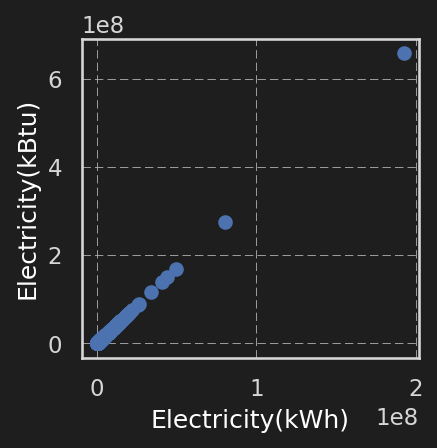

In [55]:
X, Y = 'Electricity(kWh)', 'Electricity(kBtu)'
coef = 3.412142 # in [Btu] / [Wh]

lr = linear_model.LinearRegression()
lr.fit( df[X].values.reshape(-1,1), df[Y] )
print( f'estmated coefficient: {lr.coef_[0]:.3f}, theoretical: {coef:}' )

fig, ax = plt.subplots( figsize=(8*cm,8*cm))
ax.plot( df[X], df[Y], 'bo' )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

vars_to_delete.append( X )

Vérification de conversion therms -> Btu : OK

estmated coefficient: 100.000, theoretical: 100.0


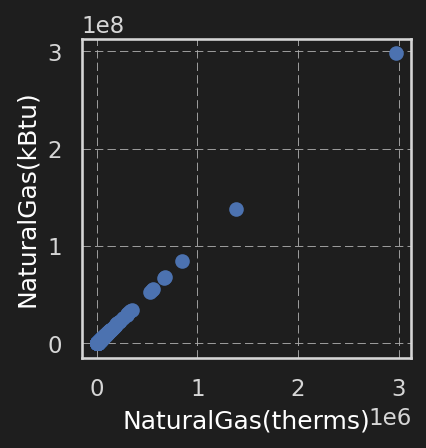

In [56]:
X, Y = 'NaturalGas(therms)', 'NaturalGas(kBtu)'
coef = 1e2 # in [kBtu]/[therms]

lr = linear_model.LinearRegression()
lr.fit( df[X].values.reshape(-1,1), df[Y] )
print( f'estmated coefficient: {lr.coef_[0]:.3f}, theoretical: {coef:}' )

fig, ax = plt.subplots( figsize=(8*cm,8*cm))
ax.plot( df[X], df[Y], 'bo' )
ax.set_xlabel(X)
ax.set_ylabel(Y)
fig.tight_layout()

vars_to_delete.append( X )

Vérification de la somme des ressources utilisées.

`SiteEnergyUse(kBtu)`: The annual amount of energy consumed by the property from all sources of energy.

Certaines valeurs diffèrent mais la proportion semble assez faible.<br>Cette différence est possiblement due à de l'électricity générée par des panneaux solaires par exemple (un bâtiment à une valeur de Electricity négative, une recherche rapide indique qu'il s'agit d'un bâtiments écologique avec des panneaux solaires sur le toit)

Les valeurs 'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)' sont aussi mieux corrélées à la valeur 'SiteEnergyUse(kBtu)' qu'à la valeur WeatherNormalized.

Bulding with negative Electricity:


OSEBuildingID  AgeOfBuilding(s)    BuildingType  \
3206          49784                 3  nonresidential   

              PrimaryPropertyType    PropertyName              Address  \
3206  small- and mid-sized office  bullitt center  1501 e. madison st.   

         City State  ZipCode TaxParcelIdentificationNumber  \
3206  seattle    wa    98122                    7234600195   

      CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
3206                    3      central  47.61432 -122.31257       2013   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3206                  1               6             52000                   0   

      PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
3206                   52000                    office                 office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3206                    48159.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
3206                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
3206                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
3206            100.0               7.1                 5.0   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
3206                 2.0                  -2.1          342726.0938   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
3206            240132.0938             0.0      -33826.80078   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
3206          -115417.0                 0.0               0.0        False   

     ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  \
3206        compliant        0               -0.8                  -0.02   

      YearBuiltCateg  
3206               7

DataFrame shape: (1551, 46)
27 values differs more than 1%
25 values differs more than 30%
3 values corresponds to sum energies > 1.1 * SiteEnergy

Estmated coefficient: 1.075, ideal: 1


OSEBuildingID  AgeOfBuilding(s)    BuildingType  \
206             328                40  nonresidential   
563             757                37  nonresidential   
2441          25661               107  nonresidential   

              PrimaryPropertyType                             PropertyName  \
206                  large office                             1600 seventh   
563                  large office  market place i & ii-2003 western avenue   
2441  small- and mid-sized office                       buttnick city loan   

                   Address     City State  ZipCode  \
206           1600 7th ave  seattle    wa    98191   
563    2003 western avenue  seattle    wa    98121   
2441  206 1st avenue south  seattle    wa    98104   

     TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
206                     0659000165                    7     downtown   
563                     1977200280                    7     downtown   
2441                    5247800380                    7     downtown   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
206   47.61316 -122.33430       1976                  1              33   
563   47.61051 -122.34439       1979                  1               7   
2441  47.60071 -122.33377       1909                  1               3   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
206             791396                   0                  791396   
563             131143               87160                   43983   
2441             47215                   0                   47215   

                              ListOfAllPropertyUseTypes  \
206   lifestyle center, office, other, parking, rest...   
563                                office, retail store   
2441                               office, retail store   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
206                  office                   622034.0   
563                  office                   120248.0   
2441                 office                    23659.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
206                       parking                         132465.0   
563                         store                          10853.0   
2441                        store                          22376.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
206                        other                         33110.0   
563                          NaN                             NaN   
2441                         NaN                             NaN   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
206                  20172015             89.0         60.299999   
563                       NaN             93.0         39.500000   
2441                      NaN             58.0         45.500000   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
206            62.400002          189.500000            195.899994   
563                  NaN          128.000000              0.000000   
2441           46.400002          131.600006            135.100006   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
206            40847752.0             42227404.0             0.0   
563             5177270.5              5177270.5             0.0   
2441            2092696.0              2136896.0             0.0   

      Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
206       1.196941e+07         40839637.0         5382.505371   
563       1.427645e+06          4871126.0        14160.409180   
2441      4.682223e+05          1597575.0         9918.134766   

      NaturalGas(kBtu)  DefaultData ComplianceStatus  Outlier  \
206           538251.0        False        compliant        0   
563          1416041.0        False        compliant        0   
2441          991813.0        False        compliant        0   

   

count          mean           std           min  \
SiteEnergyUse(kBtu)  1551.0  8.859374e+06  3.129079e+07   16808.90039   
sum ressources       1551.0  8.723927e+06  2.901297e+07 -115417.00000   

                           25%         50%         75%          max  
SiteEnergyUse(kBtu)  1238203.5  2717863.25  7298149.25  873923712.0  
sum ressources       1233459.5  2686765.00  7269166.00  742059629.0

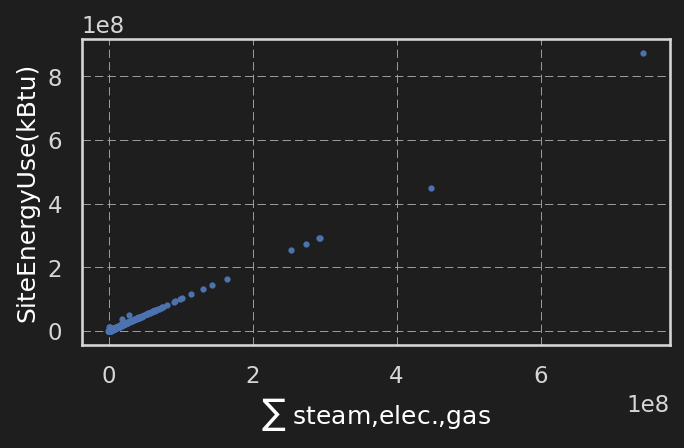

In [57]:
energies = ['Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']
X, Y = energies, 'SiteEnergyUse(kBtu)'

X_values = df[X].sum(1)
diff = X_values - df[Y]
diff_ratio = diff / df[Y].abs() * 100


print('Bulding with negative Electricity:')
display(df.loc[df['Electricity(kBtu)'] < 0 , :] )

print('DataFrame shape:', df.shape)
print('{:} values differs more than 1%'.format( (diff_ratio.abs() > 0.01).sum() ))

print('{:} values differs more than 30%'.format( (diff_ratio.abs() > 0.3).sum() ))
print('{:} values corresponds to sum energies > 1.1 * SiteEnergy'.format( (diff_ratio > 0.1).sum() ))

lr = linear_model.LinearRegression()
lr.fit( X_values.values.reshape(-1,1), df[Y].values )
print( f'\nEstmated coefficient: {lr.coef_[0]:.3f}, ideal: {1:}' )

display( df.loc[ diff_ratio > 0.1, :] )

display( pd.DataFrame( {Y:df[Y], 'sum ressources':X_values} ).describe().T )

fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( X_values, df[Y], 'bo', markersize=2 )
ax.set_xlabel(r'$\sum$ steam,elec.,gas')
ax.set_ylabel(Y)

# ax_twinx = ax.twinx()
# ax_twinx.plot( X_values, diff_ratio, 'ro', markersize=4 )
# ax_twinx.set_ylabel('difference (%)', color='r')

fig.tight_layout()

DataFrame shape: (1551, 46)
1238 values differs more than 30%
67 values corresponds to sum energies > 1.1 * SiteEnergy

Estmated coefficient: 1.088, ideal: 1


count          mean           std       min  \
SiteEnergyUseWN(kBtu)  1551.0  9.079188e+06  3.166283e+07   17260.0   
sum ressources         1551.0  8.723927e+06  2.901297e+07 -115417.0   

                                25%        50%         75%          max  
SiteEnergyUseWN(kBtu)  1.322090e+06  2830649.5  7581597.75  873923712.0  
sum ressources         1.233460e+06  2686765.0  7269166.00  742059629.0

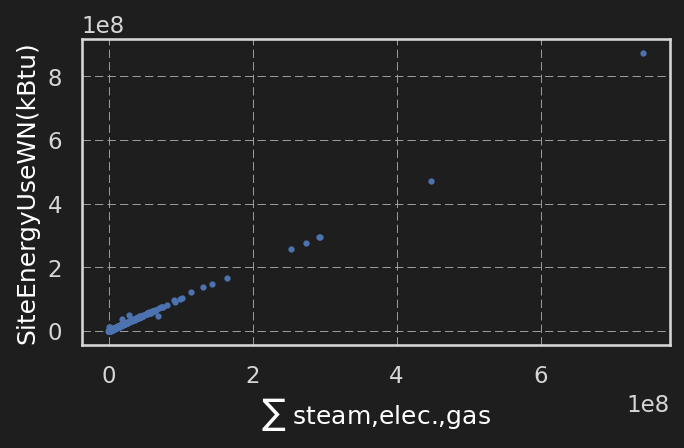

In [58]:
energies = ['Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']
X, Y = energies, 'SiteEnergyUseWN(kBtu)'

X_values = df[X].sum(1)
diff = X_values - df[Y]
diff_ratio = diff / df[Y].abs() * 100

print('DataFrame shape:', df.shape)
print('{:} values differs more than 30%'.format( (diff_ratio.abs() > 0.3).sum() ))
print('{:} values corresponds to sum energies > 1.1 * SiteEnergy'.format( (diff_ratio > 0.1).sum() ))

lr = linear_model.LinearRegression()
lr.fit( X_values.values.reshape(-1,1), df[Y].values )
print( f'\nEstmated coefficient: {lr.coef_[0]:.3f}, ideal: {1:}' )

display( pd.DataFrame( {Y:df[Y], 'sum ressources':X_values} ).describe().T )

fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( X_values, df[Y], 'bo', markersize=2 )
ax.set_xlabel(r'$\sum$ steam,elec.,gas')
ax.set_ylabel(Y)

# ax_twinx = ax.twinx()
# ax_twinx.plot( X_values, diff_ratio, 'ro', markersize=4 )
# ax_twinx.set_ylabel('difference (%)', color='r')

fig.tight_layout()

On regarde à quoi correspondent les surfaces

Il y a clairement des incohérences entre les `LargestPropertyUseTypeGFA` et (`PropertyGFATotal`, `PropertyGFABuilding(s)`, `PropertyGFAParking`, `NumberofFloors`)

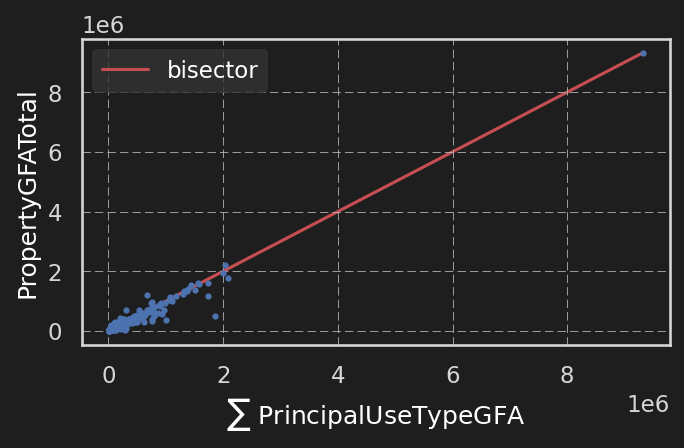

In [59]:
x = df[['LargestPropertyUseTypeGFA',
        'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseTypeGFA']].fillna(0.).sum(1)


Y = 'PropertyGFATotal'
y = df[Y]


fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( x, y, 'bo', markersize=2 )
ax.plot( [0, y.max()], [0, y.max()], 'r', zorder=0, label='bisector' )
ax.legend()
ax.set_xlabel(r'$\sum$ PrincipalUseTypeGFA')
ax.set_ylabel(Y)

fig.tight_layout()

On regarde la cohérence entre le SiteEnergyUseWN(kBtu/sf) et le SiteEUIWN(kBtu/sf):
- la surface utilisée pour calculer le SiteEUIWN semble être plus proche de la somme des GFA use tye
- comme on souhaite modéliser la consommation et les émissiones `totales`, les variables surfaciques seront recalculée à partir du GFABuilding(s)

['OSEBuildingID', 'AgeOfBuilding(s)', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'YearBuiltCateg']


count       mean        std       min        25%  \
SiteEUIWN(kBtu/sf)  1550.0  77.415032  76.782471  0.000000  36.599998   
re-calculated       1551.0  73.342424  77.644939  0.417628  33.768819   

                          50%        75%         max  
SiteEUIWN(kBtu/sf)  56.099998  87.775002  834.400024  
re-calculated       51.322614  82.617785  953.072956

count       mean        std       min        25%  \
SiteEUI(kBtu/sf)  1551.0  74.990135  75.762906  0.700000  34.599998   
re-calculated     1551.0  70.498604  76.180216  0.417628  31.459200   

                        50%        75%         max  
SiteEUI(kBtu/sf)  53.599998  84.899998  834.400024  
re-calculated     48.314511  78.032040  906.130957

count       mean        std       min        25%  \
SiteEUIWN(kBtu/sf)  1550.0  77.415032  76.782471  0.000000  36.599998   
re-calculated       1551.0  73.276198  72.833930  0.698305  33.809481   

                          50%        75%         max  
SiteEUIWN(kBtu/sf)  56.099998  87.775002  834.400024  
re-calculated       52.749482  83.469878  834.402500

count       mean        std       min        25%  \
SiteEUI(kBtu/sf)  1551.0  74.990135  75.762906  0.700000  34.599998   
re-calculated     1551.0  70.468813  71.755156  0.680054  31.565778   

                        50%        75%         max  
SiteEUI(kBtu/sf)  53.599998  84.899998  834.400024  
re-calculated     50.118335  79.660529  834.402500

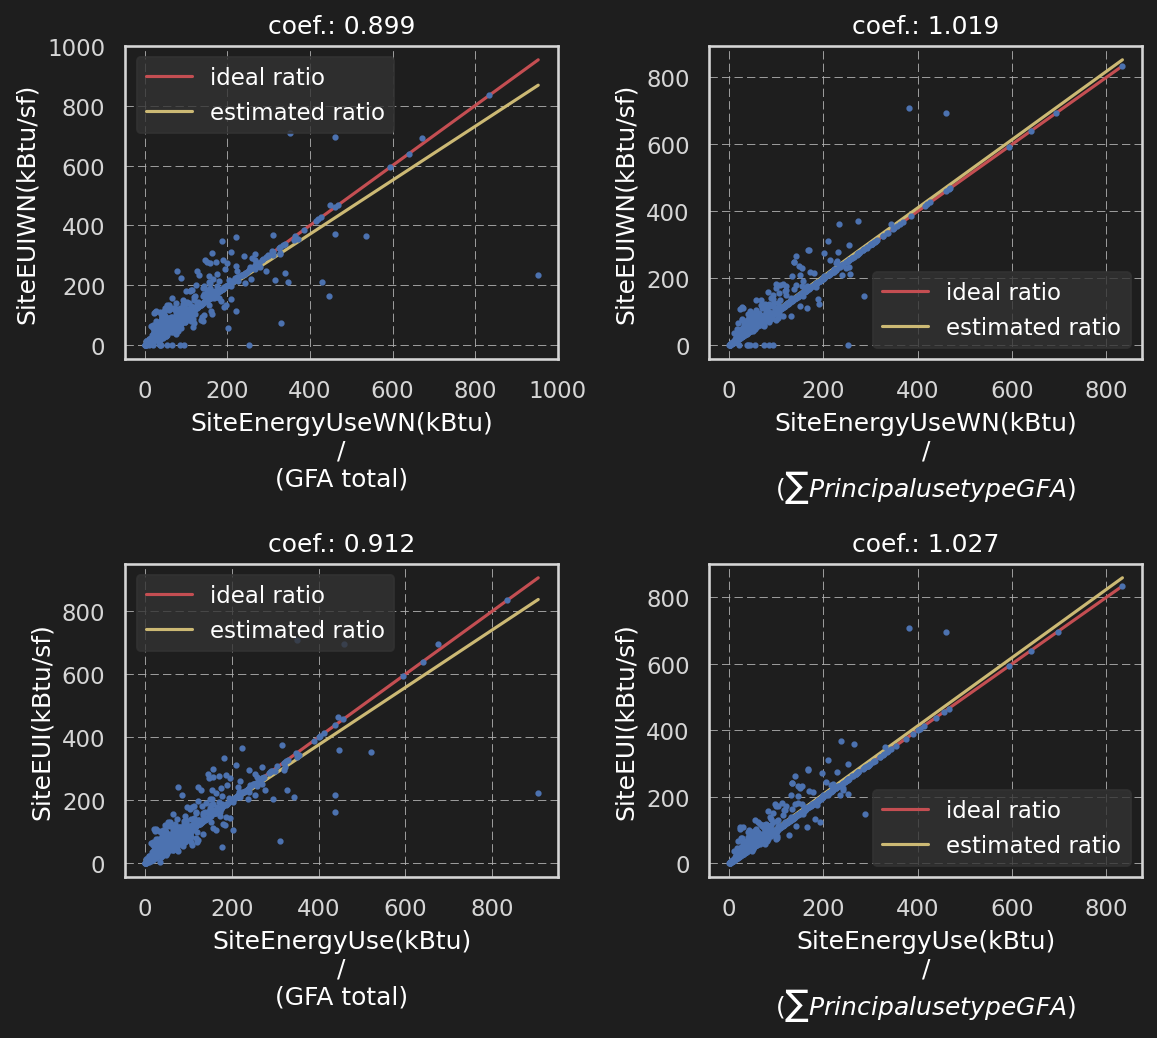

In [60]:
print( df.keys().tolist())
fig, axs = plt.subplots( ncols=2,nrows=2, figsize=(20*cm,18*cm))

for i, (srfc, srfc_label) in enumerate( zip( [y,x], ['GFA total', r'$\sum Principal use type GFA$'] ) ):
    for j, (X,Y) in enumerate([ ('SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)'), ('SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)')]) :
        ax = axs[j][i]
        # X_values = df[X] / y
        X_values = df[X] / srfc
        diff = X_values - df[Y]

        sr_drop = (X_values.isna()) | ( df[Y].isna())

        lr = linear_model.LinearRegression()
        lr.fit( X_values.loc[~sr_drop].values.reshape(-1,1), df.loc[~sr_drop, Y] )
        # print( f'\nEstmated coefficient: {lr.coef_[0]:.3f}, ideal: {1:}' )

        display( pd.DataFrame( {Y:df[Y], 're-calculated':X_values} ).describe().T )

        ymax = df[Y].max()
        xmax = X_values.max()
        ax.set_title( f'coef.: {lr.coef_[0]:.3f}' )
        ax.plot( [0,xmax], [0,xmax], 'r', label='ideal ratio' )
        ax.plot( [0,xmax], lr.predict( np.array([0,xmax]).reshape(-1,1) ), 'y', label='estimated ratio' )
        ax.plot( X_values, df[Y], 'bo', markersize=2 )
        ax.set_xlabel( X + f'\n/\n({srfc_label})')
        ax.set_ylabel(Y)
        ax.legend()

        # ax_twinx = ax.twinx()
        # ax_twinx.plot( X_values, np.abs(diff) / X_values * 100, 'ro', markersize=4 )
        # ax_twinx.set_ylabel('difference (%)', color='r')

        fig.tight_layout()

In [61]:
vars_to_delete += df.columns[df.columns.str.contains('/sf|Intensity')].tolist()

OSEBuildingID  AgeOfBuilding(s)    BuildingType    PrimaryPropertyType  \
1279          21435                55  nonresidential                  other   
3171          49709                 4  nonresidential                  other   
558             753                35  nonresidential                  other   
809           19900                90  nonresidential             laboratory   
309             440                15  nonresidential     mixed use property   
3203          49780                41  nonresidential                  other   
2380          25452                28  nonresidential     mixed use property   
240             365                47  nonresidential                  other   
35               43                24          campus     mixed use property   
1109          20885                50  nonresidential  senior care community   

                          PropertyName                  Address     City  \
1279                      space needle        400 broard street  seattle   
3171  seattle procure management, llc.  1570 north 115th street  seattle   
558                     westinbuilding             2001 6th ave  seattle   
809                  3000/3018 western        3018 western ave.  seattle   
309       fisher plaza - west building            100 4th ave n  seattle   
3203      2020 fifth avenue dat center        2020 fifth avenue  seattle   
2380            chandler's cove - sedo     901 fairview ave. n.  seattle   
240               uw tower data center     4333 brooklyn ave ne  seattle   
35                        plant 2 site    7755 e marginal way s  seattle   
1109                    ballard center       820 nw 95th street  seattle   

     State  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
1279    wa    98109                    1985200495                    7   
3171    wa    98013                    3026049128                    5   
558     wa    98121                    0659000950                    7   
809     wa    98121                    0695000090                    7   
309     wa    98109                    1991200170                    7   
3203    wa    98121                    0659000905                    7   
2380    wa    98109                    4088803045                    3   
240     wa    98185                    1142000290                    4   
35      wa    98108                    0022000005                    2   
1109    wa    98117                    1865400030                    6   

               Neighborhood  Latitude  Longitude  YearBuilt  \
1279  magnolia / queen anne  47.62049 -122.34930       1961   
3171              northwest  47.71286 -122.33635       2012   
558                downtown  47.61438 -122.33871       1981   
809                downtown  47.61763 -122.35507       1926   
309              lake union  47.61915 -122.34857       2001   
3203               downtown  47.61449 -122.33956       1975   
2380             lake union  47.62774 -122.33384       1988   
240               northeast  47.66060 -122.31512       1969   
35         greater duwamish  47.53493 -122.31788       1992   
1109                ballard  47.69875 -122.36725       1966   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
1279                  1               2             33971                   0   
3171                  1               2             53575                   0   
558                   1              33            429405                   0   
809                   1               4             49249                   0   
309                   1               6            213834              104922   
3203                  1               7             90679               35120   
2380                  1               2             34639               15402   
240                   1               5             36000                   0   
35                    1               3           

Text(0.5, 0, 'SiteEnergyUseWN / GFA Buildind(s) (kBtu/sf)')

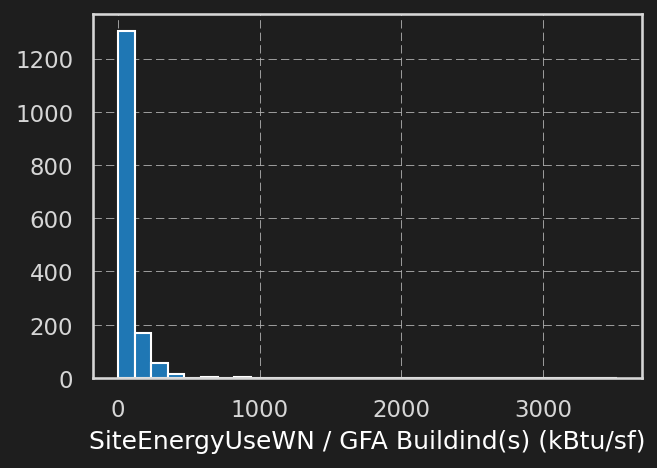

In [62]:
x,y = df[['PropertyGFABuilding(s)', 'SiteEnergyUseWN(kBtu)']].values.T

values = y / x

# affichage des valeurs élevée
display( df.iloc[ values.argsort()[-10:] , : ] )


fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.hist( y/x, bins=30 )
ax.set_xlabel( 'SiteEnergyUseWN / GFA Buildind(s) (kBtu/sf)')

On prend la valeur "Weather Normalize".

Le TotalGHGEmissions est calculé en utilisant :
> - Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available.
> - Enwave steam factor = 170.17 lbs CO2e/MMBtu.
> - Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.

La variables `TotalGHGEmissions` est exprimée en `metric tons of carbon dioxide equivalent`.

Estimer cette variable revient à estimer l'`énergie consommée` connaissant les `proportions d'énergies utilisée`.

estimated coefficient: 1.000e+00


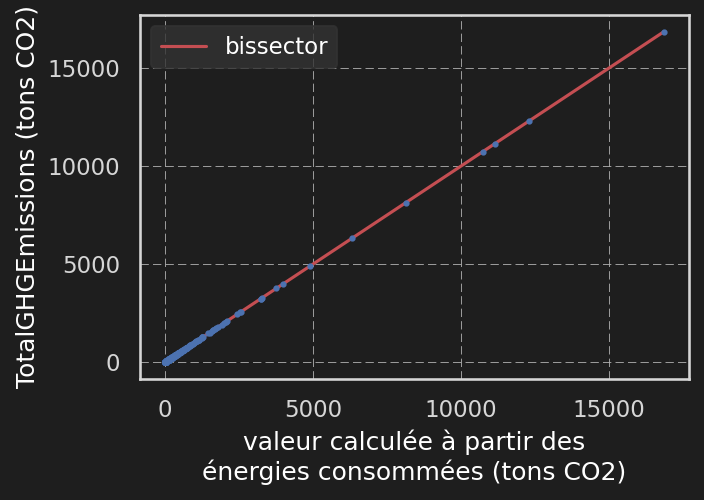

In [63]:
y = df['TotalGHGEmissions']

def energies_to_emissions( elec_kBtu, steam_kBtu, gas_kBtu):
    return 1e-3 *( # conversion kg->tons
            0.4535924*( # conversion lbs-> kg
                (52.44e-3/3.412142) * elec_kBtu # conversion kBtu->kWh->lbs
                + 170.17e-3 * steam_kBtu) # conversion kBtu->lbs
                + 53.11e-3 * gas_kBtu ) # coonversion kBtu->kg

# x =  0.4535924*(52.44e-3 * df['Electricity(kWh)'] + 170.17e-3 * df['SteamUse(kBtu)']) + 53.11e-3 * df['NaturalGas(kBtu)']
# x = x*0.001 # conversion en tonne

# x = df[energies].values.T*1e-3

x = energies_to_emissions( *(df[energies].values.T) )

lr = linear_model.LinearRegression()
lr.fit( x.reshape(-1,1), y )
print('estimated coefficient: {:.3e}'.format( lr.coef_[0]))

vmax = max( x.max(), y.max() )
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( [0, vmax], [0, vmax], 'r', label='bissector')
ax.plot( x, y, 'bo', markersize=2 )
ax.set_xlabel( 'valeur calculée à partir des\nénergies consommées (tons CO2)')
ax.set_ylabel( 'TotalGHGEmissions (tons CO2)')
ax.legend()

Avec la valeur `WeatherNormalized` pour le  `SiteEnergyUse` calculer la valeur `WeatherNormalized` pour le `TotalGHGEmissions` sera plus coherent (voir section Feature des modèles).

In [64]:
targets = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [65]:
df[targets].info()

for target in targets:
    sr_0 = (df[target] == 0) | (df[target].isna())
    print( f'\nnumber of elements {target} == 0 | isna:', (sr_0).sum())
# display( df.loc[sr_0,:])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1551 entries, 0 to 3375
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SiteEnergyUseWN(kBtu)  1551 non-null   float64
 1   TotalGHGEmissions      1551 non-null   float64
dtypes: float64(2)
memory usage: 68.6 KB

number of elements SiteEnergyUseWN(kBtu) == 0 | isna: 0

number of elements TotalGHGEmissions == 0 | isna: 1


Des emissions sont à 0, ce qui n'est pas cohérent

In [66]:
df.loc[sr_0,:]

OSEBuildingID  AgeOfBuilding(s)    BuildingType  \
513            700                 8  nonresidential   

             PrimaryPropertyType               PropertyName  \
513  supermarket / grocery store  iuc- whole foods interbay   

                   Address     City State  ZipCode  \
513  2001 15th avenue west  seattle    wa    98119   

    TaxParcelIdentificationNumber  CouncilDistrictCode           Neighborhood  \
513                    7666201460                    7  magnolia / queen anne   

     Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
513  47.63718 -122.37734       2008                  1               1   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
513             57176                   0                   57176   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
513  personal services (health/beauty, dry cleaning...                  store   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
513                    39500.0                        store   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
513                          15000.0                    services   

     ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
513                          5500.0                      NaN             31.0   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
513        208.800003          214.100006                 0.0   

     SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
513                   0.0           12525174.0             12843856.0   

     SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
513             0.0               0.0                0.0                 0.0   

     NaturalGas(kBtu)  DefaultData ComplianceStatus  Outlier  \
513               0.0        False        compliant        0   

     TotalGHGEmissions  GHGEmissionsIntensity  YearBuiltCateg  
513                0.0                    0.0               7

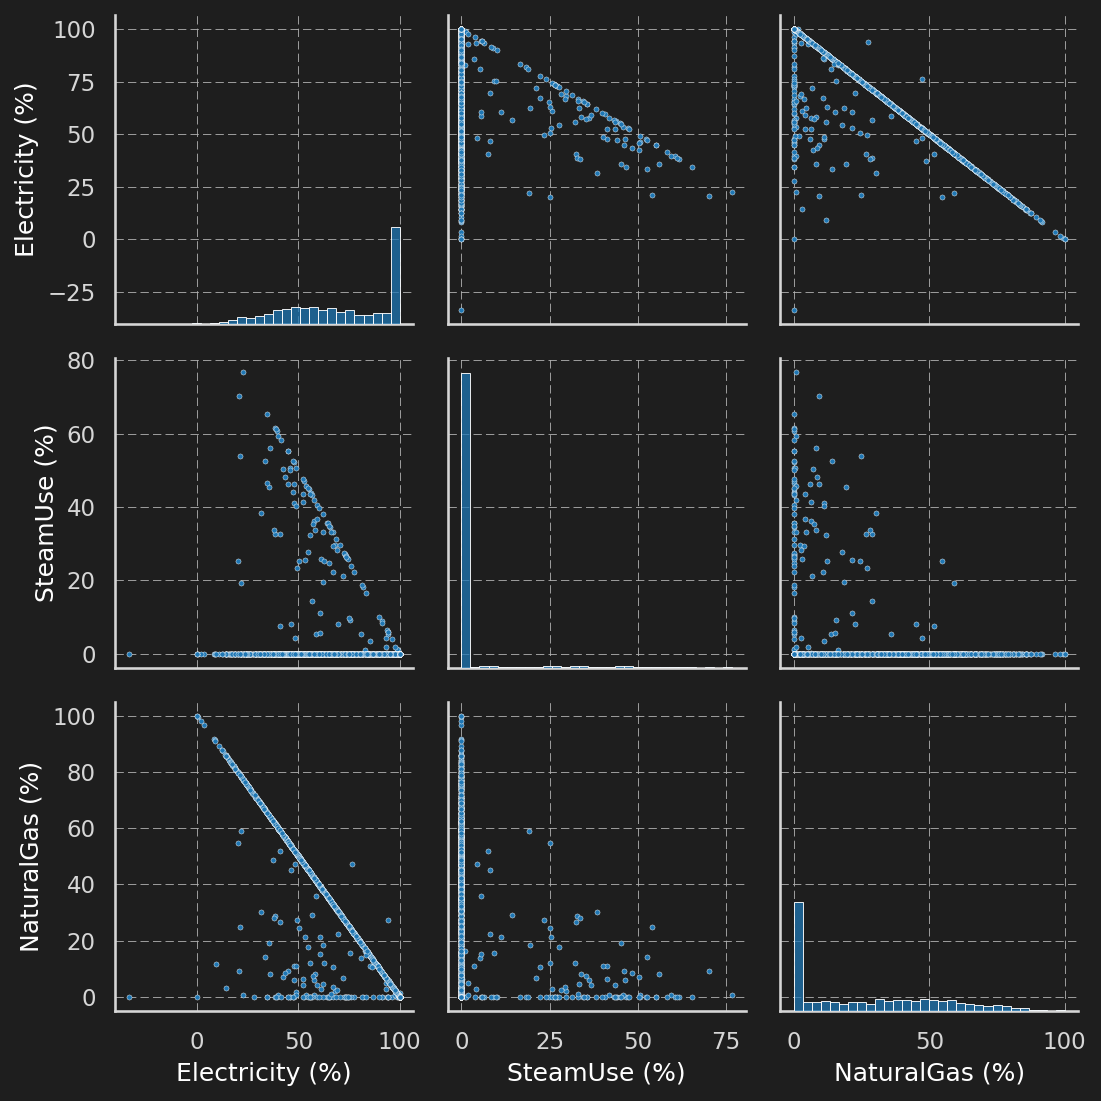

In [67]:
tmp = df[energies].copy()
for X in energies:
    tmp[X] = 100* tmp[X] / df['SiteEnergyUse(kBtu)']
    tmp.rename( columns={X:X[:-6] + ' (%)'}, inplace=True)
    
g = sns.pairplot( data=tmp, plot_kws={'s':6}, diag_kws={'bins':30} )
# g.legend(bbox_to_anchor= (1.03, 1) )
# handles = g._legend_data.values()
# labels = g._legend_data.keys()
# g.fig.legend(handles=handles, labels=labels, loc=[0.35,0.65], ncol=1)
# g.legend.remove()
# g.fig.suptitle('log values')
g.fig.tight_layout()

Statistiquement, la valeur manquante est fort probablement Electrique

In [68]:
df.loc[sr_0,'Electricity(kBtu)'] = df.loc[sr_0,'SiteEnergyUse(kBtu)']
df.loc[sr_0,'TotalGHGEmissions'] = energies_to_emissions( *( df.loc[sr_0, energies].values.T ))

df.loc[sr_0,:]

OSEBuildingID  AgeOfBuilding(s)    BuildingType  \
513            700                 8  nonresidential   

             PrimaryPropertyType               PropertyName  \
513  supermarket / grocery store  iuc- whole foods interbay   

                   Address     City State  ZipCode  \
513  2001 15th avenue west  seattle    wa    98119   

    TaxParcelIdentificationNumber  CouncilDistrictCode           Neighborhood  \
513                    7666201460                    7  magnolia / queen anne   

     Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
513  47.63718 -122.37734       2008                  1               1   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
513             57176                   0                   57176   

                             ListOfAllPropertyUseTypes LargestPropertyUseType  \
513  personal services (health/beauty, dry cleaning...                  store   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
513                    39500.0                        store   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
513                          15000.0                    services   

     ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
513                          5500.0                      NaN             31.0   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
513        208.800003          214.100006                 0.0   

     SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
513                   0.0           12525174.0             12843856.0   

     SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
513             0.0               0.0         12525174.0                 0.0   

     NaturalGas(kBtu)  DefaultData ComplianceStatus  Outlier  \
513               0.0        False        compliant        0   

     TotalGHGEmissions  GHGEmissionsIntensity  YearBuiltCateg  
513          87.314249                    0.0               7

count    1.551000e+03
mean     9.079188e+06
std      3.166283e+07
min      1.726000e+04
25%      1.322090e+06
50%      2.830650e+06
75%      7.581598e+06
max      8.739237e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

count     1551.000000
mean       193.096702
std        778.407004
min         -0.800000
25%         20.110000
50%         49.730000
75%        147.315000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

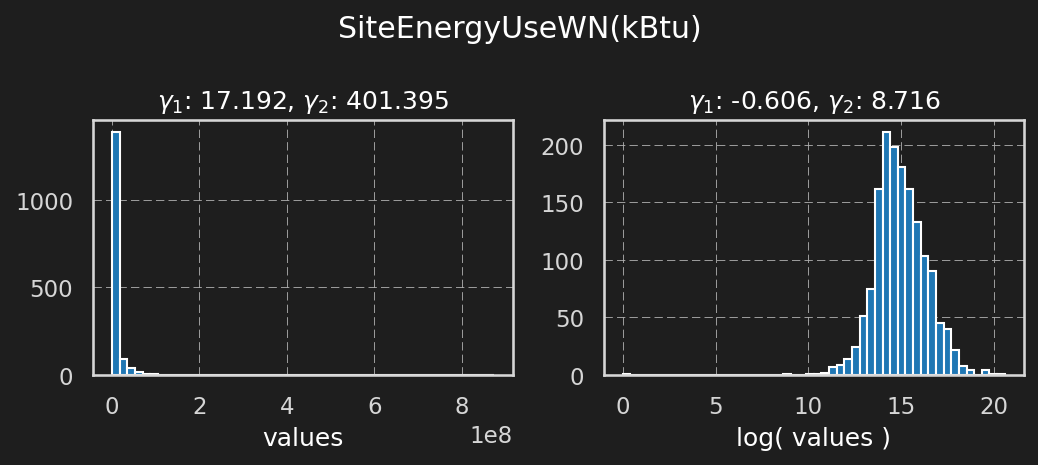

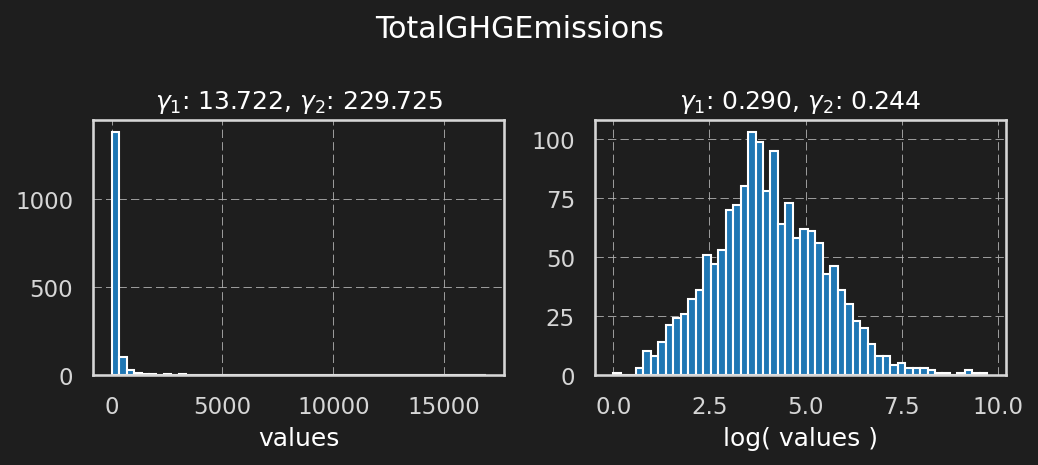

In [69]:
# power_inv_targets = [6, 6]
# for target, power_inv in zip( targets, power_inv_targets ):
for target in targets:
    y = df[target].dropna()

    display( y.describe() )

    # y_pow = (y+1.-y.min())**(1/power_inv)

    # print( ( y + (1-y.min()) ).min() )
    y_log = np.log( y + (1-y.min() ) )


    fig, axs = plt.subplots( ncols=2, figsize=(18*cm,8*cm) )
    n, bins, _ = axs[0].hist( y, bins=50 )
    n, bins, _ = axs[1].hist( y_log, bins=50 )
    # n, bins, _ = axs[2].hist( y_pow, bins=50 )
    axs[0].set_xlabel( 'values' )
    axs[1].set_xlabel( f'log( values )' )
    # axs[2].set_xlabel( f'values ** (1/{power_inv})' )

    axs[0].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y), st.kurtosis(y) ) )
    axs[1].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_log), st.kurtosis(y_log) ) )
    # axs[2].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_pow), st.kurtosis(y_pow) ) )

    fig.suptitle( target )
    fig.tight_layout()

    log_target_bins_center = (bins[:-1] + bins[1:]) * 0.5 

Il est probablement plus intéressant d'estimer le SiteEnergyUse(kBtu) divisé par le PropertyGFABuilding(s).<br>
Le feature engineering est à adapté en conséquence.

count    1551.000000
mean       82.428161
std       121.925458
min         0.417628
25%        36.635641
50%        56.094789
75%        89.734135
max      3521.922717
dtype: float64

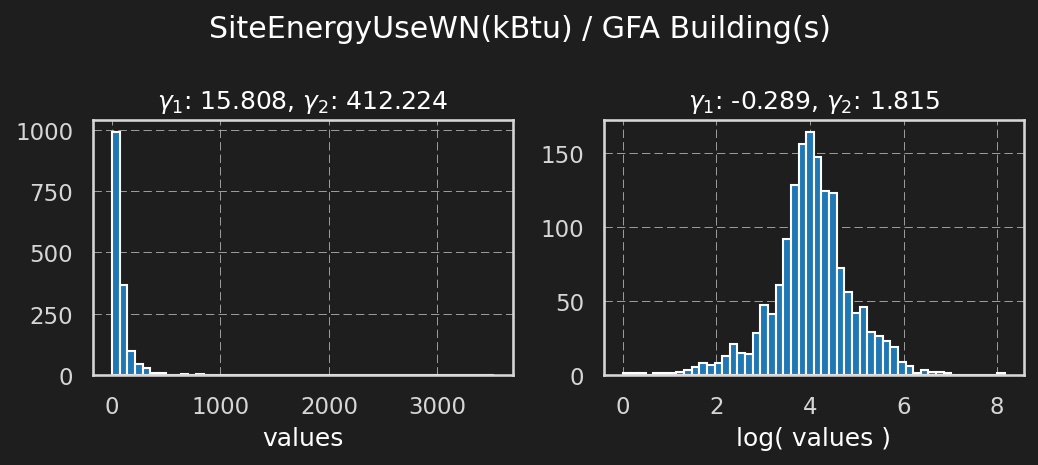

In [70]:
y = df[targets[0]] / df['PropertyGFABuilding(s)']
y_label = targets[0] + ' / GFA Building(s)'

display( y.describe() )

y_log = np.log( y + (1-y.min() ) )


fig, axs = plt.subplots( ncols=2, figsize=(18*cm,8*cm) )
n, bins, _ = axs[0].hist( y, bins=50 )
n, bins, _ = axs[1].hist( y_log, bins=50 )
# n, bins, _ = axs[2].hist( y_pow, bins=50 )
axs[0].set_xlabel( 'values' )
axs[1].set_xlabel( f'log( values )' )
# axs[2].set_xlabel( f'values ** (1/{power_inv})' )

axs[0].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y), st.kurtosis(y) ) )
axs[1].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_log), st.kurtosis(y_log) ) )
# axs[2].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_pow), st.kurtosis(y_pow) ) )

fig.suptitle( y_label )
fig.tight_layout()

log_target_bins_center = (bins[:-1] + bins[1:]) * 0.5 

## 4.2 Scatter plots

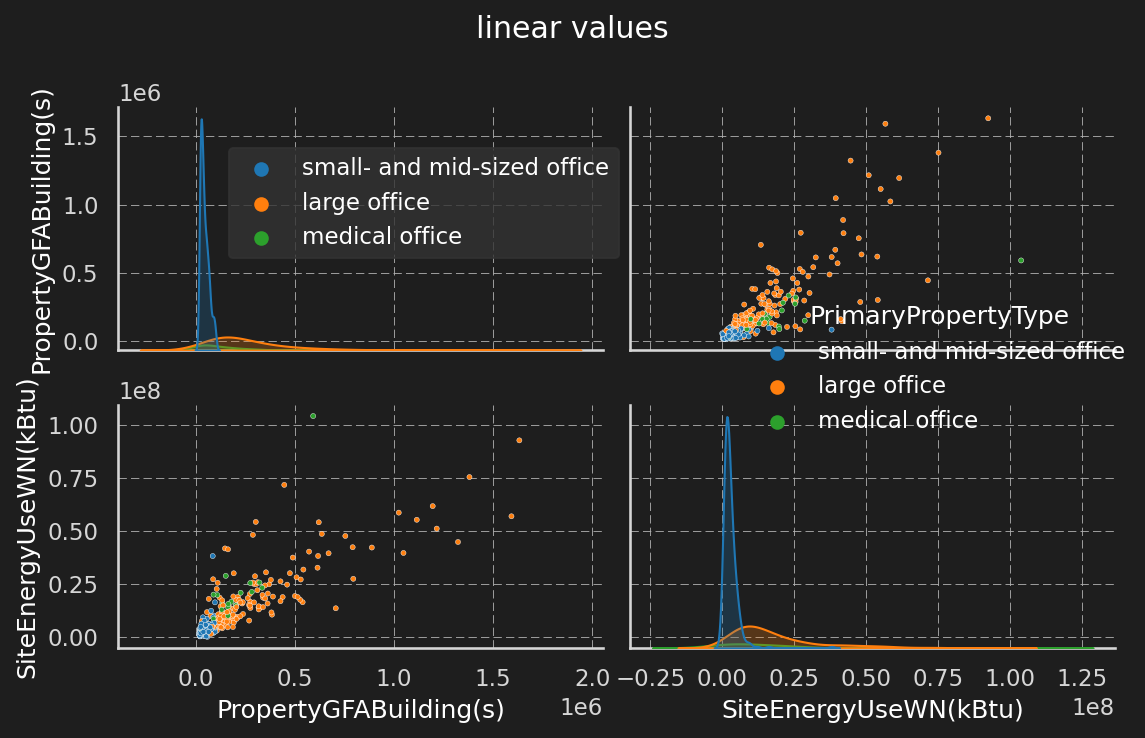

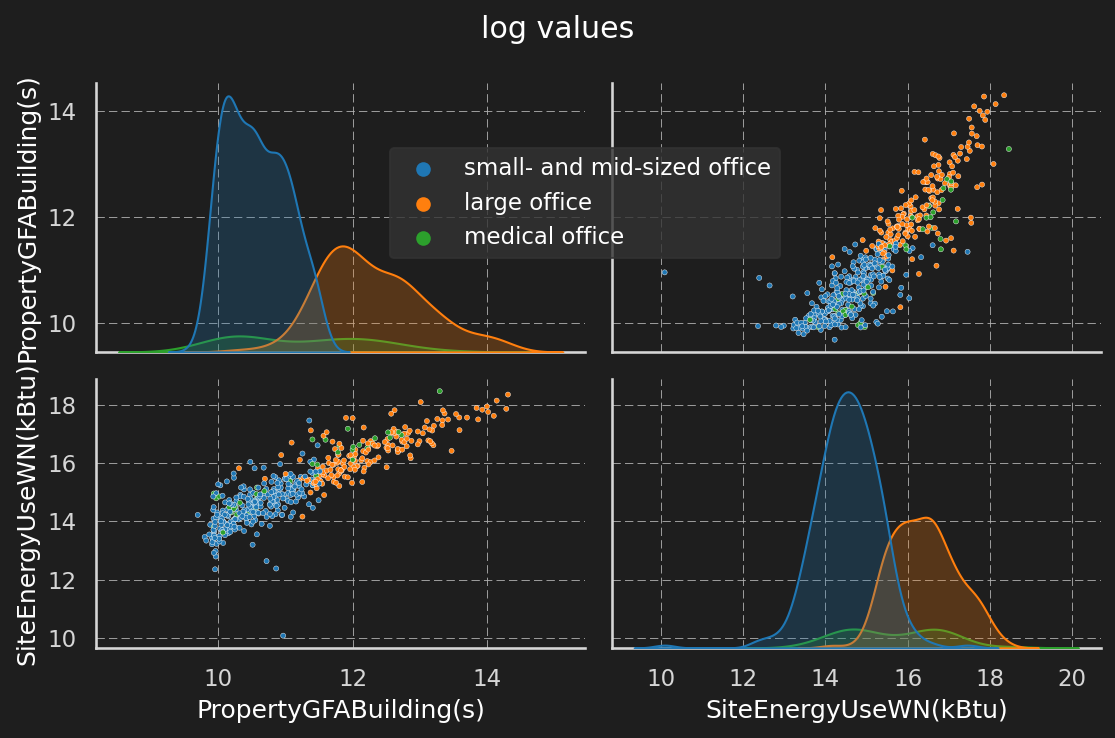

In [71]:

Xs = ['PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA']
hues = ['PrimaryPropertyType', 'LargestPropertyUseType']

# df[target]

Y = targets[0]

sr_loc = (df[Y] != 0)
for X in Xs:
    sr_loc = sr_loc & (df[X]!=0)
tmp = df.loc[sr_loc, Xs + hues + [Y, 'Outlier']]
# tmp = df[[X,target, 'Outlier', hue]]

if True:
    # tmp[ Xs[1] ] /= tmp[ Xs[0] ]
    # sr_loc = tmp[Xs[1]] > 0.7
    sr_loc = tmp[hues[0]].str.contains('office')
    tmp = tmp.loc[sr_loc,:]


for X,hue in zip( Xs, hues ):
    g = sns.pairplot( data=tmp, vars=[X,Y], hue=hue,
        plot_kws={'s':6} )
    
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc=[0.2,0.65], ncol=1)

    g.fig.suptitle('linear values')
    g.fig.tight_layout()
    

    tmp[X] = np.log( tmp[X] )
    tmp[Y] = np.log( tmp[Y] )
    g = sns.pairplot( data=tmp, vars=[X,Y], hue=hue,
        plot_kws={'s':6} )
    # g.legend(bbox_to_anchor= (1.03, 1) )
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc=[0.35,0.65], ncol=1)
    g.legend.remove()
    g.fig.suptitle('log values')
    g.fig.tight_layout()
    
    break

Le PropertyGFABuilding(s) est fortement corrélé au SiteEnergyUseWN(kBtu) pour les offices.
Les gorupes sont différents puisque les GFA sont différents.

In [72]:
def ANOVA( df, hue, Y, transform=None ):
    groups = df[[Y,hue]].dropna().groupby(hue)[Y]
    index = pd.MultiIndex.from_tuples( [('shape','skew'), ('shape','kurtosis'),('shapiro','statistic'), ('shapiro','p-value')] )
    df_shape = pd.DataFrame( index = index)
    names = [name for name,yi in groups]
    for name, yi in groups:
        if not transform is None:
            yi = transform( yi )
        # print('\nname:', name)
        # print( st.skew(yi) )
        # print( st.kurtosis(yi) )
        # print( st.shapiro(yi) )
        # sr = pd.Series( [  ] ).astype(float)
        shapiro = st.shapiro(yi)
        df_shape[name] = [st.skew(yi), st.kurtosis(yi), shapiro.statistic, shapiro.pvalue]
    
    print(f'ANOVA on variable {Y}')
    print('p-value is the probability to have found a particular set of observations if the null hypothesis were true (valid if p-value is high)')
    print('Shapiro null hypothesis: data has a normal distribution')
    display(df_shape.round(3))

    levene = pg.homoscedasticity( df.dropna(), dv=Y, group=hue )
    print( 'small p-value suggests that the populations do not have equal variances' )
    display( levene )

    # tpl = tuple( [df.query( f'{hue} == "{name}"')[Y].dropna() for name in names ] )
    # print( st.levene( *tpl ) )
    

    print('small p-value suggests that there is a statistically significant difference between the means of groups')
    display( pg.pairwise_tukey( dv=Y, between=hue, data=df.dropna() ) )

    # for i, (name,yi) in enumerate(groups):
    #     print('\n\n| {:} |\n\n'.format( '-'*20 ))
    #     if i+1 == len(names):
    #         break
    #     print(f'name: {name}')
    #     for j, (name_2,yi2) in enumerate(groups):
    #         if j <= i:
    #             continue
    #         print( f'\n{name} - {name_2}:' )
    #         stat, p = st.levene(yi, yi2)
    #         print( f'levene stat: {stat:.3f}, p-value: {p:.3f}' )
    #         print('std: {:.3f} - {:.3f}'.format( yi.std(), yi2.std() ) )

mask = 'SiteEnergyUseWN / GFA Building(s)(kBtu/sf)'
tmp[mask] = df[targets[0]] / df['PropertyGFABuilding(s)']
print('LINEAR VALUES')
ANOVA( tmp, 'PrimaryPropertyType', mask )
print('LOG VALUES')
ANOVA( tmp, 'PrimaryPropertyType', mask, lambda y:np.log( y + (1-y.min())) )

LINEAR VALUES
ANOVA on variable SiteEnergyUseWN / GFA Building(s)(kBtu/sf)
p-value is the probability to have found a particular set of observations if the null hypothesis were true (valid if p-value is high)
Shapiro null hypothesis: data has a normal distribution


large office  medical office  small- and mid-sized office
shape   skew              2.837           1.495                        4.010
        kurtosis          8.610           1.776                       27.049
shapiro statistic         0.659           0.839                        0.688
        p-value           0.000           0.000                        0.000

small p-value suggests that the populations do not have equal variances


W      pval  equal_var
levene  0.384495  0.680997       True

small p-value suggests that there is a statistically significant difference between the means of groups


A                            B    mean(A)    mean(B)  \
0    large office               medical office  70.295565  92.000754   
1    large office  small- and mid-sized office  70.295565  62.119630   
2  medical office  small- and mid-sized office  92.000754  62.119630   

        diff        se         T   p-tukey    hedges  
0 -21.705190  7.876515 -2.755684  0.016691 -0.453171  
1   8.175935  4.276877  1.911660  0.136420  0.182984  
2  29.881125  7.576090  3.944136  0.000270  0.712262

LOG VALUES
ANOVA on variable SiteEnergyUseWN / GFA Building(s)(kBtu/sf)
p-value is the probability to have found a particular set of observations if the null hypothesis were true (valid if p-value is high)
Shapiro null hypothesis: data has a normal distribution


large office  medical office  small- and mid-sized office
shape   skew              -0.63          -1.873                       -1.143
        kurtosis           4.56           6.734                        9.424
shapiro statistic          0.92           0.841                        0.902
        p-value            0.00           0.000                        0.000

small p-value suggests that the populations do not have equal variances


W      pval  equal_var
levene  0.384495  0.680997       True

small p-value suggests that there is a statistically significant difference between the means of groups


A                            B    mean(A)    mean(B)  \
0    large office               medical office  70.295565  92.000754   
1    large office  small- and mid-sized office  70.295565  62.119630   
2  medical office  small- and mid-sized office  92.000754  62.119630   

        diff        se         T   p-tukey    hedges  
0 -21.705190  7.876515 -2.755684  0.016691 -0.453171  
1   8.175935  4.276877  1.911660  0.136420  0.182984  
2  29.881125  7.576090  3.944136  0.000270  0.712262

Les "large office" et "small- and mid-sized office" semblent correspondrent à une consommation par unité de surface similaires, mais les "medial offices" semble être différents.

><span style="color:orange"> Note: </span>
> - Les p-value des test shapiro indiquent bien que les valeurs ne sont pas de distribution normale
> - le test de levene indiquent que les variances sont suffisamment semblables

***
# Features des modèles

## Suppression des variables non utilisées

In [73]:
print('Columns to delete:', vars_to_delete)

Columns to delete: ['OSEBuildingID', 'PropertyName', 'TaxParcelIdentificationNumber', 'Address', 'ListOfAllPropertyUseTypes', 'DataYear', 'City', 'State', 'YearBuilt', 'ZipCode', 'Electricity(kWh)', 'NaturalGas(therms)', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'GHGEmissionsIntensity']


In [74]:
df_annexe = df[['PropertyName']].copy() # DataFrame des variables à garder sous le coude
df.drop( columns= [col for i, col in enumerate(vars_to_delete) if (col in df.columns) and (not col in vars_to_delete[:i])], inplace=True )
vars_to_delete = []
print('DataFrame.shape', df.shape)
df.columns

DataFrame.shape (1551, 30)


Index(['AgeOfBuilding(s)', 'BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmissions', 'YearBuiltCateg'],
      dtype='object')

Les variables 'BuildingType', 'PrimaryPropertyType' ne seront pas utilisées, car redondant par rapport aux `LargestPropertyUseTypes` 

In [75]:
df.drop( columns=['BuildingType', 'PrimaryPropertyType'] , inplace=True )
print('DataFrame.shape', df.shape)
df.columns

DataFrame.shape (1551, 28)


Index(['AgeOfBuilding(s)', 'CouncilDistrictCode', 'Neighborhood', 'Latitude',
       'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmissions', 'YearBuiltCateg'],
      dtype='object')

In [76]:
print('DataFrame shape:', df.shape )


mask = ['YearsENERGYSTARCertified', 'Outlier',
    'YearBuiltCateg', 'DefaultData', 'ComplianceStatus']
df_annexe[mask] = df[mask].copy()
df.drop( columns=mask, inplace=True )

print('DataFrame shape:', df.shape )
print('DataFrame annexe shape:', df_annexe.shape )

df.columns

DataFrame shape: (1551, 28)
DataFrame shape: (1551, 23)
DataFrame annexe shape: (1551, 6)


Index(['AgeOfBuilding(s)', 'CouncilDistrictCode', 'Neighborhood', 'Latitude',
       'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions'],
      dtype='object')

## Corrélation des variables
Une (force) corrélation est à noter entre les variables:
- PropertyTotalGFA, PropertyGFABuilding(s) LargestPropertyUseTypeGFA et SecondLargestPropertyUseTypeGFA 
- TotalGHGEmissionIntensity et SiteEUIWN(kBtu/sf)
- Electricity(kBtu) et les variables GFA

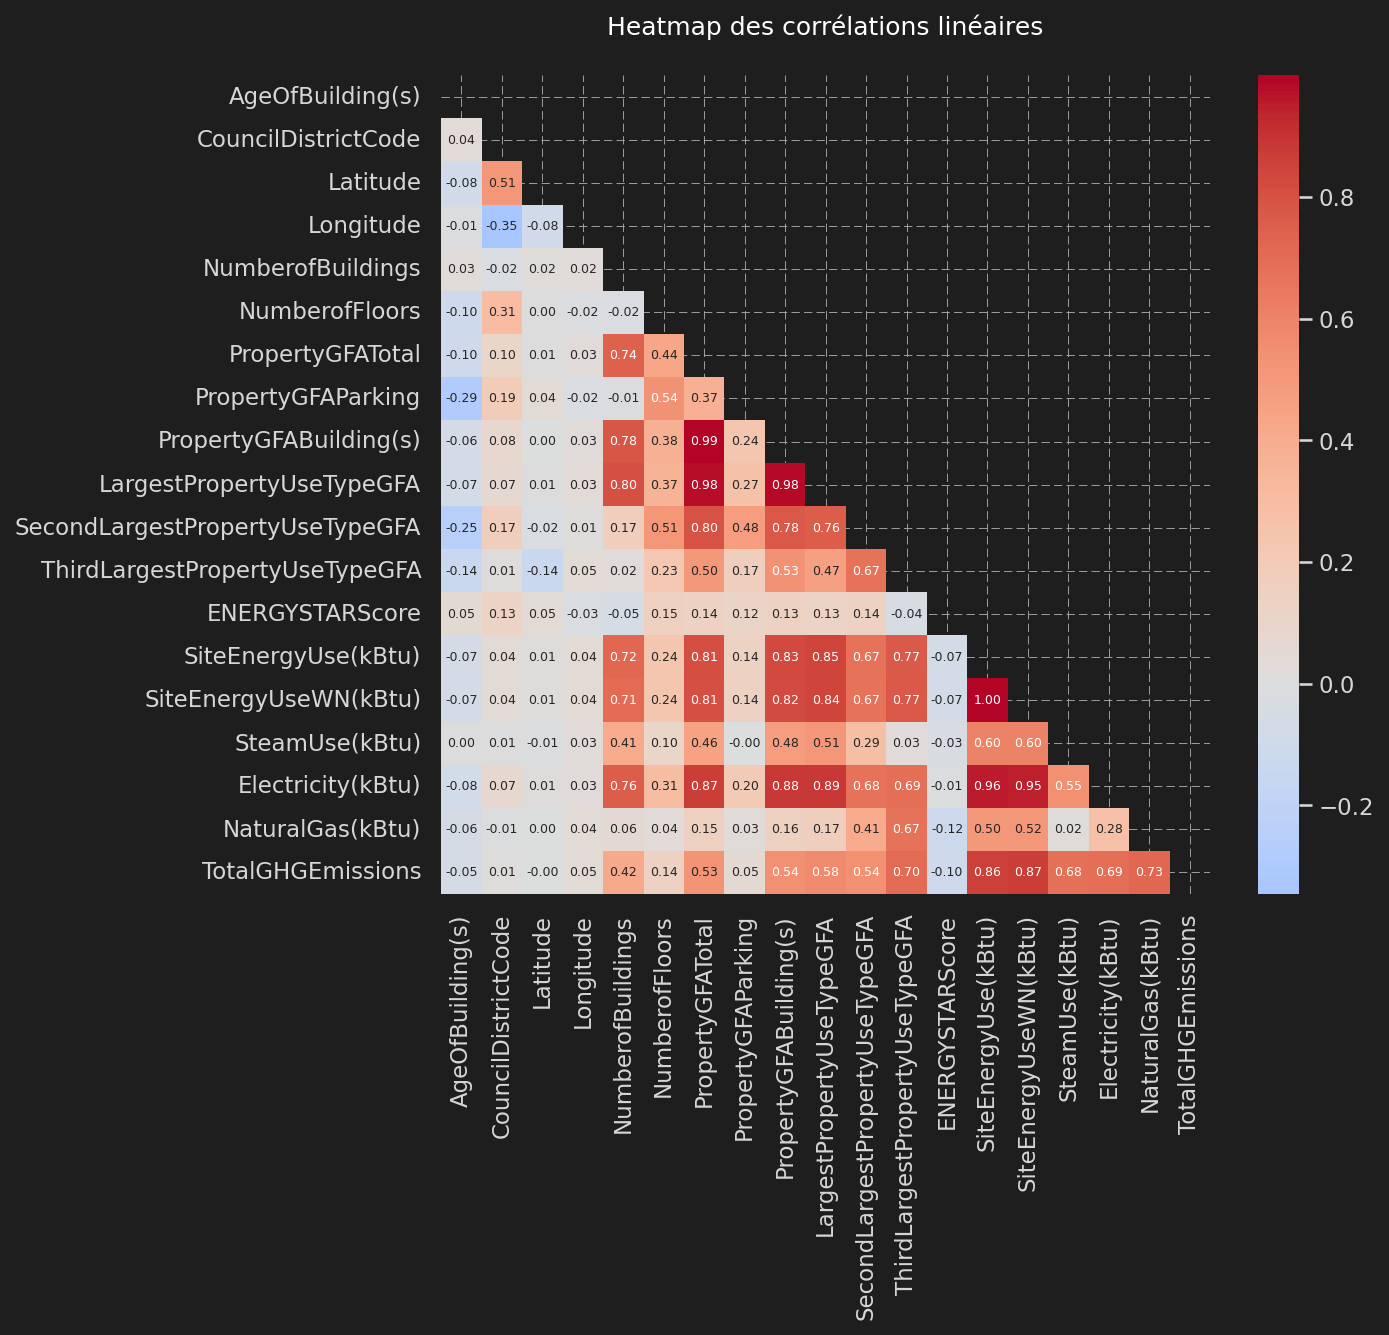

In [77]:
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(21*cm,18*cm))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':6}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

Vérification de **multicolinéarité avec le VIF** *(Variance Inflation Factor)* : $VIF = \frac{1}{1-R^2}$

On sélectionne les variables qui ne sont pas des variables cibles

In [78]:
variables = corr.columns.values[ ~corr.columns.str.contains( 'SiteEnergy|Emissi') ]
variables

array(['AgeOfBuilding(s)', 'CouncilDistrictCode', 'Latitude', 'Longitude',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'],
      dtype=object)

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


tmp = df[variables].dropna()

tmp_vif = pd.DataFrame()
tmp_vif["feature"] = tmp.columns
tmp_vif["VIF"] = [variance_inflation_factor(tmp.values, i) 
                   for i in range(len(tmp.columns))]

display(tmp_vif[tmp_vif['VIF'] > 5])

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


feature           VIF
4                 NumberofBuildings  1.141189e+08
6                  PropertyGFATotal           inf
7                PropertyGFAParking           inf
8            PropertyGFABuilding(s)           inf
9         LargestPropertyUseTypeGFA  3.036231e+01
10  SecondLargestPropertyUseTypeGFA  5.896614e+00
11   ThirdLargestPropertyUseTypeGFA  6.302195e+00
14                Electricity(kBtu)  5.922956e+00
15                 NaturalGas(kBtu)  5.526634e+00

Des scores VIF supérieur à 5 indiquent généralement une forte multicolinéarité. Les variables fortement corrélées peuvent dégrader les résultats des modèles.

In [80]:
mask = ['ENERGYSTARScore']
df_annexe[mask] = df[mask].copy()
df.drop( columns=mask, inplace=True )

## PCA

In [81]:
tmp = df.select_dtypes(include=[np.number])
features = [col for col in tmp.columns if not col in vars_to_delete]
print(features)

['AgeOfBuilding(s)', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']


In [82]:
X = df[features].dropna()
scaler_pca = preprocessing.StandardScaler()
X_scaled = scaler_pca.fit_transform(X) # fit and transform
idx = ["mean", "std"]
display( pd.DataFrame(X_scaled).describe().round(2).loc[idx, :] )

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
mean -0.0 -0.0 -0.0  0.0  0.0 -0.0  0.0 -0.0 -0.0 -0.0  0.0 -0.0  0.0  0.0   
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

       14   15   16   17  
mean -0.0  0.0  0.0 -0.0  
std   1.0  1.0  1.0  1.0

In [83]:
from sklearn.decomposition import PCA
n_components = X_scaled.shape[1]
pca = PCA(n_components=n_components)

# entrainement
pca.fit(X_scaled)

PCA(n_components=18)

scree: [42.   16.69  9.28  6.55  5.18  5.17  4.09  3.13  2.39  2.15  1.36  1.22
  0.65  0.14  0.    0.    0.    0.  ]
sum scree: 100.0


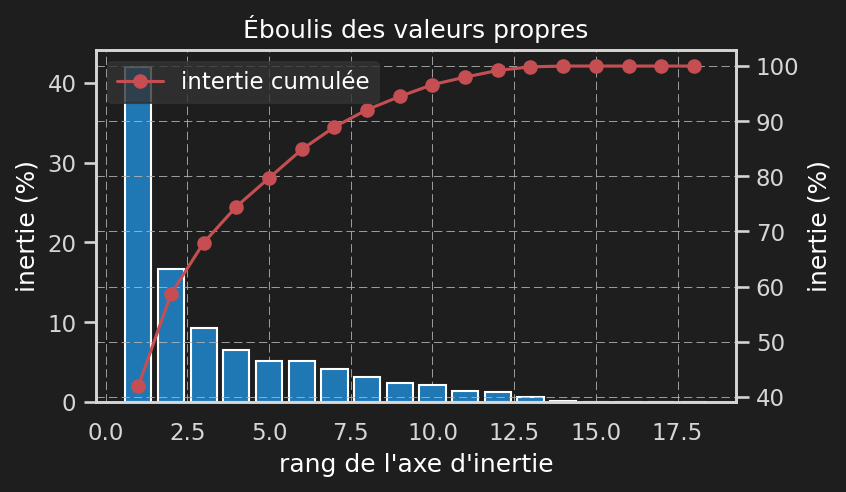

In [84]:
x_list = range(1, n_components+1)
scree = (pca.explained_variance_ratio_*100)
print('scree:', scree.round(2))
print('sum scree:', scree.sum().round(2))
fig, ax = plt.subplots( figsize=(14*cm,8*cm))
ax.bar( x_list, scree )
ax.set_xlabel("rang de l'axe d'inertie")
ax.set_ylabel("inertie (%)")
ax.set_title('Éboulis des valeurs propres')
ax.yaxis.grid( visible=False )

ax = ax.twinx()
ax.set_ylabel("inertie (%)")

ax.plot( x_list, scree.cumsum(), c='r', marker='o', label='intertie cumulée')
ax.legend()

fig.tight_layout(pad=0.2)
# tools.savefig( fig, 'Figures/PCA/ebouli.pdf')

On observe les premiers axes d'inertie

Electricity(kBtu)  SecondLargestPropertyUseTypeGFA  SiteEnergyUse(kBtu)  \
F1           0.336576                         0.324009             0.321692   

    SiteEnergyUseWN(kBtu)  LargestPropertyUseTypeGFA  PropertyGFATotal  \
F1               0.320229                   0.309576           0.29908   

    PropertyGFABuilding(s)  ThirdLargestPropertyUseTypeGFA  TotalGHGEmissions  \
F1                0.294526                        0.280589           0.257501   

    NaturalGas(kBtu)  NumberofFloors  PropertyGFAParking  CouncilDistrictCode  \
F1          0.228854        0.224637            0.179356             0.064548   

    SteamUse(kBtu)  NumberofBuildings  Longitude  Latitude  AgeOfBuilding(s)  
F1        0.059636           0.016409   0.015438 -0.043146         -0.116348

NaturalGas(kBtu)  TotalGHGEmissions  SiteEnergyUseWN(kBtu)  \
F2          0.414232           0.377879               0.255255   

    SiteEnergyUse(kBtu)  ThirdLargestPropertyUseTypeGFA  AgeOfBuilding(s)  \
F2             0.249779                        0.189773          0.103044   

    Longitude  NumberofBuildings  Electricity(kBtu)  SteamUse(kBtu)  \
F2   0.089343             0.0582           0.019968       -0.049165   

    SecondLargestPropertyUseTypeGFA  Latitude  CouncilDistrictCode  \
F2                        -0.057089 -0.129422            -0.235464   

    LargestPropertyUseTypeGFA  PropertyGFABuilding(s)  PropertyGFAParking  \
F2                  -0.252489               -0.264058           -0.289793   

    PropertyGFATotal  NumberofFloors  
F2         -0.298669       -0.339331

Longitude  NumberofBuildings  PropertyGFABuilding(s)  PropertyGFATotal  \
F3   0.505106           0.318575                0.120825          0.106711   

    LargestPropertyUseTypeGFA  NumberofFloors  \
F3                   0.102262        0.052305   

    SecondLargestPropertyUseTypeGFA  Electricity(kBtu)  PropertyGFAParking  \
F3                         0.014673           0.009776            0.006046   

    ThirdLargestPropertyUseTypeGFA  AgeOfBuilding(s)  SiteEnergyUse(kBtu)  \
F3                       -0.016915         -0.040735            -0.076515   

    SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  NaturalGas(kBtu)  \
F3              -0.078813       -0.085153         -0.132254   

    TotalGHGEmissions  Latitude  CouncilDistrictCode  
F3          -0.132287 -0.498477            -0.546918

SteamUse(kBtu)  AgeOfBuilding(s)  NumberofFloors  CouncilDistrictCode  \
F4        0.607241          0.592375        0.199032             0.130481   

    PropertyGFABuilding(s)  NumberofBuildings  LargestPropertyUseTypeGFA  \
F4                0.086016           0.066182                   0.059452   

    TotalGHGEmissions  Electricity(kBtu)  PropertyGFATotal  \
F4           0.027401           0.014519          0.008646   

    SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
F4             0.008283               0.007875   

    ThirdLargestPropertyUseTypeGFA  NaturalGas(kBtu)  \
F4                       -0.015822         -0.060076   

    SecondLargestPropertyUseTypeGFA  Longitude  PropertyGFAParking  Latitude  
F4                        -0.087789  -0.121984           -0.280156  -0.31984

NumberofBuildings  SteamUse(kBtu)  Latitude  CouncilDistrictCode  \
F5           0.669163        0.491748  0.260117             0.143068   

    Longitude  PropertyGFAParking  TotalGHGEmissions  Electricity(kBtu)  \
F5   0.130642            0.112284           0.053609           0.047872   

    SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  NaturalGas(kBtu)  \
F5             0.043569               0.041368         -0.019059   

    SecondLargestPropertyUseTypeGFA  NumberofFloors  \
F5                        -0.032621       -0.069546   

    LargestPropertyUseTypeGFA  PropertyGFATotal  PropertyGFABuilding(s)  \
F5                  -0.074455         -0.085312               -0.128406   

    ThirdLargestPropertyUseTypeGFA  AgeOfBuilding(s)  
F5                       -0.149657         -0.354761

NumberofBuildings  AgeOfBuilding(s)  CouncilDistrictCode  \
F6           0.641698           0.25447             0.130902   

    Electricity(kBtu)  ThirdLargestPropertyUseTypeGFA  PropertyGFABuilding(s)  \
F6           0.085585                        0.081057                0.080195   

    PropertyGFATotal  SecondLargestPropertyUseTypeGFA  \
F6          0.050092                         0.032311   

    LargestPropertyUseTypeGFA  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
F6                   0.017199            -0.001215                -0.0036   

    NaturalGas(kBtu)  NumberofFloors  Latitude  PropertyGFAParking  \
F6         -0.032683         -0.0671 -0.071501             -0.0836   

    TotalGHGEmissions  Longitude  SteamUse(kBtu)  
F6          -0.087246  -0.454675       -0.500131

AgeOfBuilding(s)  CouncilDistrictCode  Latitude  Longitude  \
F1             -0.12                 0.06     -0.04       0.02   
F2              0.10                -0.24     -0.13       0.09   
F3             -0.04                -0.55     -0.50       0.51   
F4              0.59                 0.13     -0.32      -0.12   
F5             -0.35                 0.14      0.26       0.13   
F6              0.25                 0.13     -0.07      -0.45   

    NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
F1               0.02            0.22              0.30                0.18   
F2               0.06           -0.34             -0.30               -0.29   
F3               0.32            0.05              0.11                0.01   
F4               0.07            0.20              0.01               -0.28   
F5               0.67           -0.07             -0.09                0.11   
F6               0.64           -0.07              0.05               -0.08   

    PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
F1                    0.29                       0.31   
F2                   -0.26                      -0.25   
F3                    0.12                       0.10   
F4                    0.09                       0.06   
F5                   -0.13                      -0.07   
F6                    0.08                       0.02   

    SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
F1                             0.32                            0.28   
F2                            -0.06                            0.19   
F3                             0.01                           -0.02   
F4                            -0.09                           -0.02   
F5                            -0.03                           -0.15   
F6                             0.03                            0.08   

    SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
F1                 0.32                   0.32            0.06   
F2                 0.25                   0.26           -0.05   
F3                -0.08                  -0.08           -0.09   
F4                 0.01                   0.01            0.61   
F5                 0.04                   0.04            0.49   
F6                -0.00                  -0.00           -0.50   

    Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  
F1               0.34              0.23               0.26  
F2               0.02              0.41               0.38  
F3               0.01             -0.13              -0.13  
F4               0.01             -0.06               0.03  
F5               0.05             -0.02               0.05  
F6               0.09             -0.03              -0.09

<Axes: >

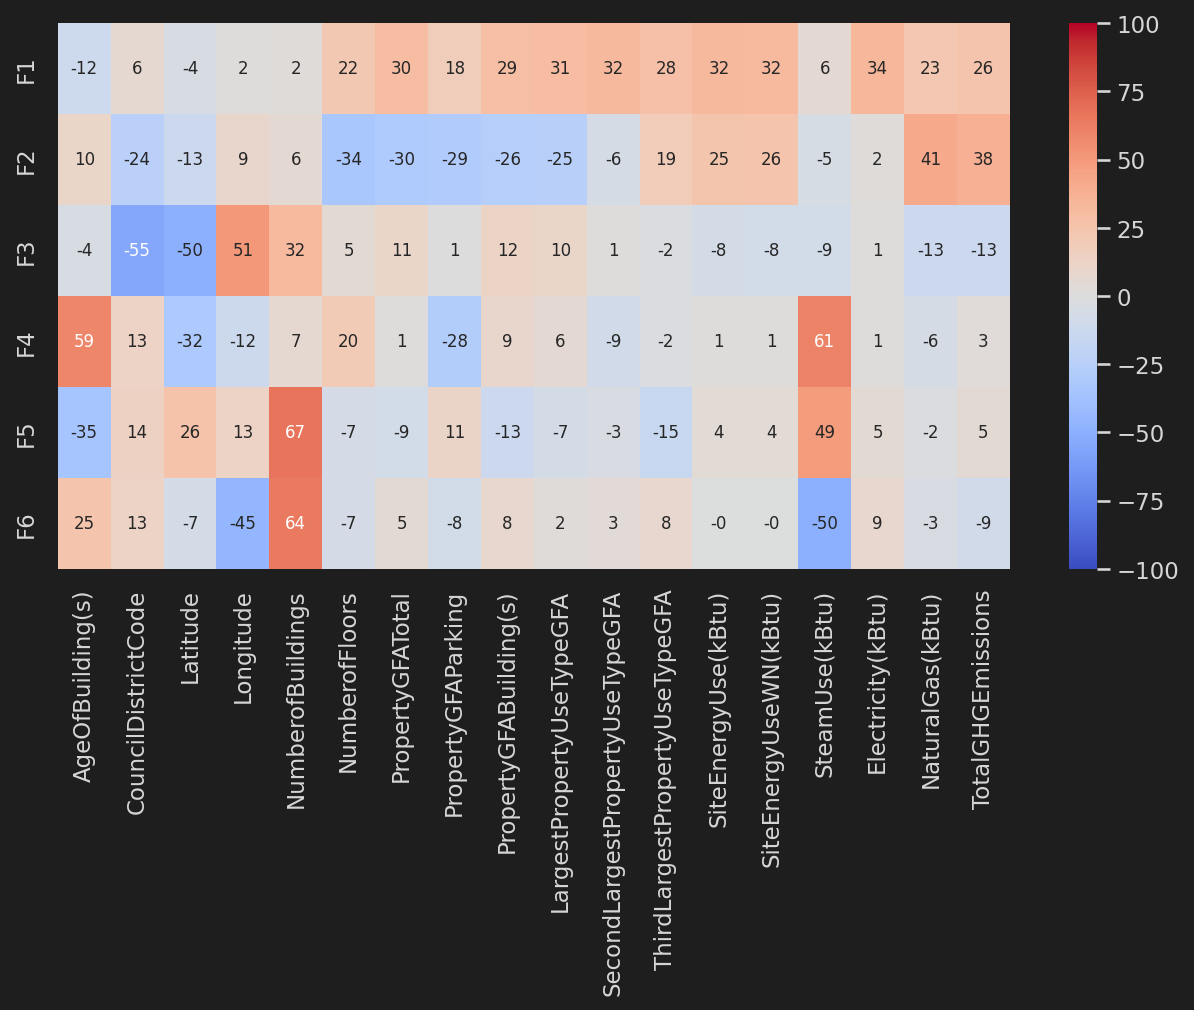

In [85]:
pcs = pd.DataFrame( pca.components_.transpose() )
pcs.index = features
columns = [f"F{i}" for i in x_list]
pcs.columns = columns

for i in range(6):
    key = f'F{i+1:}'
    display( pcs[[key]].sort_values( key, ascending=False ).T )

display( pcs.iloc[:,:6].round(2).T ) #.sort_values(by=indexes , ascending=False) )
fig, ax = plt.subplots(figsize=(26*cm, 12*cm))
sns.heatmap(pcs.iloc[:,:6].T*100, vmin=-100, vmax=100, annot=True, cmap="coolwarm", fmt="0.0f", annot_kws={"size": 8})
# fig.tight_layout( pad=0.2 )

## Calcul de ratios

On s'intrésse à des variables rapportée à la surface totale d'un site, donc on ramène les GFA à des ratios, avec comme référence les GFABuilding(s)

In [86]:
GFA_ref = df['PropertyGFABuilding(s)'].values.copy()

mask = ['PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking']
df_annexe[mask] = df[mask].copy()
df.drop( columns=mask, inplace=True )
# df['PropertyGFABuilding(s)'] /= df[mask]
# df['PropertyGFAParking'] /= df[mask]
# df.rename( columns={'PropertyGFABuilding(s)':'%GFABuilding(s)', 'PropertyGFAParking':'%GFAParking'}, inplace=True )


mask2 = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
df[ mask2 ] = df[mask2].fillna(0.).values / GFA_ref.reshape(-1,1)
# df[ mask2 ] = df[ mask2 ] / df[ mask2 ].values.sum(1).reshape(-1,1)
df.rename( columns={ mask2[0]:'prop_use_1', mask2[1]:'prop_use_2', mask2[2]:'prop_use_3' }, inplace=True)
df.rename( columns={ mask2[0][:-3]:'Type_use_1', mask2[1][:-3]:'Type_use_2', mask2[2][:-3]:'Type_use_3' }, inplace=True)
df.sample(5)

AgeOfBuilding(s)  CouncilDistrictCode      Neighborhood  Latitude  \
1960                63                    2  greater duwamish  47.55498   
1678                51                    2  greater duwamish  47.57894   
3012                58                    3              east  47.61469   
2785                91                    3           central  47.60320   
1205                67                    4         northeast  47.67020   

      Longitude  NumberofBuildings  NumberofFloors        Type_use_1  \
1960 -122.32497                  1               1            office   
1678 -122.31287                  1               1             store   
3012 -122.31596                  1               2        industrial   
2785 -122.30596                  1               2         education   
1205 -122.32066                  1               1  worship facility   

      prop_use_1 Type_use_2  prop_use_2 Type_use_3  prop_use_3  \
1960    0.988967        NaN         0.0        NaN         0.0   
1678    1.000000        NaN         0.0        NaN         0.0   
3012    1.000000        NaN         0.0        NaN         0.0   
2785    1.000000        NaN         0.0        NaN         0.0   
1205    1.154074    parking         0.0        NaN         0.0   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
1960           655422.375             751206.500             0.0   
1678          5833800.000            5927199.500             0.0   
3012           595936.500             604190.125             0.0   
2785          1522596.750            1663727.125             0.0   
1205          1149140.250            1343672.875             0.0   

      Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  
1960           329487.0          325936.0              19.61  
1678          3900058.0         1933742.0             129.89  
3012           595937.0               0.0               4.15  
2785           555586.0          967011.0              55.23  
1205           340323.0          808817.0              45.33

%GFABuilding(s) et %GFAParking sont corrélé ( l'un égale 1-l'autre)

Pour éviter les fuites de données, des ratios sont calculés pour les énergies

In [87]:
df[energies] = df[energies].fillna(0.)
sr_0 = df[energies].sum(1) == 0.
print(f'Entrées avec des 0 : {sr_0.sum()}')
# display( df.loc[sr_0,:] )

df.loc[sr_0,'Electricity(kBtu)'] = 1.

# df[energies] = df[energies].values / df[energies].abs().values.sum(1).reshape(-1,1)
df[energies] = df[energies] / df['SiteEnergyUse(kBtu)'].values.reshape(-1,1)
df.rename( columns={ var:'prop_{:}'.format( var.replace('(kBtu)', '') ) for var in energies }, inplace=True )
df.sample(5)

Entrées avec des 0 : 0


AgeOfBuilding(s)  CouncilDistrictCode           Neighborhood  Latitude  \
3368                22                    3                central  47.60775   
1025                39                    3              southeast  47.58476   
3267                27                    7               downtown  47.60898   
551                 16                    7  magnolia / queen anne  47.62225   
210                100                    7               downtown  47.61256   

      Longitude  NumberofBuildings  NumberofFloors  \
3368 -122.30225                  1               1   
1025 -122.29765                  1               1   
3267 -122.34213                  1               3   
551  -122.35915                  1               7   
210  -122.33808                  1               5   

                           Type_use_1  prop_use_1        Type_use_2  \
3368  entertainment - public assembly    0.404389  lifestyle center   
1025  entertainment - public assembly    1.846327               NaN   
3267                          medical    0.937311          services   
551                            office    1.037510           parking   
210                            office    0.702421             store   

      prop_use_2 Type_use_3  prop_use_3  SiteEnergyUse(kBtu)  \
3368    0.385337     office    0.188479          1813404.000   
1025    0.000000        NaN    0.000000          1441665.375   
3267    0.088175     office    0.014156          2737534.500   
551     0.530741        NaN    0.000000          8655604.000   
210     0.135915        NaN    0.000000          3757006.000   

      SiteEnergyUseWN(kBtu)  prop_SteamUse  prop_Electricity  prop_NaturalGas  \
3368            1993136.625            0.0          0.424314         0.575686   
1025            1542945.125            0.0          1.000000         0.000000   
3267            2842128.000            0.0          0.689695         0.310305   
551             8732968.000            0.0          0.980682         0.019318   
210             3992167.750            0.0          1.000000         0.000000   

      TotalGHGEmissions  
3368              60.81  
1025              10.05  
3267              58.28  
551               68.06  
210               26.19

Calcul du TotalGHGEmissions `WeatherNormalized`. Les valeurs obtenues sont bien du même ordre de grandeur que les valeurs brutes.

In [88]:
prop_energies = [ 'prop_{:}'.format( var.replace('(kBtu)', '') ) for var in energies]
df['TotalGHGEmissionsWN'] = energies_to_emissions( *( ( df[prop_energies].values * df['SiteEnergyUseWN(kBtu)'].values.reshape(-1,1) ).T ) )
display( df[['TotalGHGEmissions','TotalGHGEmissionsWN']].describe().T )
df.head(5)

count        mean         std       min        25%  \
TotalGHGEmissions    1551.0  193.096702  778.407004 -0.800000  20.110000   
TotalGHGEmissionsWN  1551.0  199.390132  798.427946 -0.563734  21.152595   

                           50%         75%           max  
TotalGHGEmissions    49.730000  147.315000  16870.980000  
TotalGHGEmissionsWN  53.603214  152.400567  17744.928811

AgeOfBuilding(s)  CouncilDistrictCode Neighborhood  Latitude  Longitude  \
0                89                    7     downtown  47.61220 -122.33799   
1                20                    7     downtown  47.61317 -122.33393   
2                47                    7     downtown  47.61393 -122.33810   
3                90                    7     downtown  47.61412 -122.33664   
4                36                    7     downtown  47.61375 -122.34047   

   NumberofBuildings  NumberofFloors           Type_use_1  prop_use_1  \
0                  1              12  residential - hotel    1.000000   
1                  1              11  residential - hotel    0.947775   
2                  1              41  residential - hotel    0.996182   
3                  1              10  residential - hotel    1.000000   
4                  1              18  residential - hotel    1.086855   

  Type_use_2  prop_use_2                       Type_use_3  prop_use_3  \
0        NaN    0.000000                              NaN    0.000000   
1    parking    0.170211                       restaurant    0.052225   
2        NaN    0.000000                              NaN    0.000000   
3        NaN    0.000000                              NaN    0.000000   
4    parking    0.598776  entertainment - public assembly    0.000000   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  prop_SteamUse  \
0            7226362.5              7456910.0       0.277302   
1            8387933.0              8664479.0       0.000000   
2           72587024.0             73937112.0       0.297113   
3            6794584.0              6946800.5       0.325913   
4           14172606.0             14656503.0       0.000000   

   prop_Electricity  prop_NaturalGas  TotalGHGEmissions  TotalGHGEmissionsWN  
0          0.546060         0.176638             249.98           257.950998  
1          0.386609         0.613391             295.86           305.615955  
2          0.682307         0.020579            2089.28          2128.125812  
3          0.407519         0.266567             286.43           292.840900  
4          0.378802         0.621198             505.01           522.247895

In [89]:
mask = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
df_annexe[mask] = df[mask].copy()
df.drop( columns=mask, inplace=True )
df.head(5)

AgeOfBuilding(s)  CouncilDistrictCode Neighborhood  Latitude  Longitude  \
0                89                    7     downtown  47.61220 -122.33799   
1                20                    7     downtown  47.61317 -122.33393   
2                47                    7     downtown  47.61393 -122.33810   
3                90                    7     downtown  47.61412 -122.33664   
4                36                    7     downtown  47.61375 -122.34047   

   NumberofBuildings  NumberofFloors           Type_use_1  prop_use_1  \
0                  1              12  residential - hotel    1.000000   
1                  1              11  residential - hotel    0.947775   
2                  1              41  residential - hotel    0.996182   
3                  1              10  residential - hotel    1.000000   
4                  1              18  residential - hotel    1.086855   

  Type_use_2  prop_use_2                       Type_use_3  prop_use_3  \
0        NaN    0.000000                              NaN    0.000000   
1    parking    0.170211                       restaurant    0.052225   
2        NaN    0.000000                              NaN    0.000000   
3        NaN    0.000000                              NaN    0.000000   
4    parking    0.598776  entertainment - public assembly    0.000000   

   SiteEnergyUseWN(kBtu)  prop_SteamUse  prop_Electricity  prop_NaturalGas  \
0              7456910.0       0.277302          0.546060         0.176638   
1              8664479.0       0.000000          0.386609         0.613391   
2             73937112.0       0.297113          0.682307         0.020579   
3              6946800.5       0.325913          0.407519         0.266567   
4             14656503.0       0.000000          0.378802         0.621198   

   TotalGHGEmissionsWN  
0           257.950998  
1           305.615955  
2          2128.125812  
3           292.840900  
4           522.247895

## Calcul de variables liées à la surface et au périmètre
<span style="color:red"> AJOUT EXPLICATION DE CHAQUE VARIABLE </span>

In [90]:
df = df.copy() # suppress warning
df['GFA_per_floor'] = GFA_ref / ( df['NumberofBuildings'].values * df['NumberofFloors'].values )
df['sqrt_GFA_per_floor'] = np.sqrt( df['GFA_per_floor'].values )
df.head(5)

AgeOfBuilding(s)  CouncilDistrictCode Neighborhood  Latitude  Longitude  \
0                89                    7     downtown  47.61220 -122.33799   
1                20                    7     downtown  47.61317 -122.33393   
2                47                    7     downtown  47.61393 -122.33810   
3                90                    7     downtown  47.61412 -122.33664   
4                36                    7     downtown  47.61375 -122.34047   

   NumberofBuildings  NumberofFloors           Type_use_1  prop_use_1  \
0                  1              12  residential - hotel    1.000000   
1                  1              11  residential - hotel    0.947775   
2                  1              41  residential - hotel    0.996182   
3                  1              10  residential - hotel    1.000000   
4                  1              18  residential - hotel    1.086855   

  Type_use_2  prop_use_2                       Type_use_3  prop_use_3  \
0        NaN    0.000000                              NaN    0.000000   
1    parking    0.170211                       restaurant    0.052225   
2        NaN    0.000000                              NaN    0.000000   
3        NaN    0.000000                              NaN    0.000000   
4    parking    0.598776  entertainment - public assembly    0.000000   

   SiteEnergyUseWN(kBtu)  prop_SteamUse  prop_Electricity  prop_NaturalGas  \
0              7456910.0       0.277302          0.546060         0.176638   
1              8664479.0       0.000000          0.386609         0.613391   
2             73937112.0       0.297113          0.682307         0.020579   
3              6946800.5       0.325913          0.407519         0.266567   
4             14656503.0       0.000000          0.378802         0.621198   

   TotalGHGEmissionsWN  GFA_per_floor  sqrt_GFA_per_floor  
0           257.950998    7369.500000           85.845792  
1           305.615955    8045.636364           89.697471  
2          2128.125812   18521.756098          136.094659  
3           292.840900    6132.000000           78.307088  
4           522.247895    6310.000000           79.435508

Les variables targets sont mises à la fin du DataFrame.

In [91]:
targets = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissionsWN']
print( targets, 'in DataFrame:', [key in df.columns for key in targets])

# les colonnes targets sont mises à la fin
df = df[ [key for key in df.columns if not key in targets ] + targets ]
df.head(5)

['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissionsWN'] in DataFrame: [True, True]


AgeOfBuilding(s)  CouncilDistrictCode Neighborhood  Latitude  Longitude  \
0                89                    7     downtown  47.61220 -122.33799   
1                20                    7     downtown  47.61317 -122.33393   
2                47                    7     downtown  47.61393 -122.33810   
3                90                    7     downtown  47.61412 -122.33664   
4                36                    7     downtown  47.61375 -122.34047   

   NumberofBuildings  NumberofFloors           Type_use_1  prop_use_1  \
0                  1              12  residential - hotel    1.000000   
1                  1              11  residential - hotel    0.947775   
2                  1              41  residential - hotel    0.996182   
3                  1              10  residential - hotel    1.000000   
4                  1              18  residential - hotel    1.086855   

  Type_use_2  prop_use_2                       Type_use_3  prop_use_3  \
0        NaN    0.000000                              NaN    0.000000   
1    parking    0.170211                       restaurant    0.052225   
2        NaN    0.000000                              NaN    0.000000   
3        NaN    0.000000                              NaN    0.000000   
4    parking    0.598776  entertainment - public assembly    0.000000   

   prop_SteamUse  prop_Electricity  prop_NaturalGas  GFA_per_floor  \
0       0.277302          0.546060         0.176638    7369.500000   
1       0.000000          0.386609         0.613391    8045.636364   
2       0.297113          0.682307         0.020579   18521.756098   
3       0.325913          0.407519         0.266567    6132.000000   
4       0.000000          0.378802         0.621198    6310.000000   

   sqrt_GFA_per_floor  SiteEnergyUseWN(kBtu)  TotalGHGEmissionsWN  
0           85.845792              7456910.0           257.950998  
1           89.697471              8664479.0           305.615955  
2          136.094659             73937112.0          2128.125812  
3           78.307088              6946800.5           292.840900  
4           79.435508             14656503.0           522.247895

## Corrélation des nouvelles variables

Index(['GFA Building(s)', 'AgeOfBuilding(s)', 'CouncilDistrictCode',
       'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'prop_use_1', 'prop_use_2', 'prop_use_3', 'prop_SteamUse',
       'prop_Electricity', 'prop_NaturalGas', 'GFA_per_floor',
       'sqrt_GFA_per_floor', 'SiteEnergyUseWN(kBtu)_per_GFA',
       'TotalGHGEmissionsWN_per_GFA'],
      dtype='object')

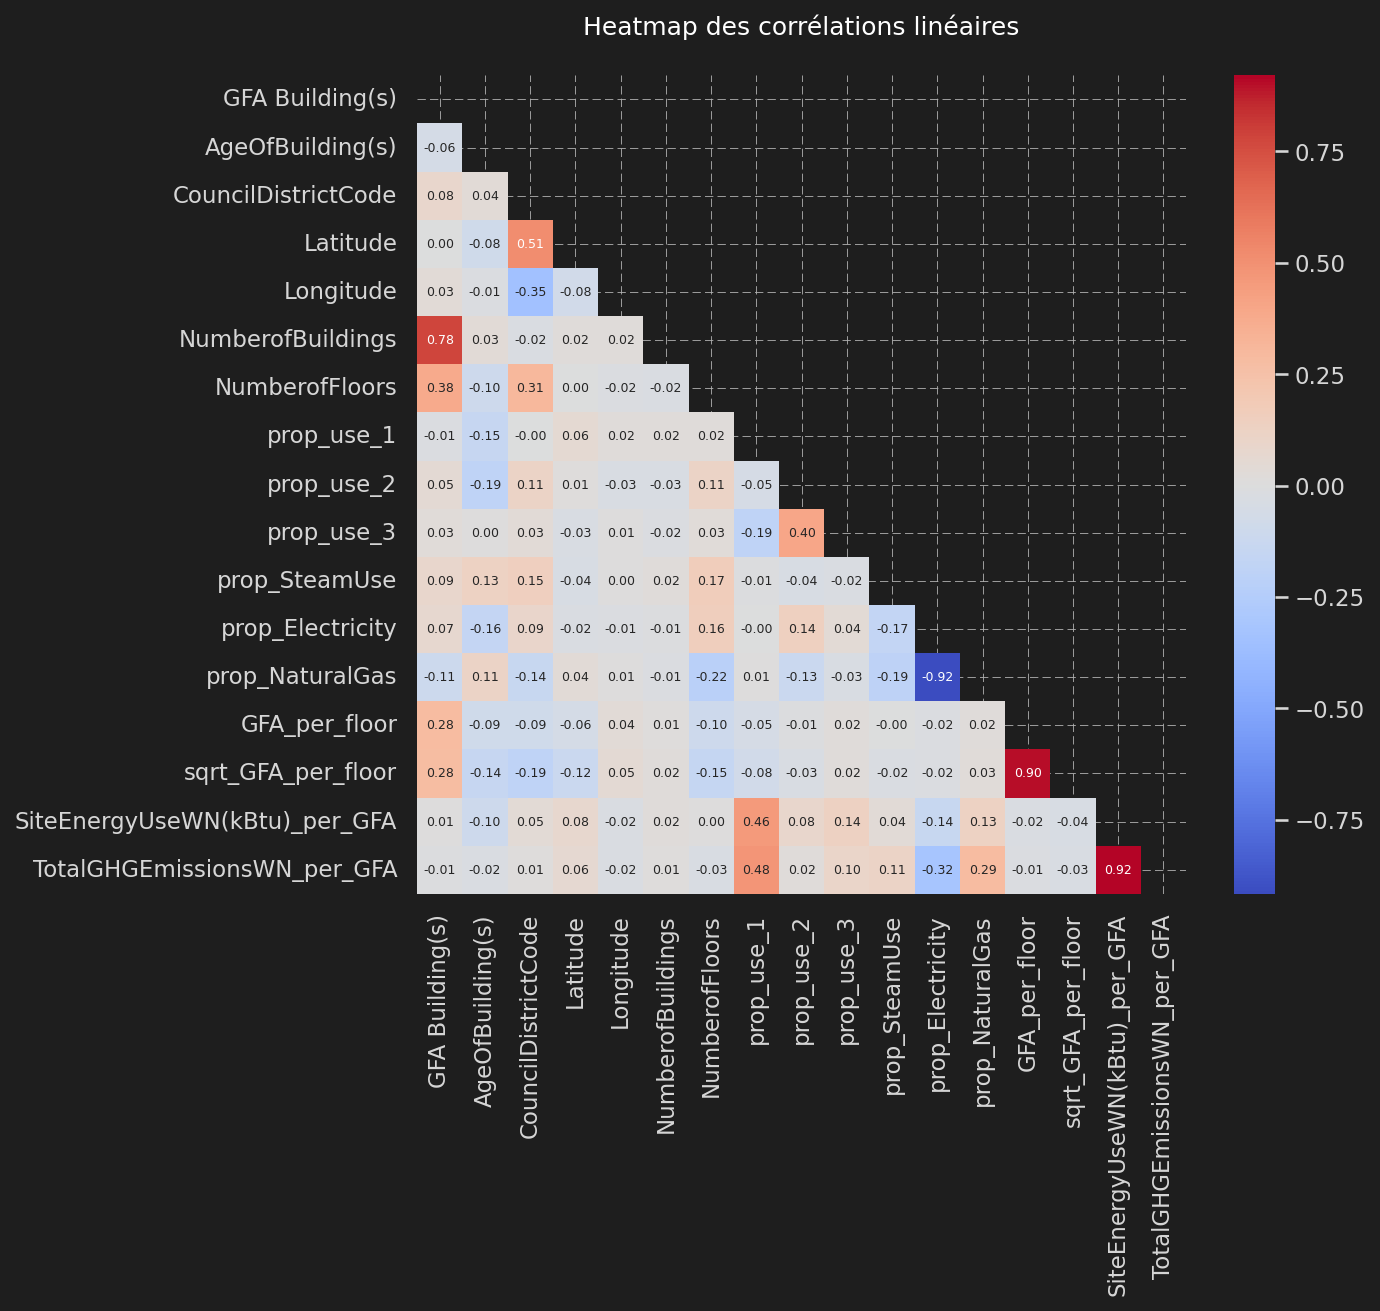

In [92]:
tmp = pd.DataFrame()
tmp['GFA Building(s)'] = GFA_ref
tmp2 = df.select_dtypes(include=[np.number]).copy()
tmp[tmp2.columns] = tmp2.values 
tmp.iloc[:,-2:] = tmp.iloc[:,-2:].values / GFA_ref.reshape(-1,1)



tmp.rename( columns={var:f'{var}_per_GFA' for var in tmp.columns.tolist()[-2:] }, inplace=True )
display( tmp.columns )
corr = tmp.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(21*cm,18*cm))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':6}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

In [93]:
variables = corr.columns.values[ ~corr.columns.str.contains( 'SiteEnergy|Emissi') ]
variables

array(['GFA Building(s)', 'AgeOfBuilding(s)', 'CouncilDistrictCode',
       'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'prop_use_1', 'prop_use_2', 'prop_use_3', 'prop_SteamUse',
       'prop_Electricity', 'prop_NaturalGas', 'GFA_per_floor',
       'sqrt_GFA_per_floor'], dtype=object)

In [94]:
tmp2 = tmp[variables]

tmp_vif = pd.DataFrame()
tmp_vif["feature"] = tmp2.columns
tmp_vif["VIF"] = [variance_inflation_factor(tmp2.values, i) 
                   for i in range(len(tmp2.columns))]

display(tmp_vif[tmp_vif['VIF'] > 5])

feature           VIF
0       GFA Building(s)  9.249130e+00
2   CouncilDistrictCode  7.746584e+00
3              Latitude  1.379047e+06
4             Longitude  1.379253e+06
5     NumberofBuildings  7.012032e+00
7            prop_use_1  6.124515e+00
11     prop_Electricity  2.032093e+02
12      prop_NaturalGas  5.275667e+01
13        GFA_per_floor  7.239698e+00
14   sqrt_GFA_per_floor  2.977280e+01

In [95]:
mask = 'PropertyGFABuilding(s)'
print( f'{mask} in df_annexe:', mask in df_annexe.columns )

PropertyGFABuilding(s) in df_annexe: True


## Scatter plots

1109    ballard center
Name: PropertyName, dtype: object

AgeOfBuilding(s)  CouncilDistrictCode Neighborhood  Latitude  Longitude  \
1109                50                    6      ballard  47.69875 -122.36725   

      NumberofBuildings  NumberofFloors Type_use_1  prop_use_1 Type_use_2  \
1109                  1               2    medical     9.90099    parking   

      prop_use_2 Type_use_3  prop_use_3  prop_SteamUse  prop_Electricity  \
1109         0.0        NaN         0.0            0.0          0.293148   

      prop_NaturalGas  GFA_per_floor  sqrt_GFA_per_floor  \
1109         0.706852         1818.0           42.638011   

      SiteEnergyUseWN(kBtu)  TotalGHGEmissionsWN  
1109             12805711.0           506.907179

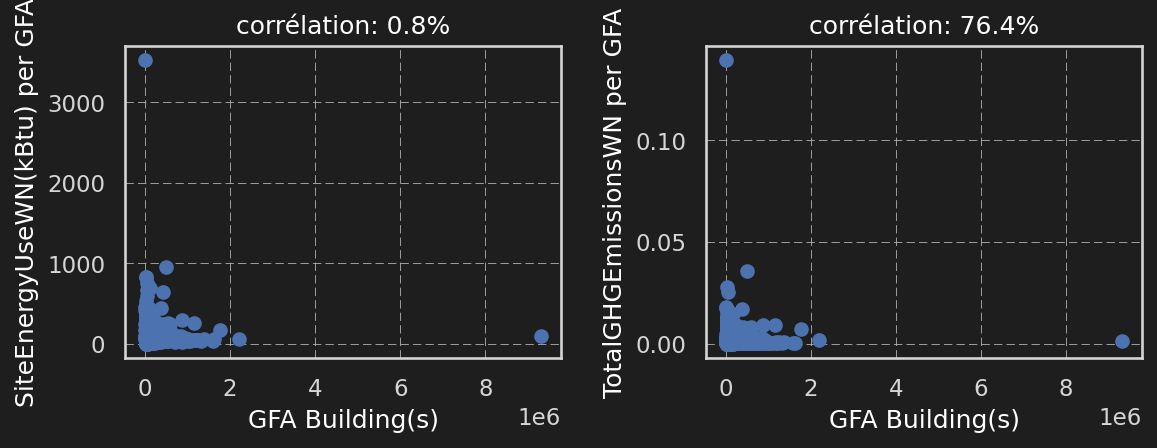

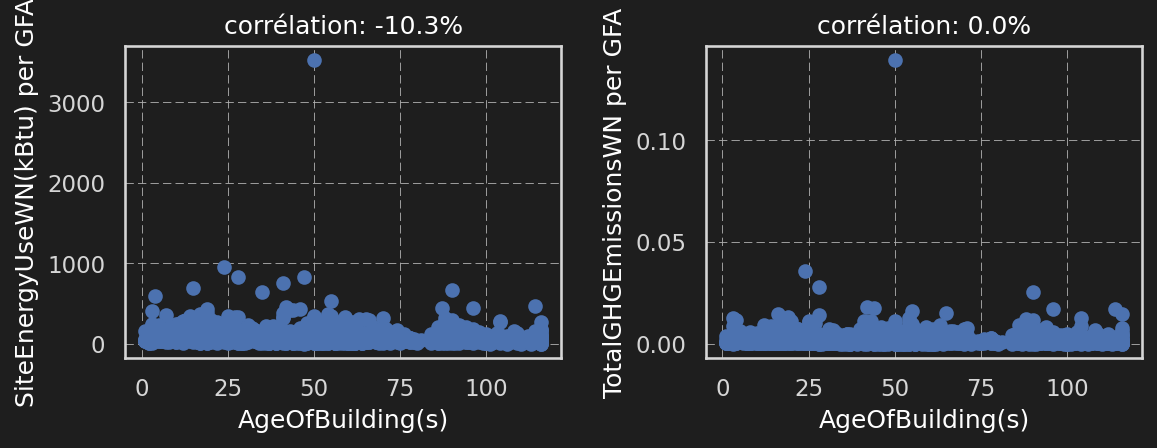

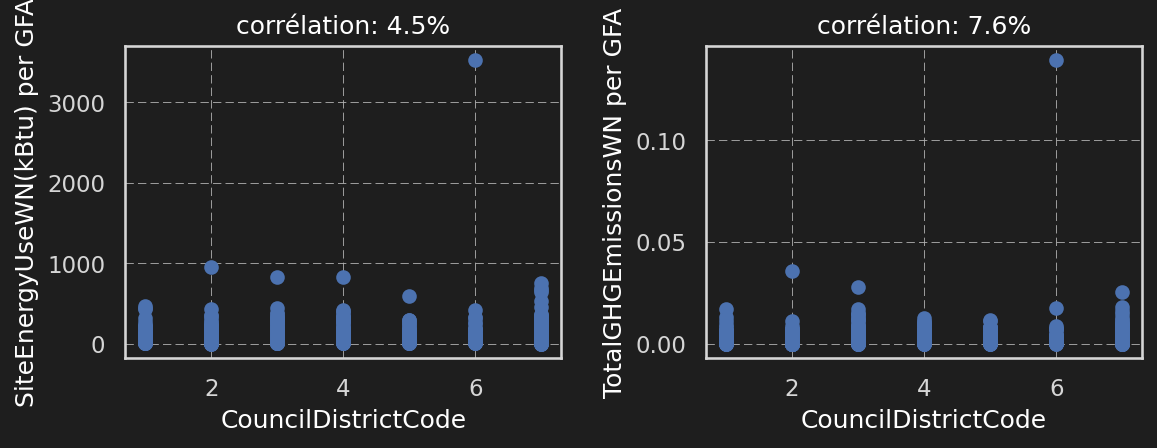

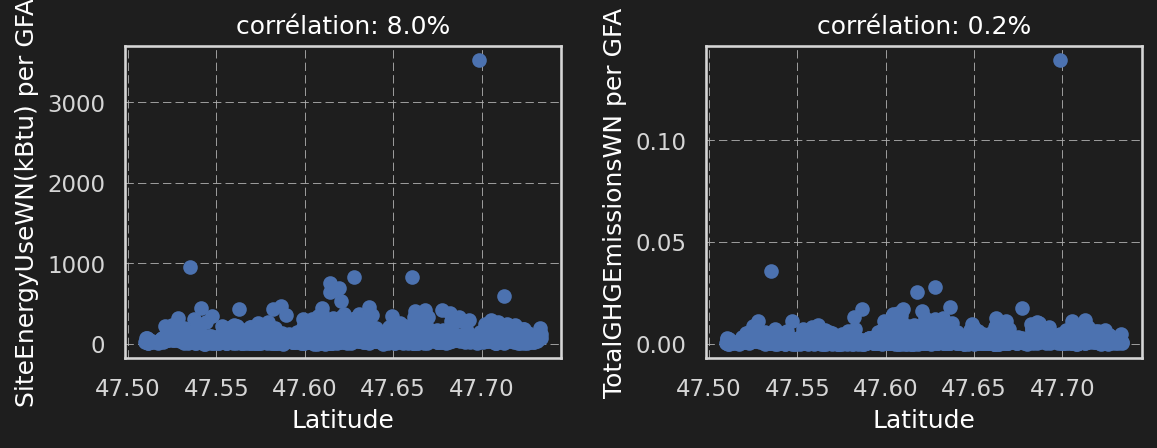

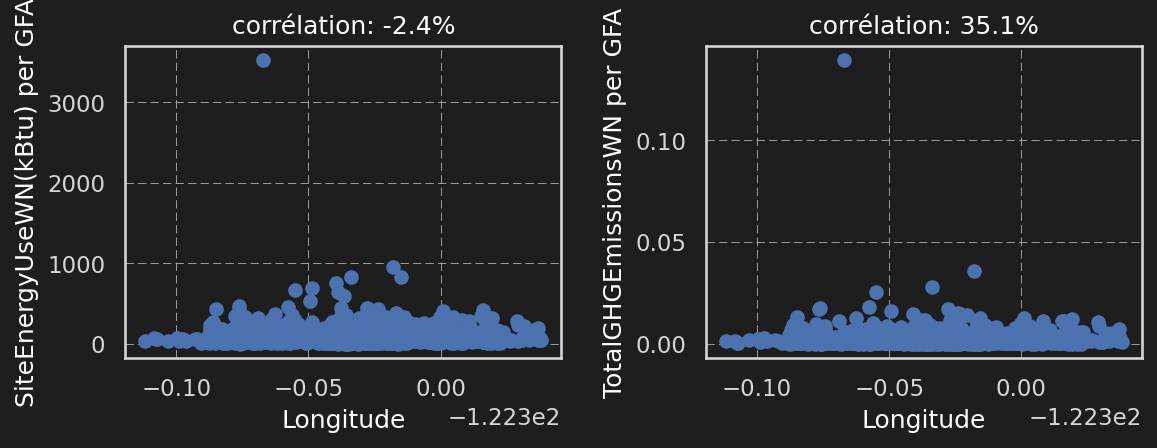

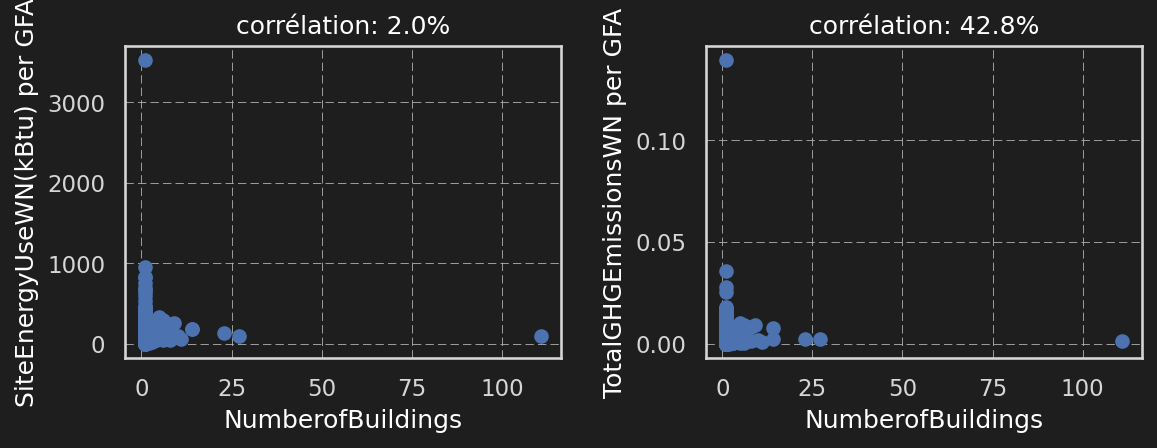

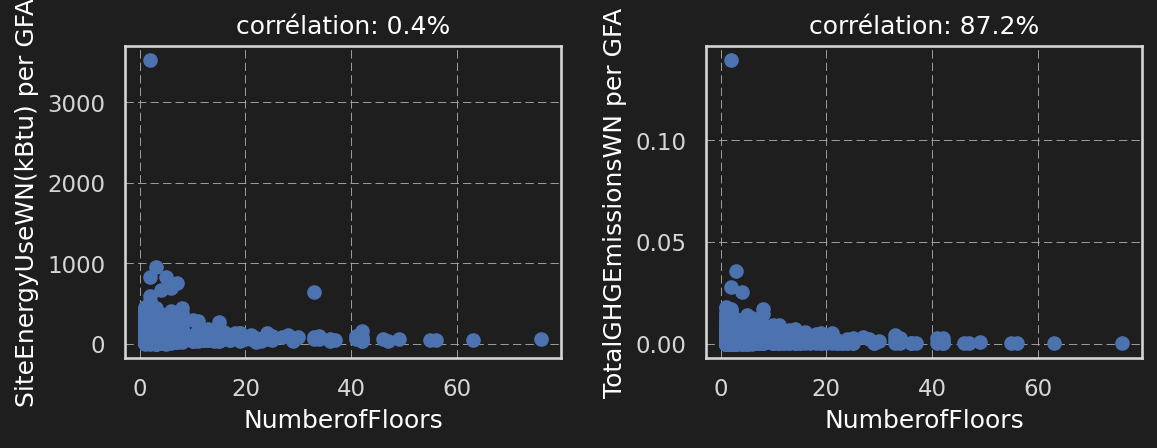

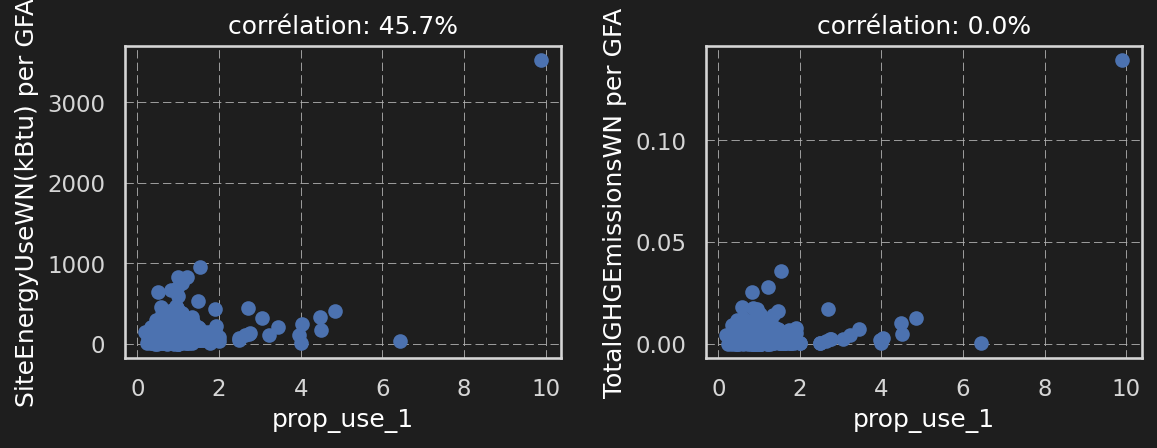

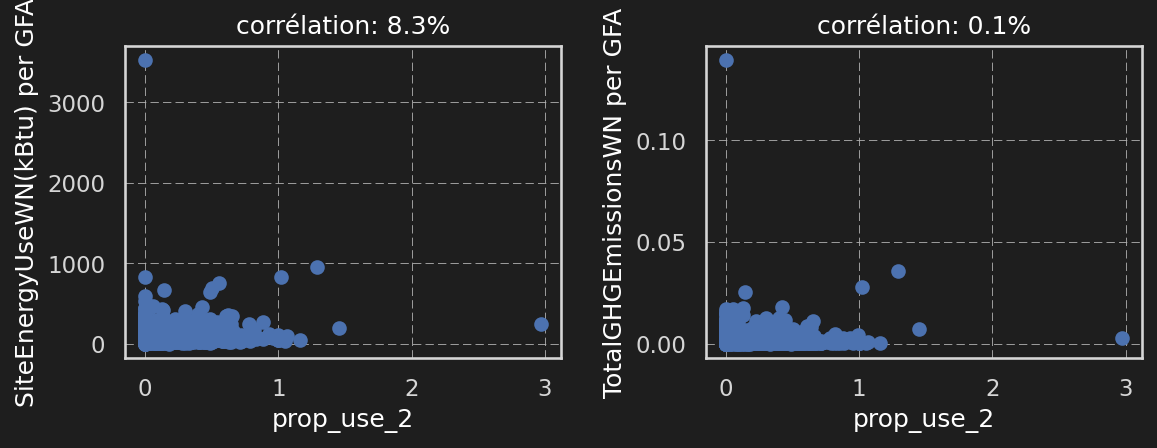

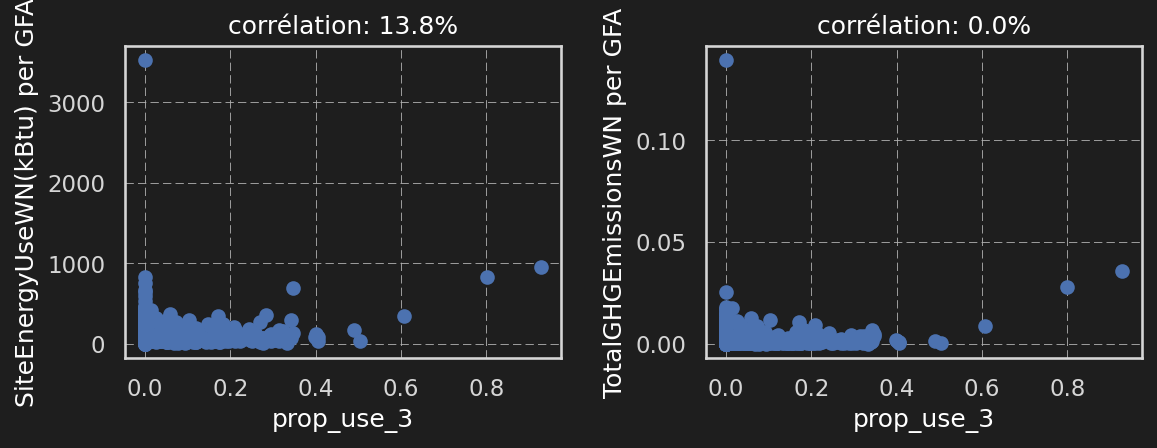

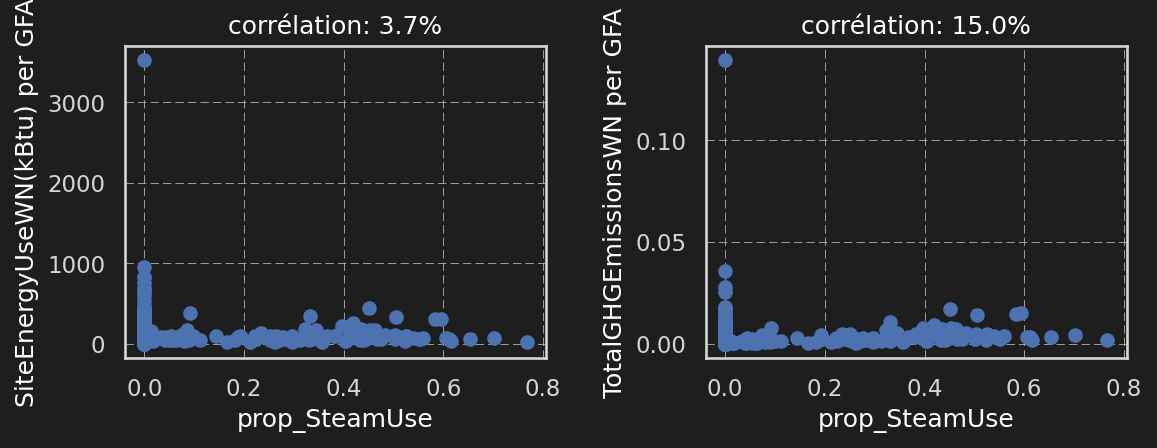

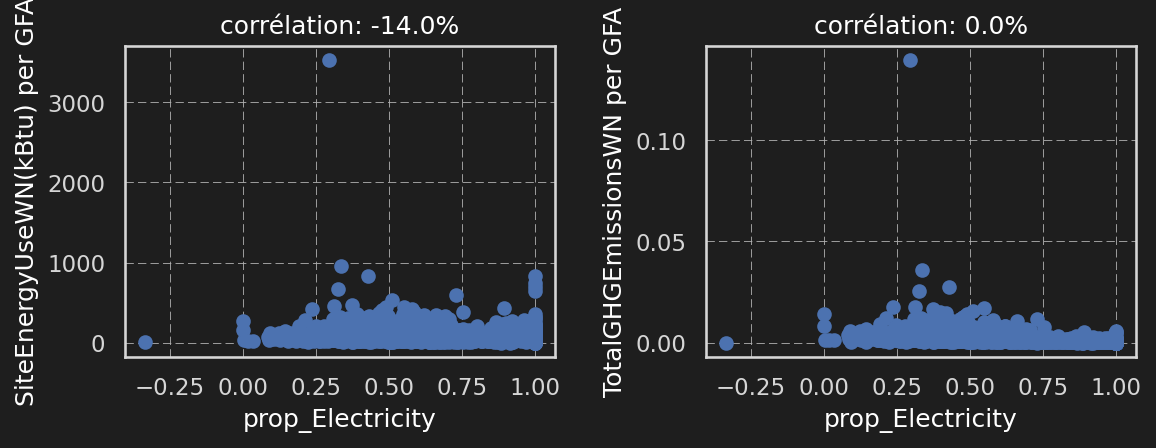

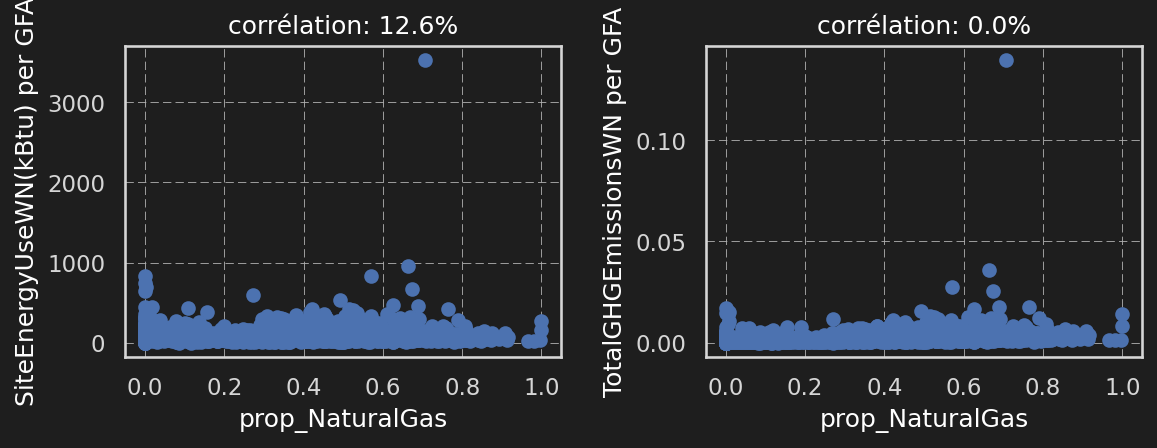

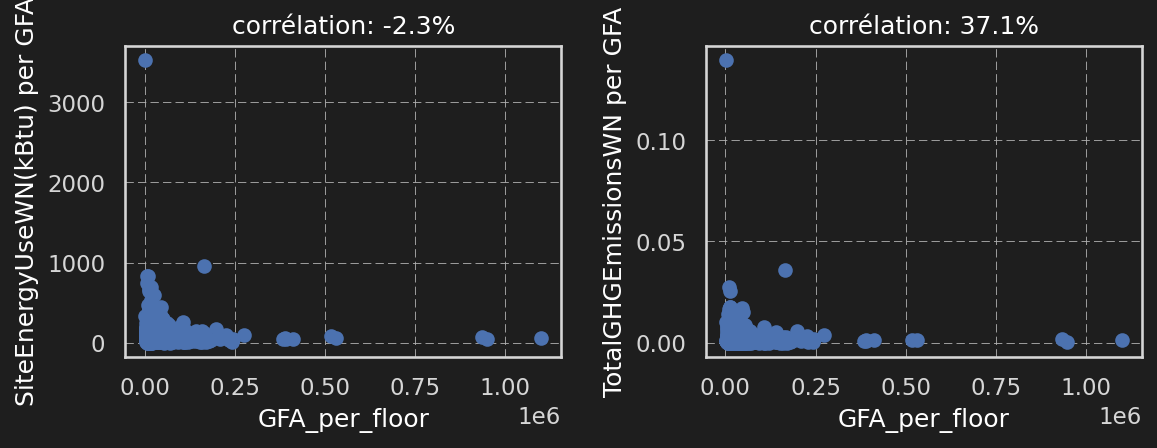

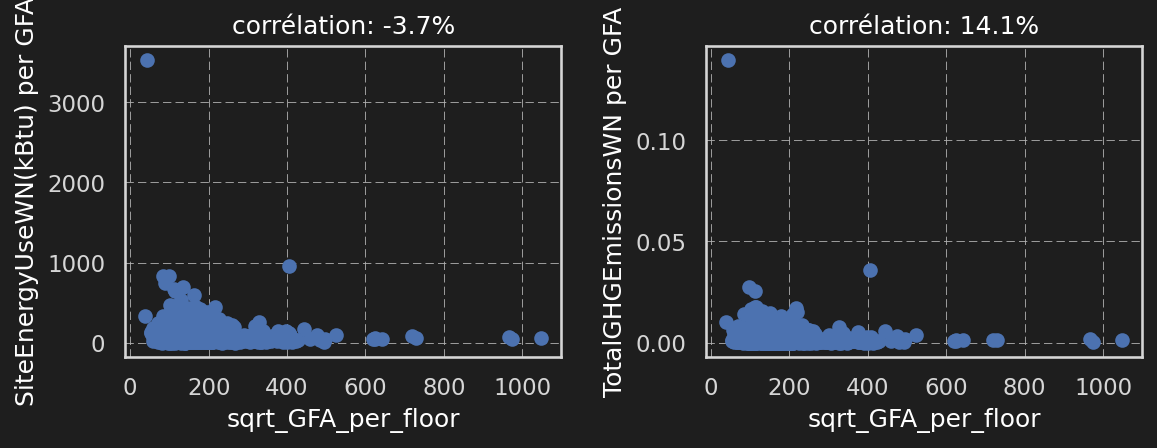

In [96]:
y,y2 = tmp.iloc[:,-2:].values.T

# outlier sur les cibles
loc = y > 1100
sr_loc
display( df_annexe.loc[loc, 'PropertyName'])
display( df.loc[ loc, : ] )

for var in variables:
    fig, axs = plt.subplots( ncols=2, figsize=(20*cm,8*cm) )
    x = tmp[var].values
    axs[0].plot( x, y, 'bo')
    axs[1].plot( x, y2, 'bo')
    axs[0].set_xlabel(var)
    axs[1].set_xlabel(var)
    axs[0].set_ylabel(targets[0] + ' per GFA')
    axs[1].set_ylabel(targets[1] + ' per GFA')
    axs[0].set_title( 'corrélation: {:.1f}%'.format( 100* st.pearsonr(x,y)[0] ) )
    axs[1].set_title( 'corrélation: {:.1f}%'.format( 100* st.pearsonr(x,y)[1] ) )
    fig.tight_layout()

## histogramme / transformation

AgeOfBuilding(s)  CouncilDistrictCode     Latitude    Longitude  \
count       1551.000000          1551.000000  1551.000000  1551.000000   
mean          54.660219             4.410058    47.616304  -122.333510   
std           32.900847             2.194010     0.047022     0.023308   
min            1.000000             1.000000    47.509590  -122.411820   
25%           28.000000             2.000000    47.587695  -122.342940   
50%           51.000000             4.000000    47.612400  -122.333190   
75%           87.000000             7.000000    47.649045  -122.322630   
max          116.000000             7.000000    47.733870  -122.261800   

       NumberofBuildings  NumberofFloors   prop_use_1   prop_use_2  \
count        1551.000000     1551.000000  1551.000000  1551.000000   
mean            1.212121        4.192134     0.948148     0.154102   
std             3.028596        6.267208     0.438830     0.226065   
min             1.000000        1.000000     0.186469     0.000000   
25%             1.000000        1.000000     0.806005     0.000000   
50%             1.000000        2.000000     1.000000     0.000000   
75%             1.000000        4.000000     1.000000     0.270743   
max           111.000000       76.000000     9.900990     2.974256   

        prop_use_3  prop_SteamUse  prop_Electricity  prop_NaturalGas  \
count  1551.000000    1551.000000       1551.000000      1551.000000   
mean      0.025287       0.022467          0.701448         0.272425   
std       0.072386       0.093962          0.265069         0.264414   
min       0.000000       0.000000         -0.336762         0.000000   
25%       0.000000       0.000000          0.490284         0.000000   
50%       0.000000       0.000000          0.710246         0.228567   
75%       0.000000       0.000000          0.999998         0.489359   
max       0.929094       0.766987          1.000011         1.000000   

       GFA_per_floor  sqrt_GFA_per_floor  
count   1.551000e+03         1551.000000  
mean    3.127920e+04          157.049826  
std     5.764929e+04           81.356122  
min     1.433333e+03           37.859389  
25%     1.180067e+04          108.630873  
50%     2.000000e+04          141.421356  
75%     3.134600e+04          177.048012  
max     1.100000e+06         1048.808848

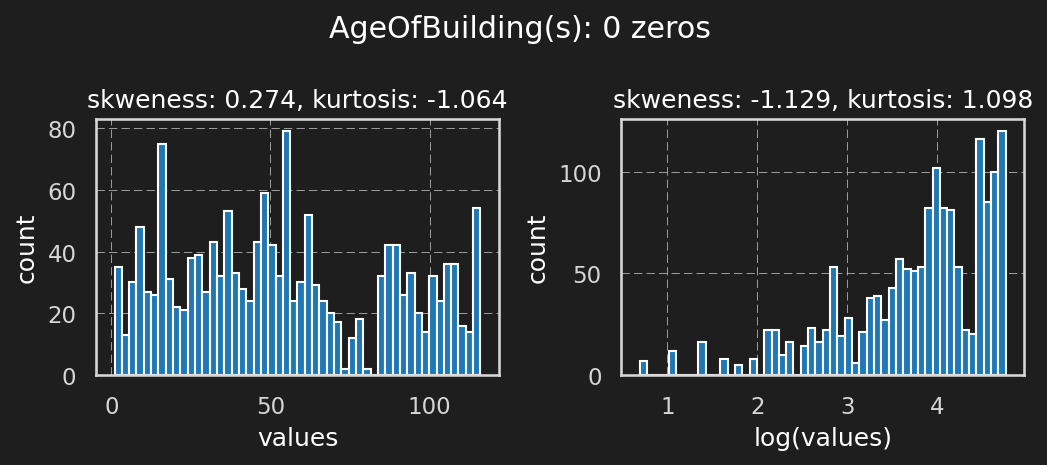

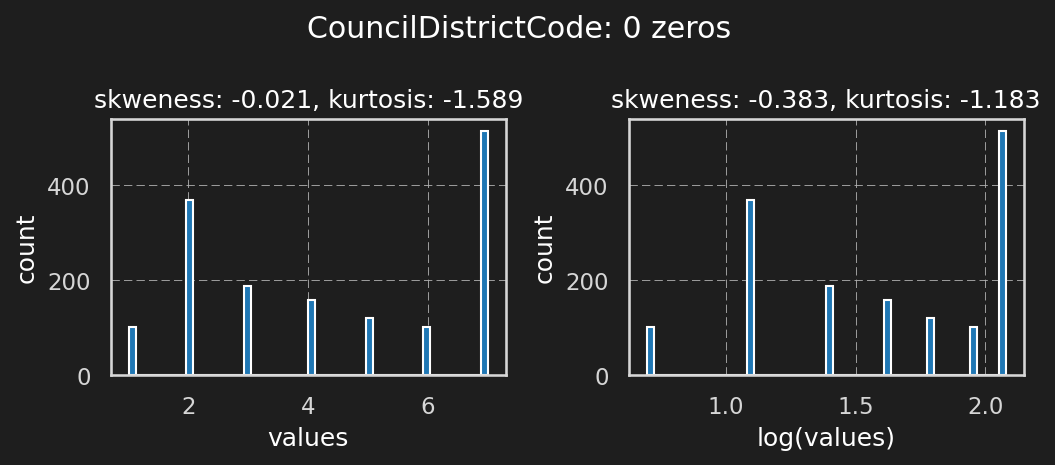

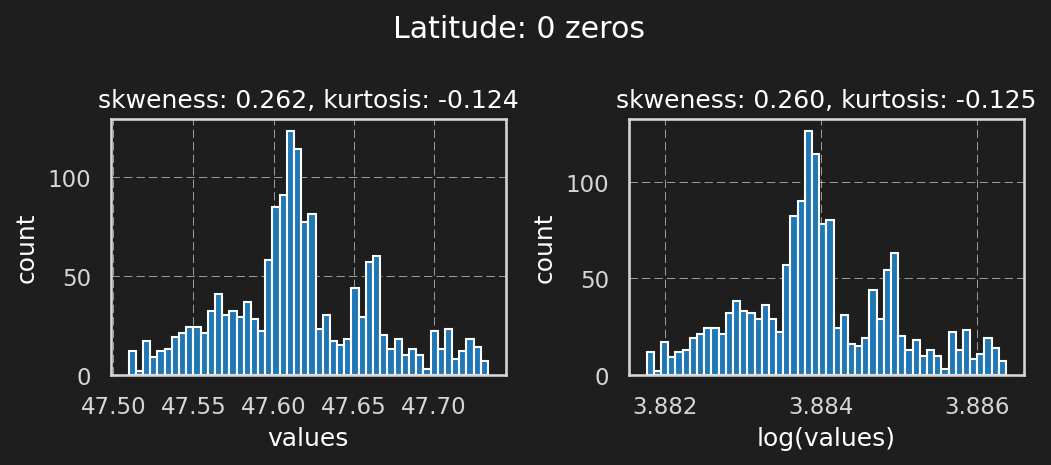

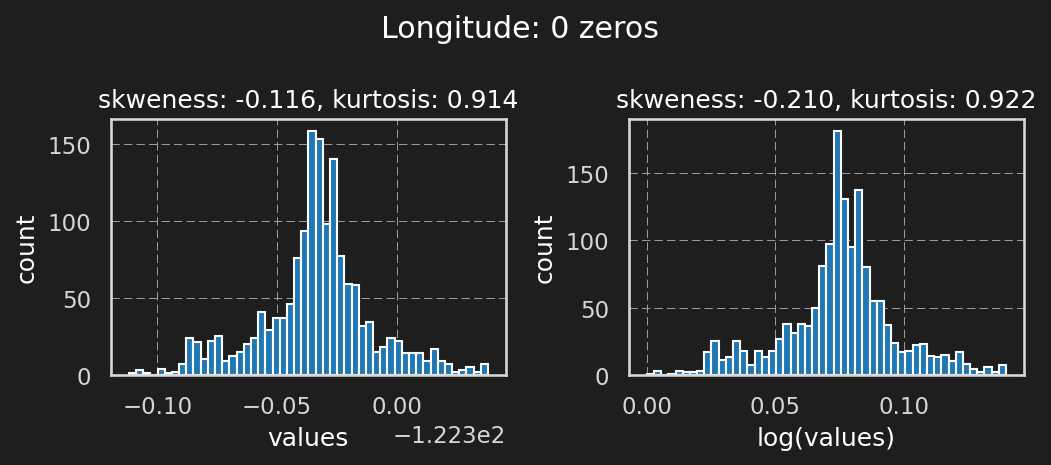

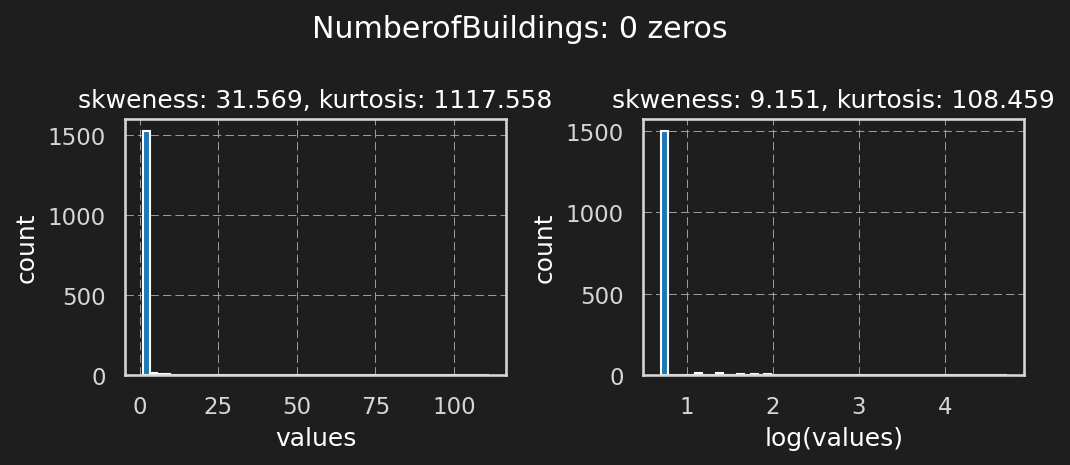

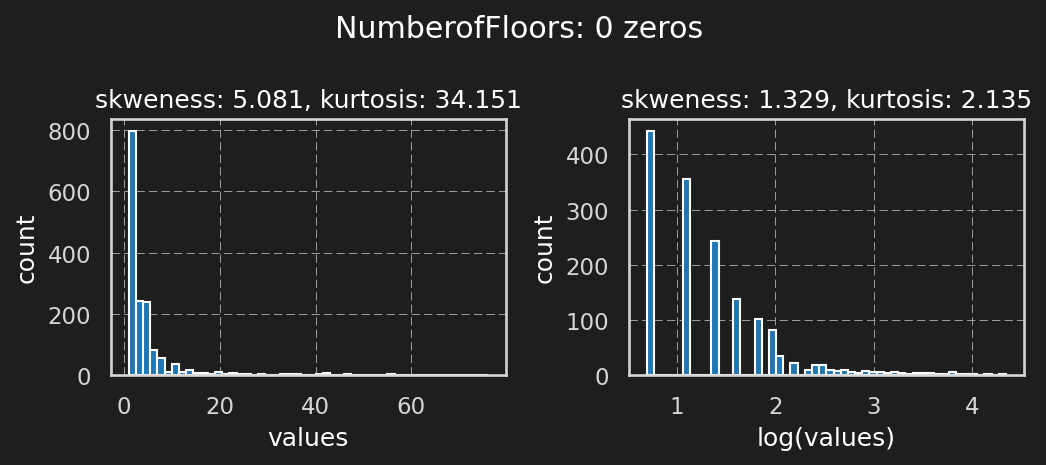

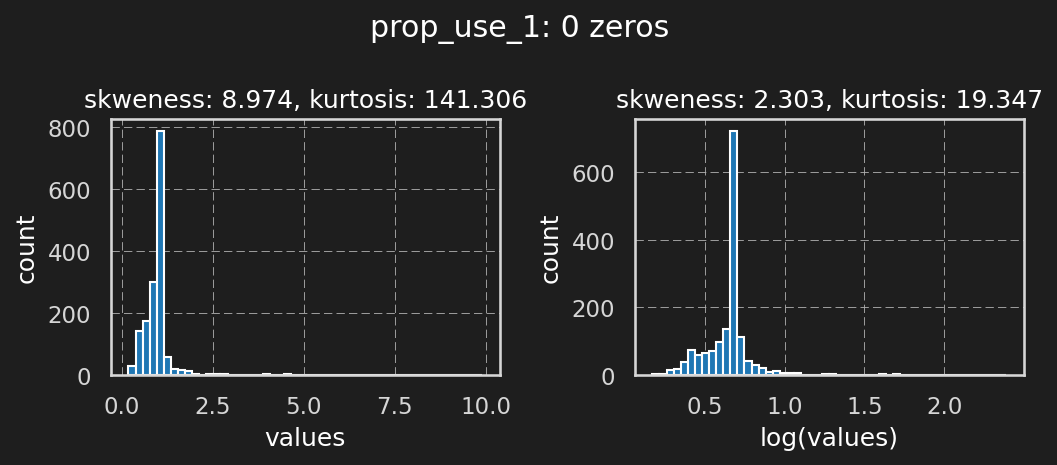

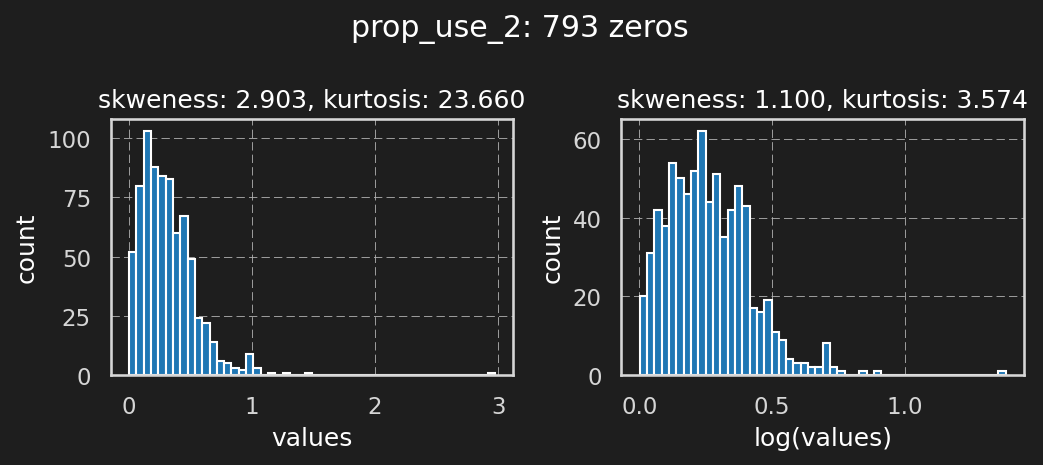

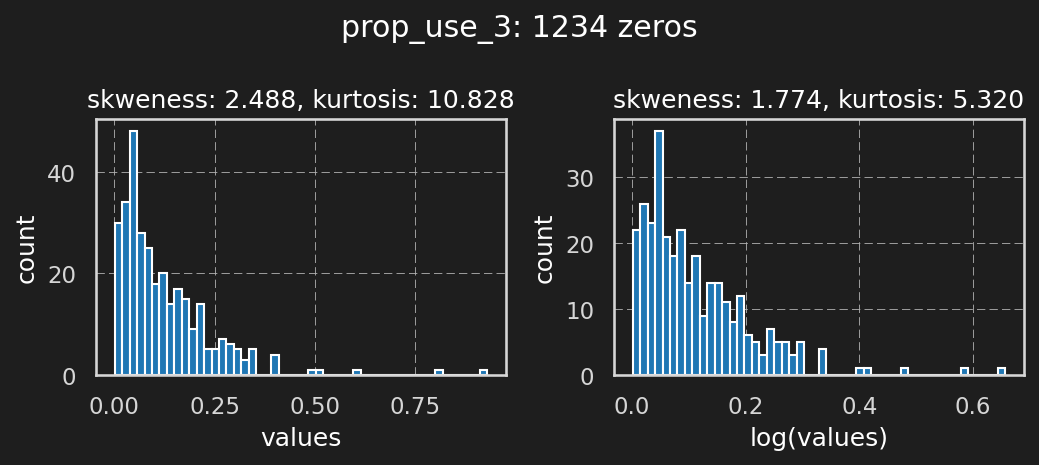

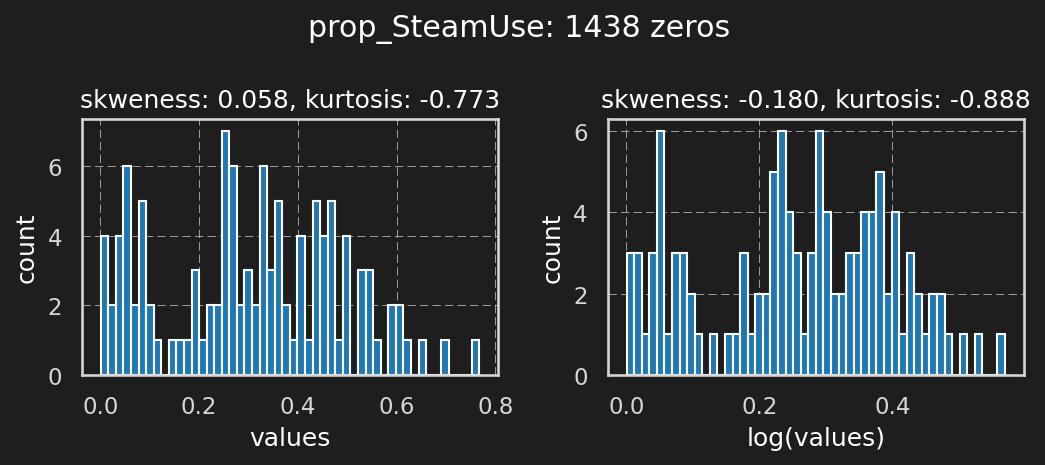

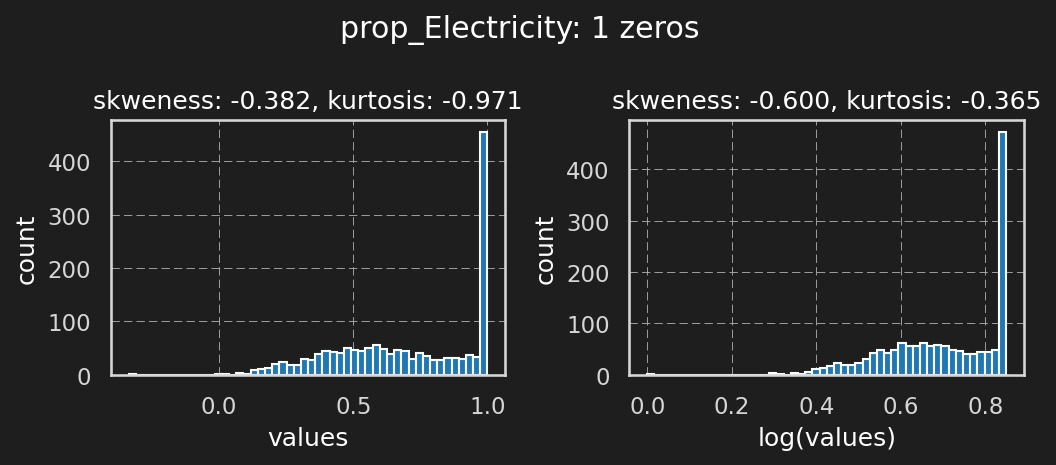

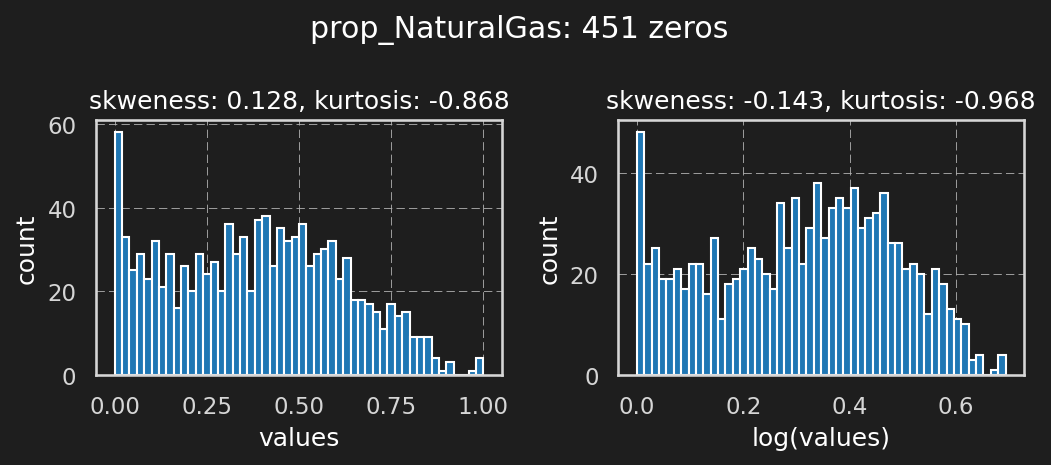

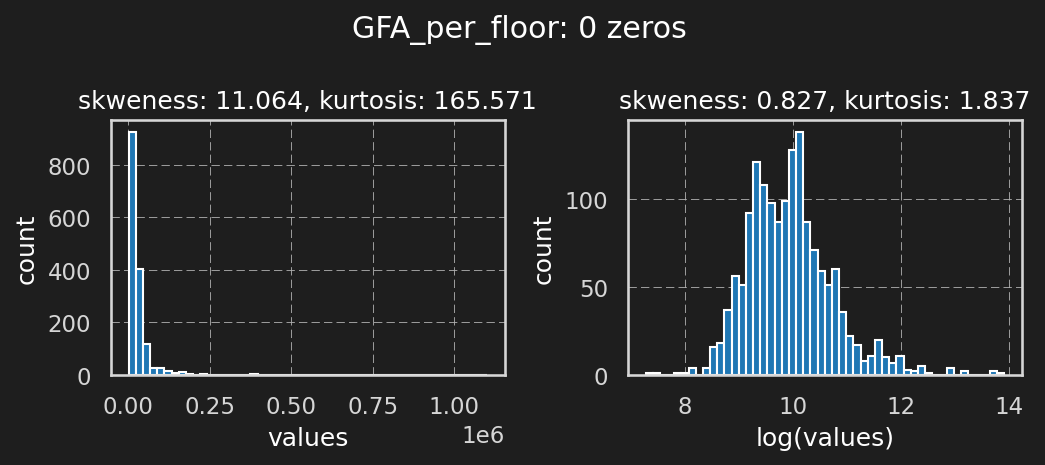

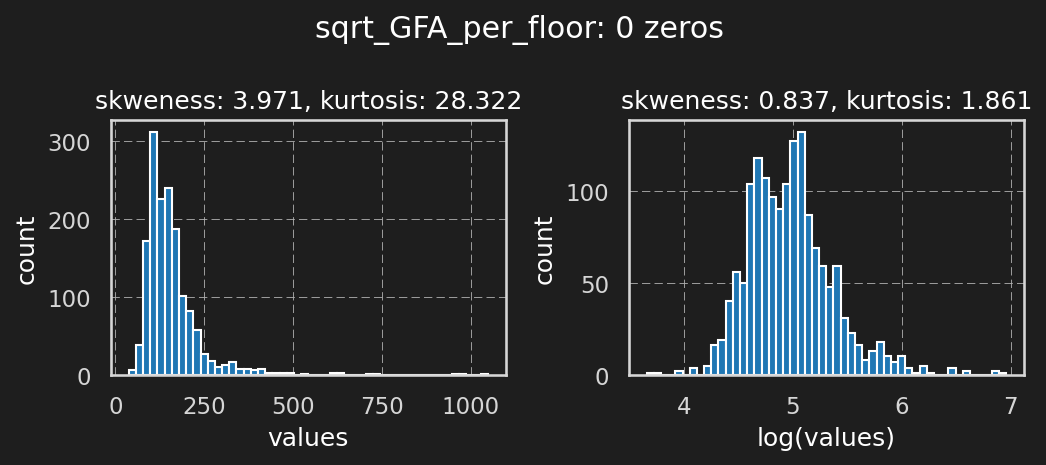

In [97]:
exponents = [1, 0.01, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1]

display( df[variables[1:]].describe() )
# for var, expo in zip(variables[1:], exponents):
for var in variables[1:]:
    values = df[var]
    n_zeros = (values==0).sum()
    values = values[values !=0]
    if '%' in var:
        n_ones = (values==1.).sum()
        values = values[values!=1]
    kurtosis = st.kurtosis( values )
    skew = st.skew( values )

    suptitle = f'{var}: {n_zeros} zeros'
    if '%' in var:
        suptitle += f', {n_ones} ones'

    fig, axs = plt.subplots( ncols=2, figsize=(18*cm,8*cm))
    fig.suptitle( suptitle )
    axs[0].hist( values, bins=50 )
    axs[0].set_xlabel( 'values'  )
    axs[0].set_ylabel( 'count' )
    axs[0].set_title( f'skweness: {skew:.3f}, kurtosis: {kurtosis:.3f}')

    values_log = np.log(values + (1 - min(0,values.min())))
    kurtosis = st.kurtosis( values_log )
    skew = st.skew( values_log )
    axs[1].hist( values_log, bins=50 )
    axs[1].set_xlabel( 'log(values)' )
    axs[1].set_ylabel( 'count' )
    axs[1].set_title( f'skweness: {skew:.3f}, kurtosis: {kurtosis:.3f}')

    # values_pow = values**expo
    # kurtosis = st.kurtosis( values_pow )
    # skew = st.skew( values_pow )
    # axs[2].hist( values_pow, bins=50 )
    # axs[2].set_xlabel( f'values**{expo}' )
    # axs[2].set_ylabel( 'count' )
    # axs[2].set_title( f'skweness: {skew:.3f}, kurtosis: {kurtosis:.3f}')

    fig.tight_layout()


In [98]:
features = [ feature for feature in df.columns if not feature in vars_to_delete ]

print( features )

features_log = df.columns[df.columns.str.contains( '|'.join(['per_floor','Numberof']) )].tolist()
print('\nfeatures à passer au log:\n', features_log )

['AgeOfBuilding(s)', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'Type_use_1', 'prop_use_1', 'Type_use_2', 'prop_use_2', 'Type_use_3', 'prop_use_3', 'prop_SteamUse', 'prop_Electricity', 'prop_NaturalGas', 'GFA_per_floor', 'sqrt_GFA_per_floor', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissionsWN']

features à passer au log:
 ['NumberofBuildings', 'NumberofFloors', 'GFA_per_floor', 'sqrt_GFA_per_floor']


## 5.1 OneHotEncoding

In [99]:
value_counts = df['Type_use_1'].value_counts().add(
    df['Type_use_2'].value_counts(), fill_value=0 ).add(
    df['Type_use_3'].value_counts(), fill_value=0 ).astype(int)

PropertyUseTypes = value_counts.index
PropertyUseTypes = PropertyUseTypes.drop( 'parking' ) # valeur redondante avec % GFA Parking ?
print('propery use types:', PropertyUseTypes.tolist() )

X_propotion_PropertyUseTypeGFA = np.zeros( (len(df), len(PropertyUseTypes)) )
# X_ParkingGFA = np.zeros( len(df) )
for i, index in enumerate(df.index):
    for j in range(1,4) :
        usetype = df.at[index, f'Type_use_{j}']
        if isinstance( usetype, float ): # test if isnan
            break
        if usetype == 'parking':
            # X_ParkingGFA[i] += df.at[ index, 'LargestPropertyUseTypeGFA']
            continue
        k = PropertyUseTypes.get_loc( usetype )
        X_propotion_PropertyUseTypeGFA[i,k] += df.at[index, f'prop_use_{j}']

PropertyUseTypes = [ f'ohe0 {var}' for var in PropertyUseTypes]

propery use types: ['data center', 'education', 'entertainment - public assembly', 'industrial', 'lifestyle center', 'medical', 'medical office', 'office', 'other', 'other - entertainment/public assembly', 'residential - hotel', 'restaurant', 'science', 'self-storage facility', 'services', 'store', 'utility', 'worship facility']


In [100]:
df_hotencoding_usetype = pd.DataFrame( X_propotion_PropertyUseTypeGFA, columns=PropertyUseTypes, index=df.index )
print( 'DataFrame usetype shape:', df_hotencoding_usetype.shape )
df_hotencoding_usetype.head(10).round(2)

DataFrame usetype shape: (1551, 18)


ohe0 data center  ohe0 education  ohe0 entertainment - public assembly  \
0                0.0             0.0                                   0.0   
1                0.0             0.0                                   0.0   
2                0.0             0.0                                   0.0   
3                0.0             0.0                                   0.0   
4                0.0             0.0                                   0.0   
5                0.0             0.0                                   0.0   
6                0.0             0.0                                   0.0   
7                0.0             0.0                                   0.0   
8                0.0             0.0                                   0.0   
10               0.0             0.0                                   0.0   

    ohe0 industrial  ohe0 lifestyle center  ohe0 medical  ohe0 medical office  \
0               0.0                    0.0           0.0                  0.0   
1               0.0                    0.0           0.0                  0.0   
2               0.0                    0.0           0.0                  0.0   
3               0.0                    0.0           0.0                  0.0   
4               0.0                    0.0           0.0                  0.0   
5               0.0                    0.0           0.0                  0.0   
6               0.0                    0.0           0.0                  0.0   
7               0.0                    0.0           0.0                  0.0   
8               0.0                    0.0           0.0                  0.0   
10              0.0                    0.0           0.0                  0.0   

    ohe0 office  ohe0 other  ohe0 other - entertainment/public assembly  \
0           0.0         0.0                                         0.0   
1           0.0         0.0                                         0.0   
2           0.0         0.0                                         0.0   
3           0.0         0.0                                         0.0   
4           0.0         0.0                                         0.0   
5           0.0         0.0                                         0.0   
6           0.0         0.0                                         0.0   
7           0.0         0.0                                         1.0   
8           0.0         0.0                                         0.0   
10          0.0         0.0                                         0.0   

    ohe0 residential - hotel  ohe0 restaurant  ohe0 science  \
0                       1.00             0.00           0.0   
1                       0.95             0.05           0.0   
2                       1.00             0.00           0.0   
3                       1.00             0.00           0.0   
4                       1.09             0.00           0.0   
5                       0.00             0.00           0.0   
6                       0.98             0.00           0.0   
7                       0.00             0.00           0.0   
8                       1.00             0.00           0.0   
10                      1.00             0.00           0.0   

    ohe0 self-storage facility  ohe0 services  ohe0 store  ohe0 utility  \
0                          0.0            0.0         0.0          0.00   
1                          0.0            0.0         0.0          0.00   
2                          0.0            0.0         0.0          0.00   
3                          0.0            0.0         0.0          0.00   
4                          0.0            0.0         0.0          0.00   
5                          0.0            0.0         0.0          1.48   
6                          0.0            0.0         0.0          0.00   
7                          0.0            0.0         0.0          0.00   
8                          0.0            0.0         0.0 

In [101]:
key = 'Neighborhood'
df[key] = df[key].astype('category')
print( df[key].cat.categories )
features_location = [ f'ohe1 {var}' for var in df[key].cat.categories.tolist()]

X_location = np.zeros( (len(df), len(df[key].cat.categories) ) )
X_location[range(len(df)), df[key].cat.codes] = 1.
df_hotencoding_location = pd.DataFrame( X_location, columns=features_location, index=df.index )

print( 'DataFrame location shape:', df_hotencoding_location.shape )
display(df_hotencoding_location.sample(5) )

Index(['ballard', 'central', 'delridge', 'downtown', 'east',
       'greater duwamish', 'lake union', 'magnolia / queen anne', 'north',
       'northeast', 'northwest', 'southeast', 'southwest'],
      dtype='object')
DataFrame location shape: (1551, 13)


ohe1 ballard  ohe1 central  ohe1 delridge  ohe1 downtown  ohe1 east  \
464            0.0           0.0            0.0            0.0        0.0   
237            0.0           0.0            0.0            1.0        0.0   
651            0.0           0.0            0.0            0.0        0.0   
46             0.0           0.0            0.0            1.0        0.0   
2383           0.0           0.0            0.0            0.0        0.0   

      ohe1 greater duwamish  ohe1 lake union  ohe1 magnolia / queen anne  \
464                     1.0              0.0                         0.0   
237                     0.0              0.0                         0.0   
651                     0.0              0.0                         0.0   
46                      0.0              0.0                         0.0   
2383                    0.0              1.0                         0.0   

      ohe1 north  ohe1 northeast  ohe1 northwest  ohe1 southeast  \
464          0.0             0.0             0.0             0.0   
237          0.0             0.0             0.0             0.0   
651          0.0             1.0             0.0             0.0   
46           0.0             0.0             0.0             0.0   
2383         0.0             0.0             0.0             0.0   

      ohe1 southwest  
464              0.0  
237              0.0  
651              0.0  
46               0.0  
2383             0.0

In [102]:
print('DataFrame shape:', df.shape )
df.drop( columns= ['Neighborhood', 'Type_use_1', 'prop_use_1', 
    'Type_use_2', 'prop_use_2', 'Type_use_3', 'prop_use_3'], inplace=True )
print('DataFrame shape:', df.shape )

DataFrame shape: (1551, 20)
DataFrame shape: (1551, 13)


In [103]:
df.columns

Index(['AgeOfBuilding(s)', 'CouncilDistrictCode', 'Latitude', 'Longitude',
       'NumberofBuildings', 'NumberofFloors', 'prop_SteamUse',
       'prop_Electricity', 'prop_NaturalGas', 'GFA_per_floor',
       'sqrt_GFA_per_floor', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissionsWN'],
      dtype='object')

# 6. Sauvegarde

In [104]:
path = 'data/cleaned/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

with open( path + filename + 'features_log', 'wb') as file:
    pickle.dump( features_log , file )

df.to_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression)
df_annexe.to_pickle( r'{:}{:}_annexe.pkl'.format(path, filename), compression=compression)
df_hotencoding_usetype.to_pickle( r'{:}{:}_usetype.pkl'.format(path, filename), compression=compression)
df_hotencoding_location.to_pickle( r'{:}{:}_location.pkl'.format(path, filename), compression=compression)